<a href="https://colab.research.google.com/github/rodrigofvale/6502ide/blob/master/Graph_Notebook_(External).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare Environment



In [ ]:
!pip install bigquery_magics==0.8.1
!pip install spanner-graph-notebook==1.1.5

/bin/sh: line 1: pip: command not found
/bin/sh: line 1: pip: command not found


In [ ]:
!gcloud auth application-default login

/bin/sh: line 1: gcloud: command not found


# Create dataset and graph node, edge tables

BigQuery Graph creates graphs from input tables, so the data of the graph is based on those from input tables, with no data duplication. Likewise, data changes in input tables are automatically reflected in the graph model. This avoids complicated ETL for syncing with other data sources.

The following queries created a dataset `graph_db` and relational tables necessary for a finance graph.


In [ ]:
# Create a dataset to store graph related tables

%%bigquery
CREATE SCHEMA IF NOT EXISTS graph_db;

DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.

In [ ]:
# Create a a list of graph node and edge tables

%%bigquery
CREATE TABLE IF NOT EXISTS graph_db.Person (
  id                  INT64 NOT NULL,
  name                STRING,
  PRIMARY KEY (id) NOT ENFORCED
);
CREATE TABLE IF NOT EXISTS graph_db.Account (
  id                     INT64 NOT NULL,
  create_time            TIMESTAMP,
  is_blocked             BOOL,
  type                   STRING,
  description            STRING,
  description_embeddings ARRAY<FLOAT64>,
  PRIMARY KEY (id) NOT ENFORCED
);
CREATE TABLE IF NOT EXISTS graph_db.Loan (
  id                  INT64 NOT NULL,
  loan_amount         FLOAT64,
  balance             FLOAT64,
  create_time         TIMESTAMP,
  interest_rate       FLOAT64,
PRIMARY KEY (id) NOT ENFORCED
);
CREATE TABLE IF NOT EXISTS graph_db.AccountTransferAccount (
  id                  INT64 NOT NULL,
  to_id               INT64 NOT NULL,
  amount              FLOAT64,
  create_time         TIMESTAMP NOT NULL,
  PRIMARY KEY (id, to_id, create_time) NOT ENFORCED
);
CREATE TABLE IF NOT EXISTS graph_db.AccountRepayLoan (
  id                  INT64 NOT NULL,
  loan_id             INT64 NOT NULL,
  amount              FLOAT64,
  create_time         TIMESTAMP NOT NULL,
  PRIMARY KEY (id, loan_id, create_time) NOT ENFORCED
);
CREATE TABLE IF NOT EXISTS graph_db.PersonOwnAccount (
  id                  INT64 NOT NULL,
  account_id          INT64 NOT NULL,
  create_time         TIMESTAMP,
  PRIMARY KEY (id, account_id) NOT ENFORCED
);
CREATE TABLE IF NOT EXISTS graph_db.AccountAudits (
  id                  INT64 NOT NULL,
  audit_timestamp     TIMESTAMP,
  audit_details       STRING,
  PRIMARY KEY (id, audit_timestamp) NOT ENFORCED
);

# Load the data

Now, you will want to insert some finance graph data into your graph node and edge tables.

You can use your familiar SQL INSERT statements to insert data into the input tables.

In [ ]:
%%bigquery

INSERT INTO graph_db.Account (id, create_time, is_blocked, type, description, description_embeddings) VALUES
(1, '2020-01-10 06:22:20.222', false, 'brokerage account',       'Primary brokerage account #1',        [0.101, -0.202, 0.303, -0.404, 0.505]),
(2, '2020-01-27 17:55:09.206', false, 'prepaid card',          'General prepaid card #2',             [-0.212, 0.313, -0.414, 0.515, -0.616]),
(3, '2020-02-18 05:44:20.655', false, 'brokerage account',       'Secondary brokerage savings #3',      [0.323, -0.424, 0.525, -0.626, 0.727]),
(4, '2020-02-29 08:49:53.902', false, 'debit card',            'Everyday checking debit card #4',     [-0.434, 0.535, -0.636, 0.737, -0.838]),
(5, '2020-03-02 12:47:18.726', false, 'brokerage account',       'Investment portfolio main #5',        [0.545, -0.646, 0.747, -0.848, 0.949]),
(6, '2020-03-21 15:25:34.327', false, 'custodial account',     'Childs education fund #6',          [-0.656, 0.757, -0.858, 0.959, -1.060]),
(7, '2020-04-13 17:53:48.932', false, 'brokerage account',       'Taxable brokerage account #7',        [0.767, -0.868, 0.969, -1.070, 1.171]),
(8, '2020-04-14 20:08:15.427', true,  'trust account',           'Blocked trust distribution #8',       [-0.878, 0.979, -1.080, 1.181, -1.282]),
(9, '2020-04-20 06:20:25.717', false, 'certificate of deposit',  'Savings CD account #9',               [0.989, -1.090, 1.191, -1.292, 1.393]),
(10,'2020-04-25 17:12:17.773', false, 'debit card',            'Secondary account debit card #10',    [-1.010, 1.111, -1.212, 1.313, -1.414]),
(11,'2020-05-01 12:42:05.751', false, 'escrow account',        'Real estate escrow payment #11',      [1.121, -1.222, 1.323, -1.424, 1.525]),
(12,'2020-05-07 09:31:24.731', false, 'corporate account',     'Main business corporate acct #12',    [-1.232, 1.333, -1.434, 1.535, -1.636]),
(13,'2020-05-12 02:54:39.380', false, 'prepaid card',          'Travel expense prepaid card #13',     [1.343, -1.444, 1.545, -1.646, 1.747]),
(14,'2020-05-12 07:20:33.922', false, 'escrow account',        'Contractor escrow holding #14',     [-1.454, 1.555, -1.656, 1.757, -1.858]),
(15,'2020-05-17 23:48:13.525', false, 'certificate of deposit',  'Long term CD plan #15',             [1.565, -1.666, 1.767, -1.868, 1.969]),
(16,'2020-05-22 13:25:24.547', false, 'escrow account',        'Rental security deposit escrow #16',  [-1.676, 1.777, -1.878, 1.979, -2.080]),
(17,'2020-05-24 23:04:09.662', false, 'debit card',            'Business expense debit card #17',     [1.787, -1.888, 1.989, -2.090, 2.191]),
(18,'2020-05-25 13:28:18.687', false, 'prepaid card',          'Gift certificate prepaid #18',        [-1.898, 1.999, -2.010, 2.111, -2.212]),
(19,'2020-05-26 08:20:41.462', false, 'brokerage account',       'Stock investment account #19',        [1.919, -2.020, 2.121, -2.222, 2.323]),
(20,'2020-05-26 21:45:21.362', false, 'internet account',      'Online services payment #20',         [-2.030, 2.131, -2.232, 2.333, -2.434]),
(21,'2020-05-29 11:12:33.826', false, 'certificate of deposit',  'CD ladder investment #21',          [2.141, -2.242, 2.343, -2.444, 2.545]),
(22,'2020-06-02 23:51:28.653', false, 'trust account',         'Family trust main #22',               [-2.252, 2.353, -2.454, 2.555, -2.656]),
(23,'2020-06-10 23:13:28.056', false, 'debit card',            'Emergency fund access card #23',      [2.363, -2.464, 2.565, -2.666, 2.767]),
(24,'2020-06-13 07:03:04.044', false, 'prepaid card',          'Refund issued prepaid card #24',      [-2.474, 2.575, -2.676, 2.777, -2.878]),
(25,'2020-06-18 00:04:22.973', false, 'debit card',            'Allowance debit account #25',         [2.585, -2.686, 2.787, -2.888, 2.989]),
(26,'2020-06-20 02:42:12.633', false, 'foreign currency',      'Travel currency fund (EUR) #26',      [-2.696, 2.797, -2.898, 2.999, -3.010]),
(27,'2020-06-27 03:53:28.622', false, 'internet account',      'Subscription management #27',         [2.717, -2.818, 2.919, -3.020, 3.121]),
(28,'2020-07-04 05:56:27.958', false, 'prepaid card',          'Rebate program prepaid #28',          [-2.828, 2.929, -3.030, 3.131, -3.232]),
(29,'2020-07-05 22:59:05.522', false, 'foreign currency',      'Holding account (JPY) #29',           [2.939, -3.040, 3.141, -3.242, 3.343]),
(30,'2020-07-06 16:40:38.026', false, 'corporate account',     'Operations corporate account #30',    [-3.050, 3.151, -3.252, 3.353, -3.454]),
(31,'2020-07-07 22:50:08.234', false, 'prepaid card',          'Public transit prepaid pass #31',     [3.161, -3.262, 3.363, -3.464, 3.565]),
(32,'2020-07-08 02:44:39.090', false, 'trust account',         'Inheritance trust fund #32',          [-3.272, 3.373, -3.474, 3.575, -3.676]),
(33,'2020-07-14 10:52:04.924', false, 'debit card',            'Spouses debit card #33',           [3.383, -3.484, 3.585, -3.686, 3.787]),
(34,'2020-07-17 02:39:41.539', false, 'trust account',         'Charitable giving trust #34',         [-3.494, 3.595, -3.696, 3.797, -3.898]),
(35,'2020-07-18 13:55:27.536', false, 'credit card',           'Primary rewards credit card #35',     [3.515, -3.616, 3.717, -3.818, 3.919]),
(36,'2020-07-19 18:34:04.354', false, 'custodial account',     'UTMA account for nephew #36',         [-3.626, 3.727, -3.828, 3.929, -4.030]),
(37,'2020-07-20 04:59:56.786', false, 'custodial account',     'Custodial savings for college #37',   [3.737, -3.838, 3.939, -4.040, 4.141]),
(38,'2020-07-27 12:05:32.638', false, 'debit card',            'Shared household expenses card #38',  [-3.848, 3.949, -4.050, 4.151, -4.252]),
(39,'2020-07-30 04:39:01.645', false, 'retirement account',    'Main retirement savings plan #39',    [3.959, -4.060, 4.161, -4.262, 4.363]),
(40,'2020-07-31 11:38:18.198', false, 'retirement account',    'Spouses retirement fund #40',      [-4.070, 4.171, -4.272, 4.373, -4.474]),
(41,'2020-08-02 09:08:22.656', false, 'foreign currency',      'International business travel #41',   [4.181, -4.282, 4.383, -4.484, 4.585]),
(42,'2020-08-02 11:50:21.996', false, 'debit card',            'Savings account access card #42',     [-4.292, 4.393, -4.494, 4.595, -4.696]),
(43,'2020-08-06 05:31:50.574', false, 'foreign currency',      'Vacation fund (CAD) #43',             [4.313, -4.414, 4.515, -4.616, 4.717]),
(44,'2020-08-08 19:05:07.512', false, 'brokerage account',       'Growth stock portfolio #44',        [-4.424, 4.525, -4.626, 4.727, -4.828]),
(45,'2020-08-09 21:46:34.800', false, 'prepaid card',          'Employee expense prepaid #45',        [4.535, -4.636, 4.737, -4.838, 4.939]),
(46,'2020-08-09 22:53:40.287', false, 'custodial account',     'Grandchilds savings account #46',  [-4.646, 4.747, -4.848, 4.949, -5.050]),
(47,'2020-08-10 07:35:44.962', false, 'prepaid card',          'Online purchase security card #47',   [4.757, -4.858, 4.959, -5.060, 5.161]),
(48,'2020-08-10 09:44:04.774', true,  'certificate of deposit',  'Blocked CD for loan collateral #48',[-4.868, 4.969, -5.070, 5.171, -5.272]),
(49,'2020-08-11 03:40:41.045', false, 'custodial account',     'UGMA investment account #49',         [4.979, -5.080, 5.181, -5.282, 5.383]),
(50,'2020-08-11 07:31:33.655', false, 'retirement account',    'Primary 401k account #50',          [-5.090, 5.191, -5.292, 5.393, -5.494]),
(51,'2020-08-12 19:49:11.684', false, 'escrow account',        'Business sale escrow funds #51',      [5.111, -5.212, 5.313, -5.414, 5.515]),
(52,'2020-08-12 21:26:22.150', false, 'foreign currency',      'Holding account (GBP) #52',           [-5.222, 5.323, -5.424, 5.525, -5.626]),
(53,'2020-08-15 08:39:41.839', false, 'foreign currency',      'Study abroad funds (AUD) #53',        [5.333, -5.434, 5.535, -5.636, 5.737]),
(54,'2020-08-15 11:15:30.647', false, 'custodial account',     'Minors first bank account #54',     [-5.444, 5.545, -5.646, 5.747, -5.848]),
(55,'2020-08-15 16:01:36.985', false, 'brokerage account',       'Dividend stock account #55',        [5.555, -5.656, 5.757, -5.858, 5.959]),
(56,'2020-08-24 06:00:08.942', false, 'retirement account',    'Self-directed IRA #56',             [-5.666, 5.767, -5.868, 5.969, -6.070]),
(57,'2020-08-25 21:45:39.750', false, 'foreign currency',      'International relocation fund #57',   [5.777, -5.878, 5.979, -6.080, 6.181]),
(58,'2020-08-29 16:24:18.633', false, 'brokerage account',       'Speculative investment fund #58',     [-5.888, 5.989, -6.090, 6.191, -6.292]),
(59,'2020-08-30 22:31:59.522', true,  'certificate of deposit',  'CD early withdrawal block #59',     [5.999, -6.010, 6.111, -6.212, 6.313]),
(60,'2020-08-31 01:11:41.554', false, 'trust account',         'Special needs trust savings #60',     [-6.020, 6.121, -6.222, 6.323, -6.424]),
(61,'2020-09-03 11:10:31.293', false, 'internet account',      'Online course access #61',            [6.131, -6.232, 6.333, -6.434, 6.535]),
(62,'2020-09-03 21:45:38.601', false, 'brokerage account',       'Roth IRA brokerage link #62',       [-6.242, 6.343, -6.444, 6.545, -6.646]),
(63,'2020-09-06 02:58:04.078', false, 'foreign currency',      'Import payment fund (CNY) #63',       [6.353, -6.454, 6.555, -6.656, 6.757]),
(64,'2020-09-09 20:20:39.170', false, 'prepaid card',          'Gaming tournament prize card #64',    [-6.464, 6.565, -6.666, 6.767, -6.868]),
(65,'2020-09-12 22:03:48.188', false, 'prepaid card',          'Loyalty program reward card #65',     [6.575, -6.676, 6.777, -6.878, 6.979]),
(66,'2020-09-18 03:49:33.735', false, 'trust account',         'Trust for surviving spouse #66',      [-6.686, 6.787, -6.888, 6.989, -7.090]),
(67,'2020-09-18 23:43:57.301', false, 'foreign currency',      'Currency for overseas tuition #67',   [6.797, -6.898, 6.999, -7.010, 7.111]),
(68,'2020-09-20 01:00:25.700', false, 'certificate of deposit',  'Down payment savings CD #68',       [-6.818, 7.019, -7.120, 7.221, -7.322]),
(69,'2020-09-22 06:55:49.873', false, 'credit card',           'Business supplies credit card #69',   [7.029, -7.130, 7.231, -7.332, 7.433]),
(70,'2020-09-23 14:55:42.597', false, 'certificate of deposit',  'Variable rate CD #70',              [-7.140, 7.241, -7.342, 7.443, -7.544]),
(71,'2020-09-25 11:14:17.006', false, 'custodial account',     'Child support custodial #71',         [7.251, -7.352, 7.453, -7.554, 7.655]),
(72,'2020-09-25 17:42:44.351', false, 'retirement account',    'Pension benefit payout #72',          [-7.362, 7.463, -7.564, 7.665, -7.766]),
(73,'2020-09-25 20:02:14.781', false, 'debit card',            'Student checking debit card #73',     [7.473, -7.574, 7.675, -7.776, 7.877]),
(74,'2020-09-26 02:11:28.268', false, 'credit card',           'Gas station credit card #74',         [-7.584, 7.685, -7.786, 7.887, -7.988]),
(75,'2020-09-26 15:16:16.604', false, 'escrow account',        'Software source code escrow #75',     [7.695, -7.796, 7.897, -7.998, 8.099]),
(76,'2020-09-26 23:27:19.193', false, 'debit card',            'Vacation fund debit access #76',      [-7.716, 8.017, -8.118, 8.219, -8.320]),
(77,'2020-09-28 19:51:20.008', false, 'certificate of deposit',  'IRA linked CD #77',                 [8.027, -8.128, 8.229, -8.330, 8.431]),
(78,'2020-09-29 00:13:01.697', false, 'certificate of deposit',  'Bump-up CD account #78',            [-8.138, 8.239, -8.340, 8.441, -8.542]),
(79,'2020-09-30 17:41:16.516', false, 'trust account',         'Trust for disabled beneficiary #79',  [8.249, -8.350, 8.451, -8.552, 8.653]),
(80,'2020-10-03 19:42:27.803', false, 'debit card',            'Gift debit card #80',                 [-8.360, 8.461, -8.562, 8.663, -8.764]),
(81,'2020-10-04 22:54:00.124', false, 'debit card',            'Secondary checking account card #81', [8.471, -8.572, 8.673, -8.774, 8.875]),
(82,'2020-10-06 12:22:20.764', false, 'brokerage account',       'Conservative brokerage fund #82',     [-8.582, 8.683, -8.784, 8.885, -8.986]),
(83,'2020-10-06 14:35:38.915', false, 'merchant account',      'Service business merchant #83',       [8.693, -8.794, 8.895, -8.996, 9.097]),
(84,'2020-10-06 20:32:54.987', true,  'trust account',           'Trust under legal review #84',      [-8.714, 9.015, -9.116, 9.217, -9.318]),
(85,'2020-10-09 11:11:21.638', false, 'retirement account',    'Pre-tax retirement savings #85',      [9.025, -9.126, 9.227, -9.328, 9.429]),
(86,'2020-10-15 16:05:12.846', false, 'foreign currency',      'Foreign pension currency #86',        [-9.136, 9.237, -9.338, 9.439, -9.540]),
(87,'2020-10-15 20:43:04.559', false, 'certificate of deposit',  'Educational savings CD #87',        [9.247, -9.348, 9.449, -9.550, 9.651]),
(88,'2020-10-22 05:03:40.496', false, 'merchant account',      'Craft fair merchant account #88',     [-9.358, 9.459, -9.560, 9.661, -9.762]),
(89,'2020-10-22 23:54:54.151', false, 'certificate of deposit',  'Business reserve CD #89',           [9.469, -9.570, 9.671, -9.772, 9.873]),
(90,'2020-10-25 09:04:14.056', false, 'retirement account',    'Post-tax retirement Roth #90',        [-9.580, 9.681, -9.782, 9.883, -9.984]),
(91,'2020-10-26 12:39:53.181', true,  'foreign currency',      'Blocked international wire #91',      [9.691, -9.792, 9.893, -9.994, 10.095]),
(92,'2020-10-26 14:33:29.071', false, 'corporate account',     'Subsidiary operating funds #92',      [-9.712, 10.013, -10.114, 10.215, -10.316]),
(93,'2020-10-27 04:10:25.385', false, 'foreign currency',      'Personal travel fund (EUR) #93',      [10.023, -10.124, 10.225, -10.326, 10.427]),
(94,'2020-10-27 05:01:26.297', false, 'internet account',      'File sharing service account #94',    [-10.134, 10.235, -10.336, 10.437, -10.538]),
(95,'2020-10-27 16:24:27.232', true,  'credit card',           'Credit card over limit block #95',    [10.245, -10.346, 10.447, -10.548, 10.649]),
(96,'2020-10-27 17:10:11.181', false, 'brokerage account',       'Income generating portfolio #96',     [-10.356, 10.457, -10.558, 10.659, -10.760]),
(97,'2020-11-02 16:50:16.480', false, 'trust account',         'Trust for minor beneficiary #97',     [10.467, -10.568, 10.669, -10.770, 10.871]),
(98,'2020-11-03 07:28:44.640', false, 'certificate of deposit',  'CD for future purchase #98',        [-10.578, 10.679, -10.780, 10.881, -10.982]),
(99,'2020-11-04 07:40:40.553', false, 'certificate of deposit',  'Step-up CD investment #99',         [10.689, -10.790, 10.891, -10.992, 11.093]),
(100,'2020-11-10 04:26:17.153', false,'brokerage account',       'Index fund investment #100',        [-10.710, 11.011, -11.112, 11.213, -11.314]),
(101,'2020-11-10 22:05:49.841', false,'foreign currency',      'Currency for import business #101', [11.021, -11.122, 11.223, -11.324, 11.425]),
(102,'2020-11-11 18:44:24.021', false,'certificate of deposit',  'Liquid CD account #102',            [-11.132, 11.233, -11.334, 11.435, -11.536]),
(103,'2020-11-15 01:57:12.581', false,'foreign currency',      'Holding account (CHF) #103',        [11.243, -11.344, 11.445, -11.546, 11.647]),
(104,'2020-11-15 05:50:51.532', true, 'retirement account',    'Retirement account under review #104',[-11.354, 11.455, -11.556, 11.657, -11.758]),
(105,'2020-11-17 12:01:11.565', false,'escrow account',        'Home renovation escrow fund #105',    [11.465, -11.566, 11.667, -11.768, 11.869]),
(106,'2020-11-21 15:35:07.655', true, 'certificate of deposit',  'CD pledged as collateral #106',     [-11.576, 11.677, -11.778, 11.879, -11.980]),
(107,'2020-11-21 20:00:29.833', false,'brokerage account',       'Value investment brokerage #107',   [11.687, -11.788, 11.889, -11.990, 12.091]),
(108,'2020-11-22 08:35:57.964', false,'credit card',           'Travel points credit card #108',    [-11.798, 11.899, -11.910, 12.011, -12.112]),
(109,'2020-11-23 13:01:34.724', false,'trust account',         'Educational trust fund #109',       [11.819, -11.920, 12.021, -12.122, 12.223]),
(110,'2020-11-24 04:01:26.715', false,'trust account',         'Supplemental needs trust #110',     [-11.930, 12.031, -12.132, 12.233, -12.334]),
(111,'2020-11-24 14:18:40.050', false,'foreign currency',      'Overseas property fund #111',       [12.041, -12.142, 12.243, -12.344, 12.445]),
(112,'2020-11-26 02:18:04.433', false,'internet account',      'Cloud computing service bill #112', [-12.152, 12.253, -12.354, 12.455, -12.556]),
(113,'2020-11-27 06:17:46.952', false,'debit card',            'Business checking debit card #113', [12.263, -12.364, 12.465, -12.566, 12.667]),
(114,'2020-11-29 06:46:12.007', false,'credit card',           'Cash advance credit card #114',     [-12.374, 12.475, -12.576, 12.677, -12.778]),
(115,'2020-11-29 17:40:40.327', false,'merchant account',      'Retail storefront merchant #115',   [12.485, -12.586, 12.687, -12.788, 12.889]),
(116,'2020-11-30 08:51:27.372', false,'brokerage account',       'IRA brokerage account #116',        [-12.596, 12.697, -12.798, 12.899, -12.910]),
(117,'2020-11-30 19:45:49.875', false,'internet account',      'Domain name renewal account #117',  [12.617, -12.718, 12.819, -12.920, 13.021]),
(118,'2020-12-03 00:34:33.183', false,'merchant account',      'Event registration merchant #118',  [-12.728, 12.829, -12.930, 13.031, -13.132]),
(119,'2020-12-03 09:43:30.472', false,'custodial account',     'Gifted funds custodial #119',       [12.839, -12.940, 13.041, -13.142, 13.243]),
(120,'2020-12-03 17:18:25.016', false,'custodial account',     'Minors performance earnings #120', [-12.950, 13.051, -13.152, 13.253, -13.354]),
(121,'2020-12-12 08:42:03.791', false,'credit card',           'Secured credit building card #121', [13.061, -13.162, 13.263, -13.364, 13.465]),
(122,'2020-12-13 03:34:15.105', false,'internet account',      'Music subscription service #122',   [-13.172, 13.273, -13.374, 13.475, -13.576]),
(123,'2020-12-13 11:23:00.803', false,'debit card',            'Joint savings account card #123',   [13.283, -13.384, 13.485, -13.586, 13.687]),
(124,'2020-12-14 05:16:10.572', false,'prepaid card',          'Campus dining prepaid card #124',   [-13.394, 13.495, -13.596, 13.697, -13.798]),
(125,'2020-12-15 08:33:18.515', false,'corporate account',     'Payroll funding account #125',      [13.415, -13.516, 13.617, -13.718, 13.819]),
(126,'2020-12-15 19:09:35.512', false,'prepaid card',          'Research study participant card #126',[-13.526, 13.627, -13.728, 13.829, -13.930]),
(127,'2020-12-16 08:36:23.124', false,'brokerage account',       'High-yield bond fund #127',       [13.637, -13.738, 13.839, -13.940, 14.041]),
(128,'2020-12-17 12:07:26.547', false,'foreign currency',      'Foreign real estate rental income #128',[-13.748, 13.849, -13.950, 14.051, -14.152]),
(129,'2020-12-18 13:42:59.981', false,'merchant account',      'Online advertising revenue #129',   [13.859, -13.960, 14.061, -14.162, 14.263]),
(130,'2020-12-19 05:47:14.714', false,'retirement account',    '457(b) retirement plan #130',       [-13.970, 14.071, -14.172, 14.273, -14.374]),
(131,'2020-12-20 19:50:44.173', false,'trust account',         'Revocable trust for spouse #131',   [14.081, -14.182, 14.283, -14.384, 14.485]),
(132,'2020-12-22 01:44:50.711', false,'corporate account',     'Employee benefit funding #132',     [-14.192, 14.293, -14.394, 14.495, -14.596]),
(133,'2020-12-23 02:31:46.849', false,'foreign currency',      'International charity donation #133', [14.213, -14.314, 14.415, -14.516, 14.617]),
(134,'2020-12-23 10:07:28.308', false,'merchant account',      'Digital download sales #134',       [-14.324, 14.425, -14.526, 14.627, -14.728]),
(135,'2020-12-23 23:06:04.601', true, 'retirement account',    'Retirement plan loan default #135', [14.435, -14.536, 14.637, -14.738, 14.839]),
(136,'2020-12-24 01:27:15.123', false,'credit card',           'Business entertainment card #136',  [-14.546, 14.647, -14.748, 14.849, -14.950]),
(137,'2020-12-24 03:01:42.112', false,'trust account',         'Life insurance trust #137',         [14.657, -14.758, 14.859, -14.960, 15.061]),
(138,'2020-12-24 23:57:34.334', false,'debit card',            'Bill payment debit card #138',      [-14.768, 14.869, -14.970, 15.071, -15.172]),
(139,'2020-12-25 05:47:40.479', false,'merchant account',      'Holiday sales merchant funds #139', [14.879, -14.980, 15.081, -15.182, 15.283]),
(140,'2020-12-27 23:42:26.114', false,'escrow account',        'Divorce settlement escrow #140',    [-14.990, 15.091, -15.192, 15.293, -15.394]),
(141,'2020-12-28 17:26:15.005', true, 'brokerage account',       'Brokerage account frozen #141',     [15.011, -15.112, 15.213, -15.314, 15.415]),
(142,'2020-12-29 07:23:26.859', false,'retirement account',    'Small business retirement #142',    [-15.122, 15.223, -15.324, 15.425, -15.526]),
(143,'2020-12-29 17:45:00.686', false,'credit card',           'Points transfer partner card #143', [15.233, -15.334, 15.435, -15.536, 15.637]),
(144,'2020-12-30 05:19:17.833', false,'retirement account',    'Non-deductible IRA #144',           [-15.344, 15.445, -15.546, 15.647, -15.748]),
(145,'2020-12-30 08:35:00.131', false,'credit card',           'Company purchase card #145',        [15.455, -15.556, 15.657, -15.758, 15.859]),
(146,'2020-12-30 14:53:41.636', false,'custodial account',     'Grandparent gift custodial #146',   [-15.566, 15.667, -15.768, 15.869, -15.970]),
(147,'2020-12-31 03:02:15.119', false,'escrow account',        'Tax payment escrow #147',           [15.677, -15.778, 15.879, -15.980, 16.081]),
(148,'2020-12-31 10:47:52.400', false,'brokerage account',       'Long/short strategy fund #148',   [-15.788, 15.889, -15.990, 16.091, -16.192]),
(149,'2020-12-31 12:33:49.457', false,'foreign currency',      'International trade currency #149', [15.899, -15.910, 16.011, -16.112, 16.213]),
(150,'2021-01-01 19:32:16.681', false,'credit card',           'New Year promotion card #150',      [-15.920, 16.021, -16.122, 16.223, -16.324]),
(151,'2021-01-02 10:38:47.288', false,'escrow account',        'Home sale proceeds escrow #151',    [16.031, -16.132, 16.233, -16.334, 16.435]),
(152,'2021-01-02 14:59:12.578', false,'corporate account',     'Marketing budget account #152',     [-16.142, 16.243, -16.344, 16.445, -16.546]),
(153,'2021-01-03 16:55:19.952', false,'merchant account',      'Farmers market vendor account #153',[16.253, -16.354, 16.455, -16.556, 16.657]),
(154,'2021-01-05 01:56:38.675', false,'merchant account',      'Pop-up shop merchant funds #154',   [-16.364, 16.465, -16.566, 16.667, -16.768]),
(155,'2021-01-05 04:37:32.382', false,'certificate of deposit',  'College savings CD #155',           [16.475, -16.576, 16.677, -16.778, 16.879]),
(156,'2021-01-06 06:31:43.275', true, 'foreign currency',      'Foreign account under hold #156',   [-16.586, 16.687, -16.788, 16.889, -16.990]),
(157,'2021-01-08 02:50:21.882', false,'merchant account',      'Patreon creator payout #157',       [16.697, -16.798, 16.899, -16.910, 17.011]),
(158,'2021-01-09 09:13:31.088', false,'retirement account',    'Company match retirement #158',     [-16.718, 17.019, -17.120, 17.221, -17.322]),
(159,'2021-01-10 16:34:10.588', false,'debit card',            'Travel expense debit card #159',    [17.029, -17.130, 17.231, -17.332, 17.433]),
(160,'2021-01-12 23:06:15.220', false,'certificate of deposit',  'Add-on CD account #160',            [-17.140, 17.241, -17.342, 17.443, -17.544]),
(161,'2021-01-13 12:55:15.875', false,'merchant account',      'Online marketplace seller #161',    [17.251, -17.352, 17.453, -17.554, 17.655]),
(162,'2021-01-14 11:49:16.404', false,'trust account',         'Qualified terminable interest #162',[-17.362, 17.463, -17.564, 17.665, -17.766]),
(163,'2021-01-15 08:45:39.804', false,'trust account',         'Charitable lead trust #163',        [17.473, -17.574, 17.675, -17.776, 17.877]),
(164,'2021-01-15 12:32:10.173', false,'corporate account',     'Expense reimbursement account #164',[-17.584, 17.685, -17.786, 17.887, -17.988]),
(165,'2021-01-15 21:58:24.792', false,'certificate of deposit',  'Zero-coupon CD #165',             [17.695, -17.796, 17.897, -17.998, 18.099]),
(166,'2021-01-18 04:16:58.326', false,'internet account',      'Video streaming service sub #166',  [-17.716, 18.017, -18.118, 18.219, -18.320]),
(167,'2021-01-20 13:13:02.317', false,'merchant account',      'Event planning merchant fee #167',  [18.027, -18.128, 18.229, -18.330, 18.431]),
(168,'2021-01-21 15:02:01.150', false,'escrow account',        'Investment capital escrow #168',    [-18.138, 18.239, -18.340, 18.441, -18.542]),
(169,'2021-01-22 04:57:00.671', false,'merchant account',      'Food delivery service payout #169', [18.249, -18.350, 18.451, -18.552, 18.653]),
(170,'2021-01-22 15:33:06.555', false,'prepaid card',          'Gas station prepaid card #170',     [-18.360, 18.461, -18.562, 18.663, -18.764]),
(171,'2021-01-24 05:32:17.593', false,'trust account',         'Trust for pet care #171',           [18.471, -18.572, 18.673, -18.774, 18.875]),
(172,'2021-01-24 19:32:00.247', false,'foreign currency',      'Foreign property tax currency #172',[-18.582, 18.683, -18.784, 18.885, -18.986]),
(173,'2021-01-24 23:53:26.247', false,'corporate account',     'Employee stock option plan #173',   [18.693, -18.794, 18.895, -18.996, 19.097]),
(174,'2021-01-25 11:48:11.678', false,'escrow account',        'Government grant escrow #174',      [-18.714, 19.015, -19.116, 19.217, -19.318]),
(175,'2021-01-26 18:31:53.951', false,'debit card',            'Health Savings Account debit #175', [19.025, -19.126, 19.227, -19.328, 19.429]),
(176,'2021-01-27 22:33:15.477', false,'corporate account',     'Investor dividend payout #176',     [-19.136, 19.237, -19.338, 19.439, -19.540]),
(177,'2021-01-29 18:06:11.236', false,'certificate of deposit',  'IRA rollover CD #177',              [19.247, -19.348, 19.449, -19.550, 19.651]),
(178,'2021-01-30 06:33:45.390', false,'custodial account',     'Financial aid custodial #178',      [-19.358, 19.459, -19.560, 19.661, -19.762]),
(179,'2021-01-30 07:36:06.476', false,'retirement account',    'Defined contribution plan #179',    [19.469, -19.570, 19.671, -19.772, 19.873]),
(180,'2021-01-30 23:48:38.213', false,'merchant account',      'Gym membership merchant fees #180', [-19.580, 19.681, -19.782, 19.883, -19.984]),
(181,'2021-02-02 13:46:52.353', false,'credit card',           '0 balance transfer card #181',      [19.691, -19.792, 19.893, -19.994, 20.095]),
(182,'2021-02-02 14:29:50.138', true, 'foreign currency',      'Blocked currency exchange #182',    [-19.712, 20.013, -20.114, 20.215, -20.316]),
(183,'2021-02-03 18:55:55.195', false,'certificate of deposit',  'Savings bond equivalent CD #183',   [20.023, -20.124, 20.225, -20.326, 20.427]),
(184,'2021-02-04 06:56:02.986', false,'prepaid card',          'Employee recognition award #184',   [-20.134, 20.235, -20.336, 20.437, -20.538]),
(185,'2021-02-04 23:52:32.502', false,'retirement account',    'Early retirement fund #185',        [20.245, -20.346, 20.447, -20.548, 20.649]),
(186,'2021-02-05 06:17:02.707', false,'internet account',      'Job board subscription #186',       [-20.356, 20.457, -20.558, 20.659, -20.760]),
(187,'2021-02-05 13:04:09.810', false,'certificate of deposit',  'Tax advantaged CD #187',            [20.467, -20.568, 20.669, -20.770, 20.871]),
(188,'2021-02-05 14:13:31.608', false,'trust account',         'Qualified domestic trust #188',     [-20.578, 20.679, -20.780, 20.881, -20.982]),
(189,'2021-02-07 12:32:56.775', false,'credit card',           'Dining rewards credit card #189',   [20.689, -20.790, 20.891, -20.992, 21.093]),
(190,'2021-02-08 07:16:23.551', false,'debit card',            'Gift registry debit card #190',     [-20.710, 21.011, -21.112, 21.213, -21.314]),
(191,'2021-02-10 22:48:02.719', false,'credit card',           'Secured personal loan card #191',   [21.021, -21.122, 21.223, -21.324, 21.425]),
(192,'2021-02-10 22:59:35.501', false,'trust account',         'Trustee management account #192',   [-21.132, 21.233, -21.334, 21.435, -21.536]),
(193,'2021-02-10 23:50:15.916', false,'foreign currency',      'Overseas salary deposit (GBP) #193',[21.243, -21.344, 21.445, -21.546, 21.647]),
(194,'2021-02-14 18:05:24.695', false,'foreign currency',      'Valentines trip fund (EUR) #194',[-21.354, 21.455, -21.556, 21.657, -21.758]),
(195,'2021-02-15 15:21:43.322', false,'escrow account',        'Vehicle title transfer escrow #195',[21.465, -21.566, 21.667, -21.768, 21.869]),
(196,'2021-02-16 02:24:40.074', false,'credit card',           'Debt consolidation card #196',      [-21.576, 21.677, -21.778, 21.879, -21.980]),
(197,'2021-02-17 21:25:29.330', false,'brokerage account',       'Futures trading account #197',      [21.687, -21.788, 21.889, -21.990, 22.091]),
(198,'2021-02-18 21:46:18.265', false,'certificate of deposit',  'Business savings CD #198',          [-21.798, 21.899, -21.910, 22.011, -22.112]),
(199,'2021-02-19 20:23:46.787', false,'internet account',      'Online backup service account #199',[21.819, -21.920, 22.021, -22.122, 22.223]),
(200,'2021-02-20 01:05:38.321', false,'prepaid card',          'Customer loyalty prepaid card #200',[-21.930, 22.031, -22.132, 22.233, -22.334]),
(201,'2021-02-22 23:04:38.626', false,'debit card',            'Direct deposit access card #201',   [22.041, -22.142, 22.243, -22.344, 22.445]),
(202,'2021-02-23 05:24:16.917', false,'internet account',      'Software as a Service account #202',[-22.152, 22.253, -22.354, 22.455, -22.556]),
(203,'2021-02-25 21:52:31.769', false,'trust account',         'Grantor retained income trust #203',[22.263, -22.364, 22.465, -22.566, 22.667]),
(204,'2021-02-27 13:52:29.779', false,'credit card',           'Emergency fund credit line #204',   [-22.374, 22.475, -22.576, 22.677, -22.778]),
(205,'2021-02-27 14:09:00.531', false,'debit card',            'Expense account debit #205',        [22.485, -22.586, 22.687, -22.788, 22.889]),
(206,'2021-02-27 16:47:32.224', false,'certificate of deposit',  'Structured CD investment #206',     [-22.596, 22.697, -22.798, 22.899, -22.910]),
(207,'2021-02-27 18:24:59.540', false,'brokerage account',       'Balanced fund portfolio #207',      [22.617, -22.718, 22.819, -22.920, 23.021]),
(208,'2021-02-28 04:52:36.434', false,'debit card',            'Secondary savings debit card #208', [-22.728, 22.829, -22.930, 23.031, -23.132]),
(209,'2021-02-28 08:14:00.877', false,'custodial account',     'Scholarship fund custodial #209',   [22.839, -22.940, 23.041, -23.142, 23.243]),
(210,'2021-02-28 11:48:23.742', false,'corporate account',     'R&D project funding #210',          [-22.950, 23.051, -23.152, 23.253, -23.354]),
(211,'2021-03-03 09:41:42.134', true, 'certificate of deposit',  'CD hold for verification #211',     [23.061, -23.162, 23.263, -23.364, 23.465]),
(212,'2021-03-03 22:59:15.126', false,'foreign currency',      'Expat salary deposit (EUR) #212',   [-23.172, 23.273, -23.374, 23.475, -23.576]),
(213,'2021-03-06 04:59:16.484', false,'custodial account',     'Guardian account for ward #213',    [23.283, -23.384, 23.485, -23.586, 23.687]),
(214,'2021-03-09 05:42:14.110', false,'credit card',           'Deferred interest credit card #214',[-23.394, 23.495, -23.596, 23.697, -23.798]),
(215,'2021-03-10 11:26:43.322', false,'merchant account',      'Tutoring service merchant #215',    [23.415, -23.516, 23.617, -23.718, 23.819]),
(216,'2021-03-12 12:25:23.832', false,'certificate of deposit',  'Retirement income CD #216',         [-23.526, 23.627, -23.728, 23.829, -23.930]),
(217,'2021-03-13 03:00:58.196', false,'credit card',           'Secured card for rebuilding #217',  [23.637, -23.738, 23.839, -23.940, 24.041]),
(218,'2021-03-13 14:34:15.992', false,'retirement account',    '401k participant account #218',     [-23.748, 23.849, -23.950, 24.051, -24.152]),
(219,'2021-03-13 14:58:22.924', false,'escrow account',        'Shareholder dispute escrow #219',   [23.859, -23.960, 24.061, -24.162, 24.263]),
(220,'2021-03-15 12:26:08.919', false,'credit card',           'Low annual fee credit card #220',   [-23.970, 24.071, -24.172, 24.273, -24.374]),
(221,'2021-03-15 18:02:39.672', false,'internet account',      'Online gaming subscription #221',   [24.081, -24.182, 24.283, -24.384, 24.485]),
(222,'2021-03-15 18:47:36.307', false,'internet account',      'Cloud service provider bill #222',  [-24.192, 24.293, -24.394, 24.495, -24.596]),
(223,'2021-03-19 20:31:33.359', false,'debit card',            'Money market account debit #223',   [24.213, -24.314, 24.415, -24.516, 24.617]),
(224,'2021-03-19 23:00:40.408', false,'certificate of deposit',  'Wedding fund CD #224',            [-24.324, 24.425, -24.526, 24.627, -24.728]),
(225,'2021-03-23 14:16:43.953', false,'prepaid card',          'Flexible benefit account card #225',[24.435, -24.536, 24.637, -24.738, 24.839]),
(226,'2021-03-24 09:14:59.630', false,'retirement account',    'Inherited retirement funds #226',   [-24.546, 24.647, -24.748, 24.849, -24.950]),
(227,'2021-03-24 20:20:03.015', false,'prepaid card',          'Survey participation reward #227',  [24.657, -24.758, 24.859, -24.960, 25.061]),
(228,'2021-03-26 08:58:57.355', false,'custodial account',     'Childs first investment #228',    [-24.768, 24.869, -24.970, 25.071, -25.172]),
(229,'2021-03-29 10:33:09.227', false,'internet account',      'Social media ad spend #229',        [24.879, -24.980, 25.081, -25.182, 25.283]),
(230,'2021-03-30 00:15:57.581', false,'foreign currency',      'Overseas investment currency #230', [-24.990, 25.091, -25.192, 25.293, -25.394]),
(231,'2021-03-31 03:57:40.983', false,'merchant account',      'Handmade goods merchant #231',      [25.011, -25.112, 25.213, -25.314, 25.415]),
(232,'2021-03-31 18:19:43.885', false,'retirement account',    'Thrift Savings Plan (TSP) #232',    [-25.122, 25.223, -25.324, 25.425, -25.526]),
(233,'2021-04-01 06:49:27.110', true, 'certificate of deposit',  'CD account on legal hold #233',     [25.233, -25.334, 25.435, -25.536, 25.637]),
(234,'2021-04-01 13:07:22.860', false,'certificate of deposit',  'Brokered CD investment #234',       [-25.344, 25.445, -25.546, 25.647, -25.748]),
(235,'2021-04-01 15:07:36.398', false,'brokerage account',       'International stock fund #235',     [25.455, -25.556, 25.657, -25.758, 25.859]),
(236,'2021-04-01 16:55:13.363', false,'credit card',           'Hotel chain loyalty card #236',     [-25.566, 25.667, -25.768, 25.869, -25.970]),
(237,'2021-04-03 02:46:52.960', false,'custodial account',     'Uniform Transfer to Minors #237',   [25.677, -25.778, 25.879, -25.980, 26.081]),
(238,'2021-04-03 06:33:32.944', false,'corporate account',     'Capital expenditure fund #238',     [-25.788, 25.889, -25.990, 26.091, -26.192]),
(239,'2021-04-04 09:04:49.895', false,'prepaid card',          'Promotional giveaway card #239',    [25.899, -25.910, 26.011, -26.112, 26.213]),
(240,'2021-04-04 20:22:07.698', false,'brokerage account',       'REIT investment account #240',      [-25.920, 26.021, -26.122, 26.223, -26.324]),
(241,'2021-04-05 16:29:51.688', true, 'prepaid card',          'Blocked prepaid due to loss #241',  [26.031, -26.132, 26.233, -26.334, 26.435]),
(242,'2021-04-05 23:40:33.547', false,'custodial account',     'Conservatorship account #242',      [-26.142, 26.243, -26.344, 26.445, -26.546]),
(243,'2021-04-06 16:33:02.653', false,'escrow account',        'Technology license escrow #243',    [26.253, -26.354, 26.455, -26.556, 26.657]),
(244,'2021-04-07 14:49:29.838', false,'escrow account',        'Stock purchase agreement escrow #244',[-26.364, 26.465, -26.566, 26.667, -26.768]),
(245,'2021-04-07 19:51:04.398', false,'merchant account',      'Online education platform #245',    [26.475, -26.576, 26.677, -26.778, 26.879]),
(246,'2021-04-09 11:51:25.257', false,'internet account',      'Team collaboration tool sub #246',  [-26.586, 26.687, -26.788, 26.889, -26.990]),
(247,'2021-04-10 09:05:57.805', false,'custodial account',     'Godchild savings account #247',     [26.697, -26.798, 26.899, -26.910, 27.011]),
(248,'2021-04-10 13:04:34.882', false,'credit card',           'No foreign transaction fee card #248',[-26.718, 27.019, -27.120, 27.221, -27.322]),
(249,'2021-04-11 18:53:18.539', false,'credit card',           'Secured credit line increase #249', [27.029, -27.130, 27.231, -27.332, 27.433]),
(250,'2021-04-13 01:47:52.706', false,'trust account',         'Qualified personal residence #250', [-27.140, 27.241, -27.342, 27.443, -27.544]),
(251,'2021-04-13 10:25:36.749', false,'corporate account',     'Tax payment corporate account #251',[27.251, -27.352, 27.453, -27.554, 27.655]),
(252,'2021-04-13 13:21:41.037', false,'corporate account',     'Venture capital fund account #252', [-27.362, 27.463, -27.564, 27.665, -27.766]),
(253,'2021-04-14 23:32:51.918', true, 'foreign currency',      'Suspicious activity hold #253',     [27.473, -27.574, 27.675, -27.776, 27.877]),
(254,'2021-04-15 10:00:44.941', false,'escrow account',        'Web development project escrow #254', [-27.584, 27.685, -27.786, 27.887, -27.988]),
(255,'2021-04-15 16:40:43.414', false,'debit card',            'Investment cash management card #255',[27.695, -27.796, 27.897, -27.998, 28.099]),
(256,'2021-04-15 23:40:09.084', false,'merchant account',      'Event space rental merchant #256',  [-27.716, 28.017, -28.118, 28.219, -28.320]),
(257,'2021-04-17 15:26:15.541', false,'prepaid card',          'Corporate gift prepaid card #257',  [28.027, -28.128, 28.229, -28.330, 28.431]),
(258,'2021-04-20 05:11:50.323', false,'credit card',           'Airline partner credit card #258',  [-28.138, 28.239, -28.340, 28.441, -28.542]),
(259,'2021-04-20 06:32:45.034', false,'trust account',         'Executor account for estate #259',  [28.249, -28.350, 28.451, -28.552, 28.653]),
(260,'2021-04-21 11:25:00.823', false,'custodial account',     'Minors lawsuit settlement #260',  [-28.360, 28.461, -28.562, 28.663, -28.764]),
(261,'2021-04-21 15:20:31.173', false,'custodial account',     'Inherited stock custodial #261',    [28.471, -28.572, 28.673, -28.774, 28.875]),
(262,'2021-04-22 15:21:20.241', false,'internet account',      'Online storage service account #262',[-28.582, 28.683, -28.784, 28.885, -28.986]),
(263,'2021-04-24 13:56:04.153', false,'foreign currency',      'International mortgage payment #263',[28.693, -28.794, 28.895, -28.996, 29.097]),
(264,'2021-04-24 15:29:17.246', false,'credit card',           'Cash equivalent reward card #264',  [-28.714, 29.015, -29.116, 29.217, -29.318]),
(265,'2021-04-25 19:36:03.337', false,'foreign currency',      'Currency for overseas charity #265', [29.025, -29.126, 29.227, -29.328, 29.429]),
(266,'2021-04-27 01:15:27.105', false,'retirement account',    'Spousal beneficiary IRA #266',      [-29.136, 29.237, -29.338, 29.439, -29.540]),
(267,'2021-04-28 01:22:35.472', false,'internet account',      'Professional network sub #267',     [29.247, -29.348, 29.449, -29.550, 29.651]),
(268,'2021-04-28 14:18:25.883', false,'corporate account',     'Supply chain finance account #268', [-29.358, 29.459, -29.560, 29.661, -29.762]),
(269,'2021-04-29 11:52:59.401', false,'credit card',           '0% intro purchase card #269',       [29.469, -29.570, 29.671, -29.772, 29.873]),
(270,'2021-04-29 12:21:21.283', false,'foreign currency',      'International vendor payment #270', [-29.580, 29.681, -29.782, 29.883, -29.984]),
(271,'2021-04-29 15:58:09.425', false,'certificate of deposit',  'Variable APY CD #271',            [29.691, -29.792, 29.893, -29.994, 30.095]),
(272,'2021-05-01 01:46:52.195', false,'trust account',         'Medicaid qualifying trust #272',    [-29.712, 30.013, -30.114, 30.215, -30.316]),
(273,'2021-05-01 20:17:14.688', false,'prepaid card',          'Online game currency card #273',    [30.023, -30.124, 30.225, -30.326, 30.427]),
(274,'2021-05-01 21:55:07.001', false,'foreign currency',      'Currency for intl. adoption #274',  [-30.134, 30.235, -30.336, 30.437, -30.538]),
(275,'2021-05-03 16:53:53.452', false,'prepaid card',          'Temporary assistance prepaid #275', [30.245, -30.346, 30.447, -30.548, 30.649]),
(276,'2021-05-03 18:32:50.530', false,'retirement account',    'Employee Stock Ownership Plan #276',[-30.356, 30.457, -30.558, 30.659, -30.760]),
(277,'2021-05-04 05:36:23.316', true, 'retirement account',    'Retirement account levy hold #277', [30.467, -30.568, 30.669, -30.770, 30.871]),
(278,'2021-05-04 08:26:08.569', false,'retirement account',    'Non-spouse beneficiary IRA #278',   [-30.578, 30.679, -30.780, 30.881, -30.982]),
(279,'2021-05-04 08:49:54.380', false,'escrow account',        'Attorney trust account escrow #279',[30.689, -30.790, 30.891, -30.992, 31.093]),
(280,'2021-05-06 23:14:30.822', false,'prepaid card',          'FSA health benefit card #280',      [-30.710, 31.011, -31.112, 31.213, -31.314]),
(281,'2021-05-08 07:45:26.749', false,'foreign currency',      'Foreign inheritance currency #281', [31.021, -31.122, 31.223, -31.324, 31.425]),
(282,'2021-05-09 10:28:24.204', false,'prepaid card',          'Customer service resolution card #282',[-31.132, 31.233, -31.334, 31.435, -31.536]),
(283,'2021-05-09 17:17:14.352', false,'debit card',            'Child support payment card #283',   [31.243, -31.344, 31.445, -31.546, 31.647]),
(284,'2021-05-09 20:49:16.443', false,'trust account',         'Credit shelter trust #284',         [-31.354, 31.455, -31.556, 31.657, -31.758]),
(285,'2021-05-10 18:24:16.056', false,'debit card',            'Business travel per diem card #285',[31.465, -31.566, 31.667, -31.768, 31.869]),
(286,'2021-05-11 07:33:26.555', false,'escrow account',        'Royalty payment distribution #286', [-31.576, 31.677, -31.778, 31.879, -31.980]),
(287,'2021-05-11 09:49:50.555', false,'corporate account',     'Share buyback fund #287',           [31.687, -31.788, 31.889, -31.990, 32.091]),
(288,'2021-05-13 02:16:35.925', false,'debit card',            'Foreign transaction debit card #288',[-31.798, 31.899, -31.910, 32.011, -32.112]),
(289,'2021-05-13 10:14:46.832', false,'prepaid card',          'Parking meter prepaid card #289',   [31.819, -31.920, 32.021, -32.122, 32.223]),
(290,'2021-05-13 10:51:06.111', false,'retirement account',    'Government employee pension #290',  [-31.930, 32.031, -32.132, 32.233, -32.334]),
(291,'2021-05-15 01:24:23.015', false,'debit card',            'ATM-only access card #291',         [32.041, -32.142, 32.243, -32.344, 32.445]),
(292,'2021-05-15 16:36:37.578', false,'internet account',      'News archive subscription #292',    [-32.152, 32.253, -32.354, 32.455, -32.556]),
(293,'2021-05-15 22:12:06.165', false,'prepaid card',          'Bookstore gift card #293',          [32.263, -32.364, 32.465, -32.566, 32.667]),
(294,'2021-05-16 07:47:11.315', false,'debit card',            'Teenagers first debit card #294', [-32.374, 32.475, -32.576, 32.677, -32.778]),
(295,'2021-05-17 00:00:21.365', false,'brokerage account',       'Covered call writing account #295', [32.485, -32.586, 32.687, -32.788, 32.889]),
(296,'2021-05-17 03:31:44.954', false,'certificate of deposit',  'Estate planning CD #296',           [-32.596, 32.697, -32.798, 32.899, -32.910]),
(297,'2021-05-17 16:57:48.586', false,'trust account',         'Marital deduction trust #297',      [32.617, -32.718, 32.819, -32.920, 33.021]),
(298,'2021-05-17 19:19:37.234', false,'credit card',           'Secured card graduation #298',      [-32.728, 32.829, -32.930, 33.031, -33.132]),
(299,'2021-05-18 15:41:33.812', false,'trust account',         'Bypass trust account #299',         [32.839, -32.940, 33.041, -33.142, 33.243]),
(300,'2021-05-18 20:28:27.510', false,'foreign currency',      'International money transfer #300', [-32.950, 33.051, -33.152, 33.253, -33.354]),
(301,'2021-05-19 05:39:17.709', true, 'retirement account',    'Required minimum distribution hold #301',[33.061, -33.162, 33.263, -33.364, 33.465]),
(302,'2021-05-20 15:54:18.018', false,'corporate account',     'Merger integration funds #302',     [-33.172, 33.273, -33.374, 33.475, -33.576]),
(303,'2021-05-21 00:57:35.238', false,'custodial account',     'Child modeling earnings #303',      [33.283, -33.384, 33.485, -33.586, 33.687]),
(304,'2021-05-21 01:34:04.577', false,'foreign currency',      'Foreign education expense fund #304',[-33.394, 33.495, -33.596, 33.697, -33.798]),
(305,'2021-05-22 03:49:59.418', false,'debit card',            'Online subscription debit card #305',[33.415, -33.516, 33.617, -33.718, 33.819]),
(306,'2021-05-23 10:49:47.709', false,'trust account',         'Totten trust account #306',         [-33.526, 33.627, -33.728, 33.829, -33.930]),
(307,'2021-05-27 10:27:46.963', false,'corporate account',     'Stock repurchase program #307',     [33.637, -33.738, 33.839, -33.940, 34.041]),
(308,'2021-05-27 21:22:57.312', false,'foreign currency',      'International employee salary #308',[-33.748, 33.849, -33.950, 34.051, -34.152]),
(309,'2021-05-28 01:31:44.064', false,'credit card',           'Charge card for business #309',     [33.859, -33.960, 34.061, -34.162, 34.263]),
(310,'2021-05-28 09:45:52.396', false,'foreign currency',      'Foreign investment dividend #310',  [-33.970, 34.071, -34.172, 34.273, -34.374]),
(311,'2021-05-28 17:27:25.315', false,'credit card',           'Credit card for utilities #311',    [34.081, -34.182, 34.283, -34.384, 34.485]),
(312,'2021-05-31 18:48:08.168', false,'certificate of deposit',  'Inherited CD funds #312',           [-34.192, 34.293, -34.394, 34.495, -34.596]),
(313,'2021-06-01 16:45:19.022', false,'certificate of deposit',  'IRA CD for retirement #313',        [34.213, -34.314, 34.415, -34.516, 34.617]),
(314,'2021-06-03 12:05:39.216', false,'certificate of deposit',  'Business operating reserve CD #314',[-34.324, 34.425, -34.526, 34.627, -34.728]),
(315,'2021-06-04 04:44:16.299', false,'prepaid card',          'Promotional event entry card #315', [34.435, -34.536, 34.637, -34.738, 34.839]),
(316,'2021-06-04 23:12:42.751', false,'corporate account',     'International subsidiary fund #316',[-34.546, 34.647, -34.748, 34.849, -34.950]),
(317,'2021-06-07 21:46:54.906', false,'credit card',           'Credit line for overdraft #317',    [34.657, -34.758, 34.859, -34.960, 35.061]),
(318,'2021-06-07 22:05:35.477', false,'credit card',           'Department store charge card #318', [-34.768, 34.869, -34.970, 35.071, -35.172]),
(319,'2021-06-11 10:29:59.782', false,'corporate account',     'Employee bonus pool account #319',  [34.879, -34.980, 35.081, -35.182, 35.283]),
(320,'2021-06-15 10:20:29.631', false,'internet account',      'Stock photo subscription #320',     [-34.990, 35.091, -35.192, 35.293, -35.394]),
(321,'2021-06-15 20:30:46.505', false,'trust account',         'QTIP trust for spouse #321',        [35.011, -35.112, 35.213, -35.314, 35.415]),
(322,'2021-06-16 03:18:44.675', false,'merchant account',      'Coaching services merchant #322',   [-35.122, 35.223, -35.324, 35.425, -35.526]),
(323,'2021-06-16 06:07:51.439', false,'internet account',      'Design software subscription #323', [35.233, -35.334, 35.435, -35.536, 35.637]),
(324,'2021-06-18 03:03:48.958', false,'corporate account',     'Operating expense account #324',    [-35.344, 35.445, -35.546, 35.647, -35.748]),
(325,'2021-06-18 15:09:08.260', false,'trust account',         'Charitable remainder unitrust #325',[35.455, -35.556, 35.657, -35.758, 35.859]),
(326,'2021-06-19 07:42:47.119', false,'debit card',            'Investment cash sweep card #326',   [-35.566, 35.667, -35.768, 35.869, -35.970]),
(327,'2021-06-20 00:18:24.129', false,'brokerage account',       'Bond ladder brokerage #327',        [35.677, -35.778, 35.879, -35.980, 36.081]),
(328,'2021-06-20 03:06:48.222', false,'escrow account',        'Deferred compensation escrow #328', [-35.788, 35.889, -35.990, 36.091, -36.192]),
(329,'2021-06-20 14:52:04.162', false,'certificate of deposit',  'Car savings fund CD #329',          [35.899, -35.910, 36.011, -36.112, 36.213]),
(330,'2021-06-21 11:14:23.189', false,'retirement account',    'Spousal rollover IRA #330',         [-35.920, 36.021, -36.122, 36.223, -36.324]),
(331,'2021-06-21 16:17:48.132', false,'debit card',            'Personal savings debit card #331',  [36.031, -36.132, 36.233, -36.334, 36.435]),
(332,'2021-06-22 01:08:32.543', false,'prepaid card',          'Transportation benefit card #332',  [-36.142, 36.243, -36.344, 36.445, -36.546]),
(333,'2021-06-22 02:48:32.106', false,'escrow account',        'Contingency fund escrow #333',      [36.253, -36.354, 36.455, -36.556, 36.657]),
(334,'2021-06-22 07:32:00.999', false,'retirement account',    'Age-based retirement fund #334',    [-36.364, 36.465, -36.566, 36.667, -36.768]),
(335,'2021-06-22 10:33:36.725', false,'debit card',            'Money market debit access #335',    [36.475, -36.576, 36.677, -36.778, 36.879]),
(336,'2021-06-25 10:31:38.818', false,'prepaid card',          'Focus group participation pay #336',[-36.586, 36.687, -36.788, 36.889, -36.990]),
(337,'2021-06-25 13:28:56.069', false,'trust account',         'Trust for charitable remainder #337', [36.697, -36.798, 36.899, -36.910, 37.011]),
(338,'2021-06-25 18:13:56.385', false,'prepaid card',          'Employee bonus prepaid card #338',  [-36.718, 37.019, -37.120, 37.221, -37.322]),
(339,'2021-06-26 17:43:22.196', false,'prepaid card',          'Disaster relief aid card #339',     [37.029, -37.130, 37.231, -37.332, 37.433]),
(340,'2021-06-26 20:41:09.070', true, 'credit card',           'Credit card reported stolen #340',  [-37.140, 37.241, -37.342, 37.443, -37.544]),
(341,'2021-06-26 22:49:54.234', false,'credit card',           'Secured credit card deposit #341',  [37.251, -37.352, 37.453, -37.554, 37.655]),
(342,'2021-06-27 02:33:21.477', false,'certificate of deposit',  'Custodial CD for minor #342',       [-37.362, 37.463, -37.564, 37.665, -37.766]),
(343,'2021-06-27 06:25:17.742', false,'retirement account',    'Catch-up contribution account #343',[37.473, -37.574, 37.675, -37.776, 37.877]),
(344,'2021-06-27 08:10:20.083', false,'credit card',           'Business line of credit card #344', [-37.584, 37.685, -37.786, 37.887, -37.988]),
(345,'2021-06-27 11:01:34.911', false,'custodial account',     'Savings bond custodial holding #345',[37.695, -37.796, 37.897, -37.998, 38.099]),
(346,'2021-06-27 23:25:17.565', false,'certificate of deposit',  'CD pledged for loan #346',          [-37.716, 38.017, -38.118, 38.219, -38.320]),
(347,'2021-06-28 04:07:15.629', false,'certificate of deposit',  'Callable CD investment #347',       [38.027, -38.128, 38.229, -38.330, 38.431]),
(348,'2021-06-28 04:42:08.086', false,'brokerage account',       'Emerging markets fund #348',        [-38.138, 38.239, -38.340, 38.441, -38.542]),
(349,'2021-06-28 05:42:47.751', false,'foreign currency',      'International consulting fee #349', [38.249, -38.350, 38.451, -38.552, 38.653]),
(350,'2021-06-29 09:50:51.252', false,'corporate account',     'Employee relocation funds #350',    [-38.360, 38.461, -38.562, 38.663, -38.764]),
(351,'2021-07-01 09:19:05.274', false,'foreign currency',      'Foreign rental property income #351',[38.471, -38.572, 38.673, -38.774, 38.875]),
(352, '2021-07-02 03:44:03.368', false, 'debit card',           'Everyday spending debit card #352',   [-0.368, 1.440, 0.336, -0.702, 0.352]),
(353, '2021-07-02 03:58:11.419', false, 'escrow account',       'Rental property escrow #353',         [0.419, -0.581, 1.141, 0.903, -0.353]),
(354, '2021-07-02 04:18:45.064', false, 'retirement account',   'My retirement savings #354',          [-0.064, 0.184, -0.506, 1.407, 0.354]),
(355, '2021-07-03 10:34:26.220', false, 'custodial account',    'Custodial account for Alex #355',     [0.220, -1.342, 0.622, -0.031, 0.355]),
(356, '2021-07-03 21:57:36.041', false, 'foreign currency',     'Foreign currency Euros #356',         [-0.041, 0.573, 1.604, 0.103, -0.356]),
(357, '2021-07-04 18:13:09.285', false, 'certificate of deposit', 'CD ladder position 1 #357',         [0.285, -1.130, 0.928, -0.504, 0.357]),
(358, '2021-07-05 07:00:24.543', false, 'retirement account',   'Partners retirement plan #358',    [-0.543, 0.002, 1.454, 0.307, -0.358]), -- Note quote escape
(359, '2021-07-06 22:41:39.175', false, 'certificate of deposit', 'Short-term savings CD #359',        [0.175, -1.413, 0.917, -0.607, 0.359]),
(360, '2021-07-10 17:33:26.371', false, 'escrow account',       'Home renovation escrow #360',         [-0.371, 0.332, 1.637, 0.107, -0.360]),
(361, '2021-07-10 18:40:56.634', false, 'debit card',           'Online shopping debit card #361',     [0.634, -1.405, 0.663, -0.011, 0.361]),
(362, '2021-07-11 03:33:40.133', false, 'prepaid card',         'Gas station prepaid gift card #362',  [-0.133, 0.334, 1.013, 0.311, -0.362]),
(363, '2021-07-11 13:48:20.119', false, 'debit card',           'Emergency cash debit card #363',      [0.119, -1.482, 0.011, -0.711, 0.363]),
(364, '2021-07-14 03:37:52.783', false, 'brokerage account',    'Conservative brokerage portfolio #364',[-0.783, 0.375, 1.278, 0.314, -0.364]),
(365, '2021-07-14 13:17:01.270', false, 'foreign currency',     'Travel fund CAD #365',                [0.270, -1.170, 1.127, -0.014, 0.365]),
(366, '2021-07-15 00:20:24.806', false, 'brokerage account',    'Stock dividends reinvestment #366',   [-0.806, 0.202, 1.480, 0.615, -0.366]),
(367, '2021-07-15 09:12:31.955', false, 'foreign currency',     'Business trip currency CHF #367',     [0.955, -1.123, 0.195, -0.715, 0.367]),
(368, '2021-07-15 16:03:46.404', false, 'prepaid card',         'App store prepaid balance #368',      [-0.404, 0.034, 1.640, 0.415, -0.368]),
(369, '2021-07-15 18:07:28.628', false, 'debit card',           'Account for bills payment #369',      [0.628, -1.072, 0.862, -0.115, 0.369]),
(370, '2021-07-17 08:55:21.503', false, 'custodial account',    'Godchilds custodial savings #370', [-0.503, 0.552, 1.150, 0.317, -0.370]),
(371, '2021-07-18 13:26:10.831', false, 'trust account',        'Trust for surviving spouse #371',     [0.831, -1.261, 0.083, -0.818, 0.371]),
(372, '2021-07-18 22:00:41.852', false, 'internet account',     'Online learning platform acct #372',  [-0.852, 0.004, 1.185, 0.218, -0.372]),
(373, '2021-07-19 01:11:29.807', false, 'corporate account',    'Payroll corporate account #373',      [0.807, -1.112, 0.980, -0.319, 0.373]),
(374, '2021-07-19 20:59:56.572', false, 'foreign currency',     'Foreign salary deposit AUD #374',     [-0.572, 0.595, 1.657, 0.119, -0.374]),
(375, '2021-07-21 14:14:56.605', false, 'corporate account',    'Corporate expense reporting #375',    [0.605, -1.145, 0.660, -0.421, 0.375]),
(376, '2021-07-23 13:35:01.005', false, 'brokerage account',    'Energy sector investments #376',      [-0.005, 0.350, 1.100, 0.523, -0.376]),
(377, '2021-07-24 00:29:30.024', false, 'credit card',          'Travel emergency credit card #377',   [0.024, -1.293, 0.002, -0.924, 0.377]),
(378, '2021-07-26 04:59:00.752', false, 'corporate account',    'Subsidiary operations funds #378',    [-0.752, 0.590, 1.075, 0.226, -0.378]),
(379, '2021-07-27 00:22:17.194', false, 'internet account',     'Social media ad account #379',      [0.194, -1.221, 7.194, -0.127, 0.379]),
(380, '2021-07-27 04:39:34.114', false, 'debit card',           'ATM withdrawal card #380',            [-0.114, 0.393, 1.411, 0.527, -0.380]),
(381, '2021-07-27 15:10:56.452', false, 'internet account',     'File sharing service account #381',   [0.452, -1.105, 0.645, -0.227, 0.381]),
(382, '2021-07-28 10:51:25.469', false, 'corporate account',    'Corporate checking main #382',        [-0.469, 0.512, 1.546, 0.128, -0.382]),
(383, '2021-07-28 12:07:38.931', false, 'merchant account',     'Craft fair merchant sales #383',      [0.931, -1.073, 0.893, -0.328, 0.383]),
(384, '2021-07-28 13:10:07.095', false, 'merchant account',     'Farmers market merchant #384',     [-0.095, 0.100, 1.709, 0.528, -0.384]),
(385, '2021-07-28 15:01:59.300', true,  'escrow account',       'Blocked pending verification #385',   [0.300, -1.015, 0.930, -0.428, 0.385]),
(386, '2021-07-29 19:17:14.530', false, 'credit card',          'Business line of credit card #386',   [-0.530, 0.171, 1.453, 0.229, -0.386]),
(387, '2021-07-29 19:46:34.809', false, 'trust account',        'QTIP trust account #387',             [0.809, -1.463, 0.480, -0.529, 0.387]),
(388, '2021-07-29 21:37:43.965', false, 'custodial account',    'UTMA transfer for beneficiary #388',  [-0.965, 0.374, 1.396, 0.129, -0.388]),
(389, '2021-07-31 09:30:40.869', false, 'prepaid card',         'Employee recognition prepaid #389',   [0.869, -1.304, 0.086, -0.630, 0.389]),
(390, '2021-07-31 09:47:05.183', false, 'certificate of deposit', 'CD for down payment savings #390',  [-0.183, 0.470, 1.518, 0.330, -0.390]),
(391, '2021-07-31 10:32:44.979', false, 'debit card',           'Savings goal debit access #391',      [0.979, -1.324, 0.497, -0.731, 0.391]),
(392, '2021-07-31 12:30:27.787', false, 'merchant account', 'Etsy shop merchant funds #392', [0.787, -1.302, 0.778, -0.310, 0.392]),
(393, '2021-08-01 00:53:41.415', false, 'brokerage account',    'Investment brokerage account #393', [0.139, 0.391, -0.801, 1.415, -0.534]),
(394, '2021-08-01 07:20:15.485', false, 'credit card',          'Primary credit card #394',          [-0.248, 1.548, 0.720, -0.154, 0.857]),
(395, '2021-08-01 18:46:33.332', false, 'corporate account',    'Main corporate funds #395',         [0.633, -0.333, 1.846, 0.001, -1.332]),
(396, '2021-08-01 18:49:41.940', true,  'retirement account',   'Blocked retirement savings #396',   [-1.194, 0.849, -0.419, 0.094, 0.801]),
(397, '2021-08-02 16:04:57.077', false, 'internet account',     'Online services account #397',      [0.570, 0.077, -1.604, 0.970, -0.007]),
(398, '2021-08-02 19:01:41.322', false, 'custodial account',    'Childs custodial account #398',  [1.322, -0.901, 0.413, -0.021, 0.190]),
(399, '2021-08-03 19:42:58.161', false, 'brokerage account',    'Secondary brokerage #399',          [0.581, 1.619, -0.425, 0.816, -1.981]),
(400, '2021-08-03 23:24:24.796', false, 'merchant account',     'Web store merchant account #400',   [-0.796, 0.242, 1.479, -0.232, 0.400]),
(401, '2021-08-03 23:58:49.784', false, 'corporate account',    'Corp account Div A #401',           [0.497, -0.843, 0.584, 1.978, -0.004]),
(402, '2021-08-04 05:12:23.592', false, 'trust account',        'Family trust primary #402',         [-1.592, 0.122, 0.359, -0.040, 1.200]),
(403, '2021-08-04 08:18:27.172', false, 'merchant account',     'Retail merchant funds #403',        [0.172, -0.818, 1.271, 0.720, -0.403]),
(404, '2021-08-05 05:26:49.704', false, 'internet account',     'Subscription services #404',        [-0.704, 0.264, 0.970, -1.050, 0.500]),
(405, '2021-08-05 05:40:20.286', false, 'merchant account',     'Platform merchant payout #405',     [0.286, -0.402, 1.050, 0.528, -0.600]),
(406, '2021-08-05 18:12:13.941', false, 'brokerage account',    'Trading account main #406',         [1.941, 0.121, -0.812, 0.394, -1.000]),
(407, '2021-08-05 19:34:30.727', false, 'certificate of deposit', 'CD account maturing 2025 #407',   [0.727, -1.343, 0.072, 0.719, -0.500]),
(408, '2021-08-06 04:04:26.234', false, 'brokerage account',    'Brokerage speculative #408',        [-0.234, 0.042, 1.623, -0.404, 0.800]),
(409, '2021-08-06 13:42:59.086', false, 'debit card',           'Backup debit card #409',            [0.086, -1.425, 0.908, 0.613, -0.409]),
(410, '2021-08-08 21:29:29.251', true,  'certificate of deposit', 'Blocked CD investment #410',      [-1.251, 0.292, 0.925, -0.821, 1.000]),
(411, '2021-08-09 13:39:21.085', false, 'brokerage account',    'Long term brokerage #411',          [0.085, -1.392, 1.108, 0.913, -0.411]),
(412, '2021-08-10 06:48:26.089', false, 'escrow account',       'Home purchase escrow #412',         [-0.089, 0.482, 0.608, -1.100, 0.412]),
(413, '2021-08-10 10:39:25.183', false, 'retirement account',   'Retirement fund main #413',         [0.183, -1.392, 0.518, 1.010, -0.413]),
(414, '2021-08-11 09:27:04.192', false, 'credit card',          'Business credit card #414',         [-0.192, 0.270, 1.419, -0.110, 0.414]),
(415, '2021-08-11 13:49:20.969', false, 'debit card',           'Daily expenses debit card #415',    [0.969, -1.492, 0.096, 1.113, -0.415]),
(416, '2021-08-11 15:11:23.806', false, 'brokerage account',    'Index fund brokerage #416',         [-0.806, 0.112, 1.380, -0.111, 0.416]),
(417, '2021-08-11 18:11:05.677', false, 'custodial account',    'Education custodial funds #417',    [0.677, -1.110, 0.567, 1.118, -0.417]),
(418, '2021-08-12 08:52:25.891', false, 'brokerage account',    'Brokerage account B #418',          [-0.891, 0.522, 1.589, -0.120, 0.418]),
(419, '2021-08-12 13:34:20.786', false, 'retirement account',   'Spouse retirement account #419',    [0.786, -1.342, 0.078, 1.121, -0.419]),
(420, '2021-08-12 19:13:56.468', true,  'retirement account',   'Blocked IRA #420',                  [-0.468, 0.135, 1.646, -0.121, 0.420]),
(421, '2021-08-13 20:02:21.069', false, 'escrow account',       'Rental deposit escrow #421',        [0.069, -2.002, 1.106, 0.132, -0.421]),
(422, '2021-08-13 22:18:34.135', false, 'retirement account',   'Rollover retirement acct #422',     [-0.135, 0.183, 1.413, -0.132, 0.422]),
(423, '2021-08-14 01:21:20.729', false, 'custodial account',    'Grandchild custodial #423',         [0.729, -1.212, 0.072, 1.140, -0.423]),
(424, '2021-08-14 07:42:33.417', false, 'debit card',           'Travel debit card #424',            [-0.417, 0.423, 1.341, -0.140, 0.424]),
(425, '2021-08-15 13:59:49.108', false, 'prepaid card',         'Gift prepaid card #425',            [0.108, -1.594, 0.910, 1.151, -0.425]),
(426, '2021-08-15 19:42:11.791', false, 'trust account',        'Charitable remainder trust #426',   [-0.791, 0.421, 1.179, -0.151, 0.426]),
(427, '2021-08-16 04:23:45.083', false, 'merchant account',     'Service merchant account #427',     [0.083, -1.234, 0.508, 1.160, -0.427]),
(428, '2021-08-17 13:25:29.617', false, 'corporate account',    'Corp account Ops #428',             [-0.617, 0.252, 1.961, -0.171, 0.428]),
(429, '2021-08-18 18:22:53.936', false, 'certificate of deposit', 'Short term CD #429',              [0.936, -1.225, 0.393, 1.181, -0.429]),
(430, '2021-08-18 21:16:13.033', false, 'foreign currency',     'Euro currency holding #430',        [-0.033, 0.161, 1.303, -0.182, 0.430]),
(431, '2021-08-19 09:45:03.237', false, 'trust account',        'Irrevocable trust #431',            [0.237, -1.450, 0.323, 1.190, -0.431]),
(432, '2021-08-19 11:33:56.487', false, 'merchant account',     'Consulting merchant income #432',   [-0.487, 0.335, 1.648, -0.191, 0.432]),
(433, '2021-08-19 18:01:33.245', false, 'merchant account',     'Craft store merchant #433',         [0.245, -1.013, 0.324, 1.191, -0.433]),
(434, '2021-08-20 05:05:31.193', false, 'merchant account',     'Digital goods merchant #434',       [-0.193, 0.053, 1.119, -0.200, 0.434]),
(435, '2021-08-20 08:15:02.188', false, 'corporate account',    'Corp account R&D #435',             [0.188, -1.150, 0.218, 1.200, -0.435]),
(436, '2021-08-21 11:35:52.880', false, 'escrow account',       'Contract payment escrow #436',      [-0.880, 0.355, 1.288, -0.211, 0.436]),
(437, '2021-08-22 11:55:39.827', false, 'custodial account',    'Minors savings custodial #437',   [0.827, -1.553, 0.982, 1.221, -0.437]),
(438, '2021-08-22 20:39:12.136', false, 'merchant account',     'Freelance merchant pay #438',       [-0.136, 0.391, 1.213, -0.222, 0.438]),
(439, '2021-08-23 08:11:42.938', false, 'escrow account',       'Property tax escrow #439',          [0.938, -1.114, 0.293, 1.230, -0.439]),
(440, '2021-08-23 17:26:51.002', false, 'foreign currency',     'GBP currency holding #440',         [-0.002, 0.265, 1.100, -0.230, 0.440]),
(441, '2021-08-24 08:29:02.415', false, 'foreign currency',     'CAD currency account #441',         [0.415, -1.290, 0.241, 1.240, -0.441]),
(442, '2021-08-24 08:32:55.653', false, 'prepaid card',         'Coffee shop prepaid card #442',     [-0.653, 0.325, 1.565, -0.240, 0.442]),
(443, '2021-08-24 14:00:37.265', false, 'debit card',           'Online purchases debit #443',       [0.265, -1.003, 0.726, 1.241, -0.443]),
(444, '2021-08-24 18:15:48.658', false, 'escrow account',       'Insurance premium escrow #444',     [-0.658, 0.154, 1.865, -0.241, 0.444]),
(445, '2021-08-25 12:58:11.535', false, 'corporate account',    'Corp account Sales #445',           [0.535, -1.581, 0.153, 1.251, -0.445]),
(446, '2021-08-26 01:56:40.606', false, 'brokerage account',    'ETF brokerage portfolio #446',      [-0.606, 0.564, 1.060, -0.260, 0.446]),
(447, '2021-08-26 18:34:48.839', false, 'foreign currency',     'JPY currency account #447',         [0.839, -1.344, 0.883, 1.261, -0.447]),
(448, '2021-08-27 11:29:28.726', false, 'credit card',          'Rewards credit card #448',          [-0.726, 0.292, 1.872, -0.271, 0.448]),
(449, '2021-08-27 18:34:38.204', false, 'escrow account',       'Rent escrow #449',                  [0.204, -1.343, 0.820, 1.271, -0.449]),
(450, '2021-08-27 23:14:22.846', false, 'trust account',        'Special needs trust #450',          [-0.846, 0.142, 1.284, -0.272, 0.450]),
(451, '2021-08-28 00:44:06.205', false, 'certificate of deposit', '5-year CD account #451',          [0.205, -1.440, 0.620, 1.280, -0.451]),
(452, '2021-08-28 08:08:18.528', false, 'merchant account',     'Subscription merchant plan #452',   [-0.528, 0.081, 1.852, -0.280, 0.452]),
(453, '2021-08-28 13:10:31.812', false, 'credit card',          'Low interest credit card #453',     [0.812, -1.103, 0.181, 1.281, -0.453]),
(454, '2021-08-28 17:20:10.097', false, 'foreign currency',     'CHF currency savings #454',         [-0.097, 0.201, 1.009, -0.281, 0.454]),
(455, '2021-08-30 01:28:18.141', false, 'debit card',           'Student debit card #455',           [0.141, -1.281, 0.814, 1.300, -0.455]),
(456, '2021-08-31 05:44:00.295', false, 'internet account',     'Gaming platform account #456',      [-0.295, 0.440, 1.029, -0.310, 0.456]),
(457, '2021-08-31 09:26:53.266', false, 'credit card',          'Store credit card #457',            [0.266, -1.265, 0.326, 1.310, -0.457]),
(458, '2021-09-01 05:44:48.549', false, 'debit card',           'Joint account debit card #458',     [-0.549, 0.444, 1.854, -0.311, 0.458]),
(459, '2021-09-01 09:31:09.225', false, 'credit card',          'Travel rewards card #459',          [0.225, -1.310, 0.922, 1.311, -0.459]),
(460, '2021-09-01 17:21:19.300', false, 'merchant account',     'Art sales merchant account #460',   [-0.300, 0.211, 1.930, -0.312, 0.460]),
(461, '2021-09-01 19:09:39.283', false, 'foreign currency',     'AUD currency travel fund #461',     [0.283, -1.093, 0.928, 1.312, -0.461]),
(462, '2021-09-01 19:49:38.907', false, 'certificate of deposit', 'High yield CD #462',              [-0.907, 0.493, 1.890, -0.313, 0.462]),
(463, '2021-09-01 23:12:51.091', false, 'escrow account',       'Business acquisition escrow #463',  [0.091, -1.125, 0.109, 1.313, -0.463]),
(464, '2021-09-02 10:18:40.759', false, 'brokerage account',    'Mutual fund brokerage #464',        [-0.759, 0.184, 1.075, -0.321, 0.464]),
(465, '2021-09-03 08:20:12.821', false, 'internet account',     'Cloud storage account #465',        [0.821, -1.201, 0.282, 1.330, -0.465]),
(466, '2021-09-03 17:30:44.623', false, 'trust account',        'Revocable living trust #466',       [-0.623, 0.304, 1.462, -0.331, 0.466]),
(467, '2021-09-03 19:03:50.031', false, 'foreign currency',     'Foreign investment currency #467',  [0.031, -1.035, 0.003, 1.331, -0.467]),
(468, '2021-09-04 15:00:36.809', false, 'trust account',        'Trust fund for education #468',     [-0.809, 0.003, 1.680, -0.341, 0.468]),
(469, '2021-09-04 19:23:20.960', false, 'merchant account',     'Event ticket merchant sales #469',  [0.960, -1.232, 0.096, 1.341, -0.469]),
(470, '2021-09-05 00:10:03.910', false, 'custodial account',    'Gift custodial account #470',       [-0.910, 0.100, 1.391, -0.351, 0.470]),
(471, '2021-09-05 19:13:29.383', false, 'retirement account',   '401k Rollover account #471',        [0.383, -1.132, 0.938, 1.351, -0.471]),
(472, '2021-09-07 10:17:52.709', false, 'credit card',          'Cash back credit card #472',        [-0.709, 0.175, 1.270, -0.370, 0.472]),
(473, '2021-09-08 09:44:23.846', false, 'merchant account',     'Donation processing merchant #473', [0.846, -1.442, 0.384, 1.380, -0.473]),
(474, '2021-09-08 11:29:40.991', false, 'debit card',           'Allowance debit card #474',         [-0.991, 0.294, 1.099, -0.381, 0.474]),
(475, '2021-09-08 14:18:03.853', false, 'retirement account',   'Roth IRA account #475',             [0.853, -1.180, 0.385, 1.381, -0.475]),
(476, '2021-09-09 03:52:20.863', false, 'prepaid card',         'Commuter benefit prepaid #476',     [-0.863, 0.522, 1.086, -0.390, 0.476]),
(477, '2021-09-09 10:23:19.023', false, 'merchant account',     'Software sales merchant #477',      [0.023, -1.231, 0.902, 1.390, -0.477]),
(478, '2021-09-09 13:30:38.790', true,  'merchant account',     'Blocked merch payments #478',       [-0.790, 0.303, 1.879, -0.391, 0.478]),
(479, '2021-09-09 20:45:55.784', false, 'prepaid card',         'Gaming virtual currency card #479', [0.784, -1.455, 0.578, 1.391, -0.479]),
(480, '2021-09-09 20:46:11.834', false, 'credit card',          'Balance transfer card #480',        [-0.834, 0.461, 1.183, -0.392, 0.480]),
(481, '2021-09-09 23:14:09.341', false, 'escrow account',       'Software dev escrow #481',          [0.341, -1.140, 0.934, 1.392, -0.481]),
(482, '2021-09-10 05:18:29.867', false, 'brokerage account',    'Stock options brokerage #482',      [-0.867, 0.182, 1.986, -0.401, 0.482]),
(483, '2021-09-10 19:01:33.738', false, 'prepaid card',         'Refund prepaid card #483',          [0.738, -1.013, 0.373, 1.401, -0.483]),
(484, '2021-09-12 09:31:48.478', false, 'trust account',        'Testamentary trust #484',           [-0.478, 0.314, 1.847, -0.421, 0.484]),
(485, '2021-09-12 12:02:34.670', false, 'escrow account',       'Legal settlement escrow #485',      [0.670, -1.023, 0.467, 1.421, -0.485]),
(486, '2021-09-12 17:41:39.398', false, 'foreign currency',     'Foreign business expense curr #486',[-0.398, 0.413, 1.939, -0.422, 0.486]),
(487, '2021-09-12 17:58:15.462', false, 'internet account',     'Domain registration account #487',  [0.462, -1.581, 0.546, 1.422, -0.487]),
(488, '2021-09-13 00:43:42.043', false, 'credit card',          'Airline miles credit card #488',    [-0.043, 0.434, 1.204, -0.431, 0.488]),
(489, '2021-09-13 01:15:42.469', false, 'escrow account',       'Down payment escrow #489',          [0.469, -1.154, 0.246, 1.431, -0.489]),
(490, '2021-09-13 13:25:54.511', false, 'prepaid card',         'Lunch money prepaid card #490',     [-0.511, 0.255, 1.451, -0.432, 0.490]),
(491, '2021-09-14 01:24:12.071', false, 'retirement account',   'SEP IRA retirement #491',           [0.071, -1.241, 0.207, 1.440, -0.491]),
(492, '2021-09-15 02:34:33.459', true,  'custodial account',    'Blocked UTMA account #492',         [-0.459, 0.343, 1.345, -0.450, 0.492]),
(493, '2021-09-15 06:43:14.546', false, 'escrow account',       'Construction project escrow #493',  [0.546, -1.431, 0.454, 1.450, -0.493]),
(494, '2021-09-15 09:47:03.382', false, 'certificate of deposit', 'IRA CD account #494',             [-0.382, 0.470, 1.338, -0.451, 0.494]),
(495, '2021-09-15 23:29:35.090', false, 'escrow account',       'Freelancer payment escrow #495',    [0.090, -1.293, 0.509, 1.451, -0.495]),
(496, '2021-09-16 22:32:05.158', false, 'retirement account',   'Pension fund rollover #496',        [-0.158, 0.320, 1.515, -0.461, 0.496]),
(497, '2021-09-17 17:56:16.125', false, 'merchant account',     'Membership fees merchant #497',     [0.125, -1.561, 0.612, 1.461, -0.497]),
(498, '2021-09-17 22:34:38.949', false, 'trust account',        'Asset protection trust #498',       [-0.949, 0.343, 1.894, -0.471, 0.498]),
(499, '2021-09-18 00:34:55.673', false, 'escrow account',       'M&A deal escrow #499',              [0.673, -1.345, 0.567, 1.471, -0.499]),
(500, '2021-09-18 04:04:52.604', false, 'corporate account',    'Corp treasury account #500',        [-0.604, 0.045, 1.260, -0.481, 0.500]),
(501, '2021-09-18 12:50:30.277', false, 'escrow account',       'Real estate closing escrow #501',   [0.277, -1.503, 0.027, 1.481, -0.501]),
(502, '2021-09-18 18:12:56.345', false, 'escrow account',       'Vehicle purchase escrow #502',      [-0.345, 0.125, 1.634, -0.482, 0.502]),
(503, '2021-09-18 23:58:46.767', false, 'foreign currency',     'Vacation fund EUR #503',            [0.767, -1.584, 0.676, 1.482, -0.503]),
(504, '2021-09-20 18:29:35.838', false, 'prepaid card',         'Online gaming prepaid card #504',   [-0.838, 0.293, 1.583, -0.491, 0.504]),
(505, '2021-09-21 09:40:56.749', false, 'trust account',        'Scholarship trust fund #505',       [0.749, -1.405, 0.674, 1.491, -0.505]),
(506, '2021-09-22 20:01:32.111', false, 'prepaid card',         'Phone service prepaid #506',        [-0.111, 0.013, 1.211, -0.501, 0.506]),
(507, '2021-09-23 14:05:06.406', false, 'brokerage account',    'Day trading account #507',          [0.406, -1.050, 0.640, 1.501, -0.507]),
(508, '2021-09-23 18:38:28.621', true,  'custodial account',    'Blocked college fund #508',         [-0.621, 0.382, 1.862, -0.502, 0.508]),
(509, '2021-09-23 20:32:35.024', false, 'foreign currency',     'International student funds #509',  [0.024, -1.323, 0.502, 1.502, -0.509]),
(510, '2021-09-24 00:11:30.806', false, 'debit card',           'Emergency fund debit card #510',    [-0.806, 0.113, 1.080, -0.511, 0.510]),
(511, '2021-09-24 16:22:42.873', false, 'credit card',          'Gas rewards credit card #511',      [0.873, -1.224, 0.287, 1.511, -0.511]),
(512, '2021-09-25 03:50:05.652', false, 'retirement account',   'Spousal IRA #512',                  [-0.652, 0.500, 1.565, -0.512, 0.512]),
(513, '2021-09-25 11:39:22.487', true,  'debit card',           'Lost & blocked debit card #513',    [0.487, -1.392, 0.248, 1.512, -0.513]),
(514, '2021-09-26 00:16:02.808', false, 'certificate of deposit', 'Jumbo CD account #514',           [-0.808, 0.160, 1.280, -0.513, 0.514]),
(515, '2021-09-26 09:49:44.040', false, 'trust account',        'Estate planning trust #515',        [0.040, -1.494, 0.404, 1.513, -0.515]),
(516, '2021-09-27 05:09:22.065', false, 'internet account',     'Web hosting payment account #516',  [-0.065, 0.092, 1.206, -0.514, 0.516]),
(517, '2021-09-27 17:54:11.463', false, 'merchant account',     'Payment gateway merchant #517',     [0.463, -1.541, 0.146, 1.514, -0.517]),
(518, '2021-09-30 18:21:37.821', true,  'escrow account',       'Disputed payment escrow #518',      [-0.821, 0.213, 1.782, -0.515, 0.518]),
(519, '2021-10-01 01:33:57.509', false, 'prepaid card',         'Rebate prepaid card #519',          [0.509, -1.335, 0.750, 1.515, -0.519]),
(520, '2021-10-01 04:14:04.608', false, 'debit card',           'Secondary checking debit #520',     [-0.608, 0.140, 1.460, -0.516, 0.520]),
(521, '2021-10-02 14:58:36.362', false, 'prepaid card',         'Payroll prepaid card #521',         [0.362, -1.583, 0.636, 1.516, -0.521]),
(522, '2021-10-02 15:21:31.546', false, 'retirement account',   'Self-employed retirement #522',     [-0.546, 0.213, 1.154, -0.521, 0.522]),
(523, '2021-10-04 15:31:01.266', false, 'debit card',           'Business debit card #523',          [0.266, -1.310, 0.126, 1.521, -0.523]),
(524, '2021-10-05 02:36:15.847', false, 'escrow account',       'IP rights escrow #524',             [-0.847, 0.361, 1.584, -0.522, 0.524]),
(525, '2021-10-06 04:09:45.541', false, 'custodial account',    'UGMA account for relative #525',    [0.541, -1.094, 0.554, 1.522, -0.525]),
(526, '2021-10-06 07:24:49.650', false, 'retirement account',   'Defined benefit plan #526',         [-0.650, 0.244, 1.965, -0.523, 0.526]),
(527, '2021-10-06 17:19:04.132', false, 'debit card',           'HSA debit card #527',               [0.132, -1.190, 0.413, 1.523, -0.527]),
(528, '2021-10-07 02:39:19.742', false, 'brokerage account',    'Options trading brokerage #528',    [-0.742, 0.391, 1.974, -0.524, 0.528]),
(529, '2021-10-07 18:21:48.903', false, 'custodial account',    'Inheritance custodial account #529',[0.903, -1.214, 0.890, 1.524, -0.529]),
(530, '2021-10-08 09:55:29.782', false, 'escrow account',       'Tenant security deposit escrow #530',[-0.782, 0.552, 1.978, -0.525, 0.530]),
(531, '2021-10-08 16:47:49.383', false, 'debit card',           'Vacation fund debit card #531',     [0.383, -1.474, 0.938, 1.525, -0.531]),
(532, '2021-10-08 18:56:42.394', false, 'escrow account',       'Loan payment escrow #532',          [-0.394, 0.564, 1.239, -0.526, 0.532]),
(533, '2021-10-09 23:15:40.614', false, 'custodial account',    'Uniform Gift to Minors Act #533',   [0.614, -1.154, 0.061, 1.526, -0.533]),
(534, '2021-10-10 01:53:48.126', false, 'internet account',     'Streaming service account #534',    [-0.126, 0.534, 1.812, -0.531, 0.534]),
(535, '2021-10-10 06:53:04.976', false, 'certificate of deposit', 'Laddered CD portfolio #535',      [0.976, -1.530, 0.497, 1.531, -0.535]),
(536, '2021-10-10 11:57:08.212', false, 'debit card',           'Shared house expenses debit #536',  [-0.212, 0.570, 1.821, -0.532, 0.536]),
(537, '2021-10-10 23:26:43.565', true,  'foreign currency',     'Blocked foreign transfer #537',     [0.565, -1.264, 0.356, 1.532, -0.537]),
(538, '2021-10-11 10:57:37.888', false, 'credit card',          'Hotel points credit card #538',     [-0.888, 0.573, 1.788, -0.533, 0.538]),
(539, '2021-10-11 17:30:35.654', false, 'foreign currency',     'Business travel currency EUR #539', [0.654, -1.303, 0.565, 1.533, -0.539]),
(540, '2021-10-12 01:31:34.641', false, 'foreign currency',     'Personal travel currency JPY #540', [-0.641, 0.313, 1.464, -0.541, 0.540]),
(541, '2021-10-12 19:18:10.594', false, 'credit card',          'Secured credit card #541',          [0.594, -1.181, 0.059, 1.541, -0.541]),
(542, '2021-10-13 00:05:10.766', false, 'debit card',           'Savings account debit link #542',   [-0.766, 0.051, 1.076, -0.542, 0.542]),
(543, '2021-10-13 10:35:53.530', false, 'internet account',     'Software license account #543',     [0.530, -1.355, 0.353, 1.542, -0.543]),
(544, '2021-10-14 08:19:51.154', false, 'merchant account',     'Non-profit merchant donations #544',[-0.154, 0.195, 1.115, -0.543, 0.544]),
(545, '2021-10-15 15:37:12.710', false, 'corporate account',    'Corp payroll account #545',         [0.710, -1.371, 0.271, 1.543, -0.545]),
(546, '2021-10-15 22:25:31.732', false, 'brokerage account',    'Bond fund brokerage #546',          [-0.732, 0.253, 1.173, -0.544, 0.546]),
(547, '2021-10-16 02:04:23.017', false, 'retirement account',   'Target date retirement fund #547',  [0.017, -1.042, 0.301, 1.544, -0.547]),
(548, '2021-10-16 05:51:02.796', false, 'retirement account',   'Inherited IRA account #548',        [-0.796, 0.510, 1.279, -0.545, 0.548]),
(549, '2021-10-17 03:44:03.729', false, 'credit card',          'Student credit card #549',          [0.729, -1.440, 0.372, 1.545, -0.549]),
(550, '2021-10-18 03:20:55.300', true,  'retirement account',   'Blocked pension funds #550',        [-0.300, 0.205, 1.530, -0.546, 0.550]),
(551, '2021-10-18 04:17:29.210', true,  'custodial account',    'Frozen custodial transfer #551',    [0.210, -1.172, 0.921, 1.546, -0.551]),
(552, '2021-10-18 10:09:18.003', false, 'foreign currency',     'Import/export currency #552',       [-0.003, 0.091, 1.800, -0.547, 0.552]),
(553, '2021-10-19 05:12:48.642', false, 'escrow account',       'Earnest money escrow #553',         [0.642, -1.124, 0.864, 1.547, -0.553]),
(554, '2021-10-19 06:10:52.328', true,  'escrow account',       'Blocked escrow dispute #554',       [-0.328, 0.105, 1.232, -0.548, 0.554]),
(555, '2021-10-19 10:54:46.640', false, 'corporate account',    'Subsidiary corporate account #555', [0.640, -1.544, 0.664, 1.548, -0.555]),
(556, '2021-10-20 01:02:37.087', false, 'merchant account',     'Marketplace seller account #556',   [-0.087, 0.023, 1.708, -0.551, 0.556]),
(557, '2021-10-20 01:54:45.652', false, 'certificate of deposit', 'Renewable CD #557',               [0.652, -1.544, 0.565, 1.551, -0.557]),
(558, '2021-10-20 15:36:45.051', false, 'corporate account',    'Holding company account #558',      [-0.051, 0.364, 1.505, -0.552, 0.558]),
(559, '2021-10-21 10:51:05.688', false, 'brokerage account',    'Robo-advisor brokerage #559',       [0.688, -1.510, 0.568, 1.552, -0.559]),
(560, '2021-10-22 04:12:41.856', false, 'merchant account',     'Affiliate marketing payout #560',   [-0.856, 0.124, 1.185, -0.553, 0.560]),
(561, '2021-10-23 01:25:02.601', false, 'internet account',     'VPN subscription account #561',     [0.601, -1.250, 0.260, 1.553, -0.561]),
(562, '2021-10-24 00:34:31.014', false, 'internet account',     'Music streaming service #562',      [-0.014, 0.343, 1.101, -0.561, 0.562]),
(563, '2021-10-24 12:48:47.181', false, 'prepaid card',         'International calling card #563',   [0.181, -1.484, 0.718, 1.561, -0.563]),
(564, '2021-10-24 23:00:49.239', false, 'prepaid card',         'Reloadable prepaid debit #564',     [-0.239, 0.004, 1.923, -0.562, 0.564]),
(565, '2021-10-26 02:14:12.430', false, 'foreign currency',     'Foreign dividend currency #565',    [0.430, -1.141, 0.243, 1.562, -0.565]),
(566, '2021-10-26 13:33:22.042', false, 'prepaid card',         'Health savings prepaid card #566',  [-0.042, 0.332, 1.204, -0.563, 0.566]),
(567, '2021-10-27 13:07:48.534', false, 'credit card',          'Business travel credit card #567',  [0.534, -1.074, 0.853, 1.563, -0.567]),
(568, '2021-10-27 17:54:20.195', false, 'trust account',        'Living trust assets #568',          [-0.195, 0.542, 1.019, -0.564, 0.568]),
(569, '2021-10-28 02:43:31.717', false, 'foreign currency',     'Study abroad currency fund #569',   [0.717, -1.433, 0.171, 1.564, -0.569]),
(570, '2021-10-28 12:07:07.520', false, 'escrow account',       'Domain name purchase escrow #570',  [-0.520, 0.070, 1.752, -0.565, 0.570]),
(571, '2021-10-29 16:51:08.166', false, 'corporate account',    'Investor relations corp acct #571', [0.166, -1.510, 0.816, 1.565, -0.571]),
(572, '2021-10-30 13:53:25.577', false, 'corporate account',    'Intercompany transfer acct #572',   [-0.577, 0.532, 1.557, -0.571, 0.572]),
(573, '2021-10-31 02:58:07.023', false, 'escrow account',       'Merger closing escrow #573',        [0.023, -1.580, 0.702, 1.571, -0.573]),
(574, '2021-11-01 12:17:10.318', false, 'retirement account',   'Annuity retirement plan #574',      [-0.318, 0.171, 1.031, -0.572, 0.574]),
(575, '2021-11-02 08:29:36.643', false, 'merchant account',     'Ticketing system merchant #575',    [0.643, -1.293, 0.664, 1.572, -0.575]),
(576, '2021-11-02 20:28:28.306', false, 'merchant account',     'Online course merchant funds #576', [-0.306, 0.282, 1.830, -0.573, 0.576]),
(577, '2021-11-03 09:43:01.258', false, 'debit card',           'Teenager debit card account #577',  [0.258, -1.430, 0.125, 1.573, -0.577]),
(578, '2021-11-05 05:19:38.869', false, 'foreign currency',     'Currency for overseas property #578',[-0.869, 0.193, 1.886, -0.574, 0.578]),
(579, '2021-11-05 06:56:48.744', false, 'foreign currency',     'Foreign stock dividend curr #579',  [0.744, -1.564, 0.874, 1.574, -0.579]),
(580, '2021-11-05 19:31:51.029', false, 'credit card',          'Emergency use credit card #580',    [-0.029, 0.315, 1.102, -0.575, 0.580]),
(581, '2021-11-06 01:04:57.477', false, 'trust account',        'Blind trust account #581',          [0.477, -1.045, 0.747, 1.575, -0.581]),
(582, '2021-11-06 09:59:59.037', false, 'internet account',     'News subscription account #582',    [-0.037, 0.595, 1.903, -0.581, 0.582]),
(583, '2021-11-06 16:50:41.729', false, 'trust account',        'Grantor retained annuity trust #583',[0.729, -1.504, 0.172, 1.581, -0.583]),
(584, '2021-11-09 01:23:29.441', false, 'merchant account',     'Professional services merchant #584',[-0.441, 0.232, 1.944, -0.582, 0.584]),
(585, '2021-11-10 03:54:50.501', false, 'internet account',     'App store payment account #585',    [0.501, -1.545, 0.050, 1.582, -0.585]),
(586, '2021-11-10 13:40:31.159', true,  'retirement account',   'Blocked early withdrawal IRA #586', [-0.159, 0.403, 1.115, -0.583, 0.586]),
(587, '2021-11-12 06:27:31.281', false, 'prepaid card',         'Flexible spending prepaid #587',    [0.281, -1.273, 0.128, 1.583, -0.587]),
(588, '2021-11-12 21:31:41.096', true,  'trust account',        'Frozen trust due to litigation #588',[-0.096, 0.314, 1.109, -0.584, 0.588]),
(589, '2021-11-12 23:45:20.390', false, 'merchant account',     'Physical store merchant acct #589', [0.390, -1.452, 0.039, 1.584, -0.589]),
(590, '2021-11-14 01:16:17.474', false, 'escrow account',       'Intellectual property escrow #590', [-0.474, 0.161, 1.747, -0.585, 0.590]),
(591, '2021-11-14 06:14:49.557', false, 'brokerage account',    'College fund brokerage #591',       [0.557, -1.144, 0.955, 1.585, -0.591]),
(592, '2021-11-14 08:28:07.739', false, 'credit card',          'Department store credit card #592', [-0.739, 0.280, 1.773, -0.591, 0.592]),
(593, '2021-11-14 09:48:32.316', false, 'prepaid card',         'Travel money prepaid card #593',    [0.316, -1.483, 0.231, 1.591, -0.593]),
(594, '2021-11-15 03:11:26.988', false, 'trust account',        'Dynasty trust account #594',        [-0.988, 0.112, 1.698, -0.592, 0.594]),
(595, '2021-11-15 20:25:44.871', false, 'certificate of deposit', 'Money market CD #595',            [0.871, -1.254, 0.487, 1.592, -0.595]),
(596, '2021-11-16 02:20:26.415', false, 'certificate of deposit', 'No penalty CD #596',              [-0.415, 0.202, 1.641, -0.593, 0.596]),
(597, '2021-11-16 14:33:40.197', false, 'brokerage account',    'Dividend reinvestment plan #597',   [0.197, -1.334, 0.019, 1.593, -0.597]),
(598, '2021-11-16 22:57:21.331', false, 'debit card',           'Business expense debit card #598',  [-0.331, 0.572, 1.133, -0.594, 0.598]),
(599, '2021-11-17 01:35:48.374', false, 'merchant account',     'POS system merchant account #599',  [0.374, -1.354, 0.837, 1.594, -0.599]),
(600, '2021-11-17 21:38:04.361', false, 'certificate of deposit', 'Callable CD account #600',        [-0.361, 0.380, 1.436, -0.595, 0.600]),
(601, '2021-11-18 04:45:28.682', false, 'custodial account',    '529 plan custodial #601',           [0.682, -1.452, 0.868, 1.595, -0.601]),
(602, '2021-11-18 09:36:28.524', true,  'escrow account',       'Blocked contractor escrow #602',    [-0.524, 0.362, 1.852, -0.596, 0.602]),
(603, '2021-11-19 00:25:22.170', false, 'corporate account',    'International corp account #603',   [0.170, -1.252, 0.217, 1.596, -0.603]),
(604, '2021-11-19 12:10:46.570', false, 'merchant account',     'Mobile payment merchant #604',      [-0.570, 0.104, 1.657, -0.597, 0.604]),
(605, '2021-11-19 16:31:34.951', false, 'retirement account',   'SIMPLE IRA plan #605',              [0.951, -1.313, 0.495, 1.597, -0.605]),
(606, '2021-11-20 04:17:11.782', false, 'brokerage account',    'Margin trading account #606',       [-0.782, 0.171, 1.178, -0.598, 0.606]),
(607, '2021-11-20 19:03:57.642', false, 'retirement account',   'Deferred compensation plan #607',   [0.642, -1.035, 0.764, 1.598, -0.607]),
(608, '2021-11-21 10:57:40.381', false, 'trust account',        'Land trust account #608',           [-0.381, 0.574, 1.038, -0.599, 0.608]),
(609, '2021-11-21 18:33:02.458', false, 'custodial account',    'ABLE account custodial #609',       [0.458, -1.330, 0.245, 1.599, -0.609]),
(610, '2021-11-22 07:56:41.453', false, 'trust account',        'Spendthrift trust fund #610',       [-0.453, 0.564, 1.145, -0.601, 0.610]),
(611, '2021-11-24 04:03:34.042', false, 'foreign currency',     'Foreign real estate currency #611', [0.042, -1.033, 0.404, 1.601, -0.611]),
(612, '2021-11-24 19:44:25.602', false, 'custodial account',    'Guardian custodial account #612',   [-0.602, 0.442, 1.560, -0.602, 0.612]),
(613, '2021-11-25 04:21:18.592', false, 'prepaid card',         'Holiday gift prepaid card #613',    [0.592, -1.211, 0.859, 1.602, -0.613]),
(614, '2021-11-25 14:30:34.258', false, 'prepaid card',         'Conference expense prepaid #614',   [-0.258, 0.303, 1.425, -0.603, 0.614]),
(615, '2021-11-25 18:53:53.951', true,  'trust account',        'Frozen disputed trust #615',        [0.951, -1.535, 0.395, 1.603, -0.615]),
(616, '2021-11-26 18:00:20.421', false, 'brokerage account',    'Employee stock purchase plan #616', [-0.421, 0.002, 1.042, -0.604, 0.616]),
(617, '2021-11-26 20:16:59.918', false, 'merchant account',     'Auction site merchant payout #617', [0.918, -1.165, 0.991, 1.604, -0.617]),
(618, '2021-11-27 09:11:27.749', false, 'retirement account',   '403(b) retirement plan #618',       [-0.749, 0.112, 1.774, -0.605, 0.618]),
(619, '2021-11-27 17:05:06.769', false, 'foreign currency',     'Expat living expenses currency #619',[0.769, -1.050, 0.676, 1.605, -0.619]),
(620, '2021-11-27 20:34:34.754', true,  'credit card',          'Blocked due to fraud alert #620',   [-0.754, 0.343, 1.475, -0.606, 0.620]),
(621, '2021-11-28 18:12:22.912', false, 'brokerage account',    'Angel investment brokerage #621',   [0.912, -1.122, 0.291, 1.606, -0.621]),
(622, '2021-11-29 13:10:11.389', false, 'brokerage account',    'Commodities trading account #622',  [-0.389, 0.101, 1.138, -0.607, 0.622]),
(623, '2021-11-30 00:27:52.677', false, 'brokerage account',    'Penny stock brokerage #623',        [0.677, -1.275, 0.267, 1.607, -0.623]),
(624, '2021-11-30 19:23:51.339', false, 'custodial account',    'Trust fund distribution #624',      [-0.339, 0.235, 1.133, -0.608, 0.624]),
(625, '2021-11-30 23:00:11.593', false, 'debit card',           'Rent payment debit card #625',      [0.593, -1.001, 0.159, 1.608, -0.625]),
(626, '2021-12-01 03:03:57.890', false, 'corporate account',    'Acquisition target funds #626',     [-0.890, 0.035, 1.789, -0.611, 0.626]),
(627, '2021-12-01 22:32:20.807', false, 'certificate of deposit', 'Retirement savings CD #627',      [0.807, -1.322, 0.080, 1.611, -0.627]),
(628, '2021-12-02 07:58:52.671', false, 'certificate of deposit', 'Emergency fund CD #628',          [-0.671, 0.585, 1.267, -0.612, 0.628]),
(629, '2021-12-02 12:16:24.595', false, 'brokerage account',    'Socially responsible invest #629',  [0.595, -1.162, 0.459, 1.612, -0.629]),
(630, '2021-12-03 11:19:07.399', false, 'credit card',          'Credit builder card #630',          [-0.399, 0.190, 1.739, -0.613, 0.630]),
(631, '2021-12-04 03:38:23.679', false, 'custodial account',    'Early inheritance custodial #631',  [0.679, -1.382, 0.367, 1.613, -0.631]),
(632, '2021-12-04 11:39:36.778', false, 'trust account',        'Pet trust fund #632',               [-0.778, 0.393, 1.677, -0.614, 0.632]),
(633, '2021-12-05 10:56:46.471', false, 'merchant account',     'SaaS subscription merchant #633',   [0.471, -1.564, 0.647, 1.614, -0.633]),
(634, '2021-12-05 17:46:04.473', false, 'certificate of deposit', 'Tax-deferred CD #634',            [-0.473, 0.460, 1.447, -0.615, 0.634]),
(635, '2021-12-08 00:07:40.025', false, 'escrow account',       'Funding round escrow #635',         [0.025, -1.074, 0.002, 1.615, -0.635]),
(636, '2021-12-08 09:31:13.863', false, 'merchant account',     'Consulting service merchant #636',  [-0.863, 0.311, 1.386, -0.616, 0.636]),
(637, '2021-12-09 03:00:15.026', false, 'prepaid card',         'Utility bill prepaid card #637',    [0.026, -1.001, 0.502, 1.616, -0.637]),
(638, '2021-12-10 13:56:59.485', false, 'credit card',          'Grocery rewards credit card #638',  [-0.485, 0.565, 1.948, -0.617, 0.638]),
(639, '2021-12-11 03:00:09.974', false, 'brokerage account',    'Forex trading brokerage #639',      [0.974, -1.000, 0.997, 1.617, -0.639]),
(640, '2021-12-11 11:42:35.885', false, 'merchant account',     'E-book sales merchant #640',        [-0.885, 0.423, 1.588, -0.618, 0.640]),
(641, '2021-12-12 05:49:52.407', false, 'prepaid card',         'Government benefit prepaid #641',   [0.407, -1.495, 0.240, 1.618, -0.641]),
(642, '2021-12-12 07:33:33.656', false, 'credit card',          'Business expense card #642',        [-0.656, 0.333, 1.365, -0.619, 0.642]),
(643, '2021-12-13 00:56:53.921', false, 'credit card',          '0% APR intro credit card #643',     [0.921, -1.565, 0.392, 1.619, -0.643]),
(644, '2021-12-13 11:15:49.118', false, 'escrow account',       'Franchise fee escrow #644',         [-0.118, 0.154, 1.911, -0.621, 0.644]),
(645, '2021-12-13 11:42:57.091', false, 'retirement account',   'Keogh plan retirement #645',        [0.091, -1.425, 0.709, 1.621, -0.645]),
(646, '2021-12-13 21:52:26.521', false, 'internet account',     'Online forum membership #646',      [-0.521, 0.522, 1.652, -0.622, 0.646]),
(647, '2021-12-14 16:05:35.904', false, 'credit card',          'Co-branded credit card #647',       [0.904, -1.053, 0.590, 1.622, -0.647]),
(648, '2021-12-14 22:03:47.742', false, 'merchant account',     'Photography sales merchant #648',   [-0.742, 0.034, 1.774, -0.623, 0.648]),
(649, '2021-12-15 07:08:22.100', false, 'retirement account',   'Profit sharing plan #649',          [0.100, -1.082, 0.210, 1.623, -0.649]),
(650, '2021-12-15 09:11:40.264', false, 'merchant account',     'Tutoring services merchant #650',   [-0.264, 0.114, 1.026, -0.624, 0.650]),
(651, '2021-12-15 19:29:46.759', false, 'merchant account',     'Platform commission payout #651',   [0.759, -1.294, 0.675, 1.624, -0.651]),
(652, '2021-12-16 16:04:35.528', false, 'corporate account',    'Legal entity corporate account #652',[-0.528, 0.043, 1.552, -0.625, 0.652]),
(653, '2021-12-16 20:14:31.276', false, 'escrow account',       'Litigation settlement escrow #653', [0.276, -1.143, 1.276, 1.625, -0.653]),
(654, '2021-12-17 12:09:23.504', false, 'internet account',     'Professional org membership #654',  [-0.504, 0.092, 1.350, -0.626, 0.654]),
(655, '2021-12-18 01:39:30.114', false, 'trust account',        'Executor trust management #655',    [0.114, -1.393, 0.011, 1.626, -0.655]),
(656, '2021-12-18 05:38:11.086', false, 'brokerage account',    'Tech stock brokerage #656',         [-0.086, 0.381, 1.108, -0.627, 0.656]),
(657, '2021-12-18 06:55:50.992', true,  'merchant account',     'Chargeback frozen merchant #657',   [0.992, -1.555, 0.099, 1.627, -0.657]),
(658, '2021-12-18 10:27:10.884', false, 'escrow account',       'Royalty payment escrow #658',       [-0.884, 0.271, 1.088, -0.628, 0.658]),
(659, '2021-12-19 07:27:28.869', false, 'internet account',     'Genealogy site subscription #659',  [0.869, -1.272, 0.886, 1.628, -0.659]),
(660, '2021-12-19 14:58:08.088', false, 'prepaid card',         'Public transport prepaid card #660',[-0.088, 0.580, 1.808, -0.629, 0.660]),
(661, '2021-12-20 07:14:37.514', false, 'corporate account',    'Joint venture corporate funds #661',[0.514, -1.143, 0.751, 1.629, -0.661]),
(662, '2021-12-20 18:20:20.010', false, 'foreign currency',     'Currency hedge account #662',       [-0.010, 0.202, 1.001, -0.631, 0.662]),
(663, '2021-12-21 20:59:03.749', false, 'credit card',          'Secured business credit card #663', [0.749, -1.590, 0.374, 1.631, -0.663]),
(664, '2021-12-22 04:03:18.037', false, 'brokerage account',    'Small cap brokerage fund #664',     [-0.037, 0.031, 1.803, -0.632, 0.664]),
(665, '2021-12-23 01:51:38.726', false, 'credit card',          'Authorized user credit card #665',  [0.726, -1.513, 0.872, 1.632, -0.665]),
(666, '2021-12-23 09:44:09.304', false, 'corporate account',    'Non-profit corporate account #666', [-0.304, 0.440, 1.930, -0.633, 0.666]),
(667, '2021-12-23 14:39:09.766', false, 'credit card',          'Store loyalty program card #667',   [0.766, -1.390, 0.976, 1.633, -0.667]),
(668, '2021-12-23 17:12:56.616', false, 'retirement account',   'Solo 401k plan #668',               [-0.616, 0.125, 1.661, -0.634, 0.668]),
(669, '2021-12-23 22:51:59.864', true,  'retirement account',   'Blocked retirement hardship #669',  [0.864, -1.515, 0.986, 1.634, -0.669]),
(670, '2021-12-24 20:49:20.556', false, 'escrow account',       'Alimony payment escrow #670',       [-0.556, 0.492, 1.055, -0.635, 0.670]),
(671, '2021-12-24 22:08:31.153', false, 'corporate account',    'Parent company account #671',       [0.153, -1.083, 1.115, 1.635, -0.671]),
(672, '2021-12-25 20:48:29.081', false, 'custodial account',    'Child actor earnings custodial #672',[-0.081, 0.482, 1.908, -0.636, 0.672]),
(673, '2021-12-26 14:44:21.989', false, 'trust account',        'Crummey trust account #673',        [0.989, -1.442, 1.989, 1.636, -0.673]),
(674, '2021-12-27 14:45:28.663', false, 'prepaid card',         'Online survey reward card #674',    [-0.663, 0.452, 1.866, -0.637, 0.674]),
(675, '2021-12-27 19:37:05.468', false, 'credit card',          'Airline co-branded card #675',      [0.468, -1.370, 0.546, 1.637, -0.675]),
(676, '2021-12-28 17:13:06.473', false, 'prepaid card',         'Insurance claim payout card #676',  [-0.473, 0.130, 1.647, -0.638, 0.676]),
(677, '2021-12-28 19:11:00.685', false, 'prepaid card',         'Temp employee payment card #677',   [0.685, -1.110, 0.068, 1.638, -0.677]),
(678, '2021-12-28 22:54:27.586', false, 'debit card',           'Investment account debit link #678',[-0.586, 0.542, 1.758, -0.639, 0.678]),
(679, '2021-12-29 06:50:32.429', false, 'merchant account',     'Drop shipping merchant funds #679', [0.429, -1.503, 0.242, 1.639, -0.679]),
(680, '2021-12-29 12:04:38.041', false, 'internet account',     'Productivity software account #680',[-0.041, 0.043, 1.804, -0.641, 0.680]),
(681, '2021-12-29 23:19:32.133', false, 'custodial account',    'Settlement funds custodial #681',   [0.133, -1.193, 0.213, 1.641, -0.681]),
(682, '2021-12-30 01:42:42.211', false, 'debit card',           'Payroll direct deposit card #682',  [-0.211, 0.424, 1.221, -0.642, 0.682]),
(683, '2021-12-30 06:06:48.739', false, 'trust account',        'Generation skipping trust #683',    [0.739, -1.064, 0.873, 1.642, -0.683]),
(684, '2021-12-31 17:08:36.685', false, 'credit card',          'Home improvement store card #684',  [-0.685, 0.083, 1.668, -0.643, 0.684]),
(685, '2021-12-31 22:15:50.479', false, 'merchant account',     'Restaurant merchant account #685',  [0.479, -1.155, 0.047, 1.643, -0.685]),
(686, '2021-12-31 23:30:35.723', false, 'corporate account',    'IPO proceeds corporate account #686',[-0.723, 0.303, 1.572, -0.644, 0.686]),
(687, '2021-12-31 23:53:47.769', false, 'credit card',          'Gas station loyalty card #687',     [0.769, -1.534, 0.776, 1.644, -0.687]),
(688, '2022-01-01 02:24:56.825', false, 'merchant account',     'Utility payment merchant #688',     [-0.825, 0.245, 1.682, -0.645, 0.688]),
(689, '2022-01-01 06:22:22.292', false, 'credit card',          'Online shopping credit card #689',  [0.292, -1.222, 0.229, 1.645, -0.689]),
(690, '2022-01-01 07:43:05.026', false, 'custodial account',    'Sports team funds custodial #690',  [-0.026, 0.430, 1.502, -0.646, 0.690]),
(691, '2022-01-01 11:56:22.277', false, 'trust account',        'Family foundation trust #691',      [0.277, -1.562, 0.227, 1.646, -0.691]),
(692, '2022-01-03 08:07:06.234', false, 'debit card',           'Unemployment benefit debit #692',   [-0.234, 0.070, 1.623, -0.647, 0.692]),
(693, '2022-01-03 20:28:34.928', false, 'brokerage account',    'Aggressive growth brokerage #693',  [0.928, -1.283, 0.492, 1.647, -0.693]),
(694, '2022-01-03 20:47:14.619', false, 'retirement account',   'Near-retirement income fund #694',  [-0.619, 0.471, 1.461, -0.648, 0.694]),
(695, '2022-01-04 15:41:54.029', false, 'debit card',           'Disability payment debit card #695',[0.029, -1.415, 0.402, 1.648, -0.695]),
(696, '2022-01-04 19:07:59.909', false, 'trust account',        'Insurance policy trust #696',       [-0.909, 0.075, 1.990, -0.649, 0.696]),
(697, '2022-01-05 00:13:55.720', false, 'prepaid card',         'Cafeteria plan prepaid card #697',  [0.720, -1.135, 0.572, 1.649, -0.697]),
(698, '2022-01-05 03:45:11.049', false, 'foreign currency',     'Currency speculation account #698', [-0.049, 0.451, 1.104, -0.651, 0.698]),
(699, '2022-01-05 13:28:15.406', false, 'merchant account',     'Online store merchant funds',       [0.851, -0.263, 1.745, -0.001, 0.937]),
(700, '2022-01-06 07:17:24.745', false, 'corporate account',    'Corporate account - Marketing Dept',[0.314, -1.618, 0.577, -0.707, 1.118]);

INSERT INTO graph_db.Loan (id, loan_amount, balance, create_time, interest_rate) VALUES (1,2022278.5,123359.0,"2020-03-18 16:42:57.719",0.064),(2,96346.3,4721.0,"2020-03-23 19:03:05.567",0.097),(3,469577.7,32400.9,"2020-04-12 13:48:43.486",0.089),(4,2473730.7,74211.9,"2020-04-22 15:58:41.804",0.053),(5,975530.0,35119.1,"2020-04-29 10:25:02.334",0.098),(6,2121293.2,86973.0,"2020-05-02 13:46:09.681",0.055),(7,1997288.1,71902.4,"2020-05-09 14:11:12.092",0.067),(8,340396.3,13956.2,"2020-05-09 21:11:49.05",0.018),(9,1087311.7,53278.3,"2020-05-16 10:13:16.034",0.064),(10,489205.4,11251.7,"2020-05-25 10:20:29.381",0.032),(11,3124122.0,203067.9,"2020-05-29 01:57:03.872",0.018),(12,415304.3,15781.6,"2020-05-29 07:43:04.492",0.046),(13,2617557.7,170141.3,"2020-05-31 21:09:29.238",0.054),(14,241734.1,14504.0,"2020-06-07 17:50:34.322",0.018),(15,503994.9,28727.7,"2020-06-09 14:48:23.534",0.059),(16,309213.6,20717.3,"2020-06-12 06:04:54.142",0.09),(17,2152312.3,55960.1,"2020-06-23 06:31:27.49",0.066),(18,1242948.6,31073.7,"2020-06-24 11:08:51.94",0.043),(19,2307891.3,62313.1,"2020-06-28 14:13:07.824",0.013),(20,1341617.5,69764.1,"2020-07-12 11:49:16.284",0.06),(21,2990222.0,86716.4,"2020-07-17 22:15:34.628",0.098),(22,2435598.3,58454.4,"2020-07-18 21:47:38.086",0.034),(23,2603270.8,59875.2,"2020-07-26 18:39:45.836",0.009),(24,3145988.4,169883.4,"2020-07-29 04:11:04.238",0.031),(25,1261586.7,88311.1,"2020-08-01 11:23:39.104",0.003),(26,1060515.8,61509.9,"2020-08-05 02:30:06.195",0.05),(27,1898331.1,77831.6,"2020-08-07 04:14:02.532",0.029),(28,534251.2,17630.3,"2020-08-09 08:29:15.97",0.015),(29,2064763.4,64007.7,"2020-08-13 15:44:55.928",0.056),(30,671114.6,20804.6,"2020-08-14 15:15:54.475",0.1),(31,1991902.1,79676.1,"2020-08-31 05:09:15.294",0.073),(32,1976669.8,51393.4,"2020-08-31 07:19:51.388",0.064),(33,1792743.5,125492.0,"2020-09-01 17:21:49.202",0.071),(34,2542798.0,50856.0,"2020-09-01 22:14:26.702",0.024),(35,715457.1,17171.0,"2020-09-04 05:10:40.42",0.049),(36,1343358.5,91348.4,"2020-09-15 05:20:41.014",0.01),(37,1711826.8,90726.8,"2020-09-15 10:15:31.794",0.062),(38,2104718.2,90502.9,"2020-09-20 13:04:18.093",0.016),(39,3261425.2,130457.0,"2020-09-22 09:10:45.367",0.033),(40,1759487.5,40468.2,"2020-09-24 05:56:46.615",0.015),(41,2214672.6,121807.0,"2020-10-01 01:00:48.946",0.065),(42,1624637.3,48739.1,"2020-10-01 20:14:01.162",0.071),(43,1913585.9,47839.6,"2020-10-02 03:54:52.627",0.012),(44,1915931.1,107292.1,"2020-10-02 09:40:40.806",0.074),(45,1327648.4,79658.9,"2020-10-03 05:24:14.93",0.039),(46,2528639.3,169418.8,"2020-10-09 06:32:50.263",0.005),(47,2224623.5,88984.9,"2020-10-09 18:54:43.551",0.053),(48,2331411.2,160867.4,"2020-10-09 20:19:28.12",0.011),(49,1828661.1,124349.0,"2020-10-13 02:53:49.522",0.051),(50,381270.0,17538.4,"2020-10-15 04:46:02.963",0.046),(51,1135584.7,43152.2,"2020-10-15 07:29:42.786",0.011),(52,526281.2,27892.9,"2020-10-17 08:44:07.446",0.027),(53,30512.9,671.3,"2020-10-17 21:10:12.302",0.059),(54,1135584.7,24982.9,"2020-10-20 02:47:17.172",0.011),(55,1501277.0,48040.9,"2020-10-25 05:47:32.152",0.063),(56,907183.8,39916.1,"2020-10-30 10:08:23.578",0.035),(57,1975805.3,136330.6,"2020-10-31 01:22:55.962",0.023),(58,3255732.1,104183.4,"2020-11-10 11:21:13.788",0.093),(59,2813229.9,135035.0,"2020-11-15 12:09:39.836",0.049),(60,1319452.5,65972.6,"2020-11-17 13:07:56.933",0.066),(61,1319160.5,68596.3,"2020-11-18 14:21:26.009",0.015),(62,675625.9,13512.5,"2020-11-19 06:20:05.068",0.023),(63,569842.8,38179.5,"2020-11-21 13:45:56.66",0.091),(64,1155599.5,42757.2,"2020-11-22 23:22:10.234",0.031),(65,1201216.1,69670.5,"2020-11-29 15:54:07.582",0.021),(66,1411153.2,64913.0,"2020-12-05 07:14:58.238",0.003),(67,1977773.4,134488.6,"2020-12-06 03:23:09.265",0.025),(68,817926.3,39260.5,"2020-12-15 07:37:45.901",0.058),(69,1350460.8,43214.7,"2020-12-16 13:27:41.168",0.09),(70,2582855.5,142057.1,"2020-12-18 10:21:26.324",0.086),(71,2813546.0,168812.8,"2020-12-18 21:34:58.7",0.003),(72,224557.3,11003.3,"2020-12-19 01:29:19.835",0.055),(73,2950008.2,144550.4,"2020-12-21 01:26:09.989",0.041),(74,89870.6,2786.0,"2020-12-25 05:19:17.978",0.05),(75,2963399.3,133353.0,"2020-12-25 12:46:21.703",0.013),(76,2865679.2,131821.2,"2020-12-25 23:13:24.062",0.081),(77,1272850.3,82735.3,"2020-12-26 14:59:59.186",0.099),(78,2728308.3,125502.2,"2020-12-30 19:05:11.685",0.047),(79,2255340.8,72170.9,"2020-12-30 22:58:37.558",0.045),(80,1751540.0,96334.7,"2021-01-03 18:29:54.246",0.024),(81,2956050.6,135978.3,"2021-01-04 01:18:04.245",0.006),(82,2112161.2,50691.9,"2021-01-10 23:00:27.759",0.097),(83,1880873.9,90281.9,"2021-01-11 11:53:47.173",0.07),(84,125541.4,5398.3,"2021-01-12 02:38:19.366",0.036),(85,3158623.9,161089.8,"2021-01-14 10:09:27.391",0.081),(86,1658230.2,106126.7,"2021-01-14 13:46:15.773",0.076),(87,1675966.3,35195.3,"2021-01-15 19:25:18.665",0.017),(88,1274898.8,36972.1,"2021-01-16 01:25:52.318",0.079),(89,2721762.4,114314.0,"2021-01-17 02:59:45.411",0.041),(90,1100078.7,23101.7,"2021-01-21 17:53:52.503",0.031),(91,1255039.5,57731.8,"2021-01-22 19:41:00.196",0.089),(92,1414931.3,80651.1,"2021-01-24 19:12:08.259",0.058),(93,1050506.1,66181.9,"2021-01-25 17:51:51.638",0.02),(94,933673.2,24275.5,"2021-01-25 23:04:36.715",0.048),(95,1737871.7,69514.9,"2021-01-28 20:45:01.673",0.094),(96,1553325.2,34173.2,"2021-02-01 12:04:48.086",0.077),(97,1685455.8,116296.5,"2021-02-03 05:35:12.057",0.04),(98,36380.5,836.8,"2021-02-03 11:40:16.269",0.026),(99,1350460.8,78326.7,"2021-02-04 06:23:53.752",0.09),(100,2112161.2,80262.1,"2021-02-05 05:55:59.115",0.097),(101,2011995.7,46275.9,"2021-02-06 06:10:46.056",0.004),(102,2154546.5,51709.1,"2021-02-07 13:22:26.722",0.066),(103,2834981.0,102059.3,"2021-02-07 21:18:17.575",0.013),(104,1600700.3,68830.1,"2021-02-09 20:15:13.486",0.037),(105,2734092.5,120300.1,"2021-02-10 17:33:19.85",0.01),(106,1771127.5,46049.3,"2021-02-12 18:35:35.066",0.073),(107,2338385.0,49106.1,"2021-02-14 09:27:57.504",0.04),(108,1115192.2,78063.5,"2021-02-16 08:57:46.422",0.018),(109,1087311.7,65238.7,"2021-02-16 13:39:36.089",0.064),(110,741791.0,17803.0,"2021-02-18 15:36:55.405",0.05),(111,1893318.3,106025.8,"2021-02-20 03:56:43.384",0.05),(112,2548189.7,152891.4,"2021-02-20 18:07:46.574",0.004),(113,570856.7,18267.4,"2021-02-22 18:36:25.032",0.036),(114,485182.8,16496.2,"2021-02-22 19:59:13.325",0.062),(115,3252096.7,159352.7,"2021-02-23 16:35:43.85",0.081),(116,1972485.7,138074.0,"2021-02-25 15:55:19.639",0.009),(117,1789695.8,53690.9,"2021-03-01 10:34:58.834",0.047),(118,2730208.7,172003.1,"2021-03-02 00:29:03.526",0.089),(119,3081312.7,123252.5,"2021-03-02 12:49:12.03",0.036),(120,2133511.6,132277.7,"2021-03-03 16:18:41.25",0.01),(121,76427.7,1605.0,"2021-03-08 04:25:16.928",0.016),(122,3201390.2,64027.8,"2021-03-08 15:59:37.086",0.001),(123,2811543.3,89969.4,"2021-03-08 21:49:26.414",0.069),(124,1079848.7,68030.5,"2021-03-09 09:24:45.893",0.076),(125,2311433.7,76277.3,"2021-03-10 11:52:37.662",0.04),(126,410019.7,11070.5,"2021-03-10 18:22:55.979",0.088),(127,2667281.5,88020.3,"2021-03-12 22:05:33.921",0.017),(128,1221107.7,64718.7,"2021-03-13 18:36:07.829",0.062),(129,65074.1,3058.5,"2021-03-14 10:11:42.925",0.035),(130,651901.0,29335.5,"2021-03-15 15:19:14.338",0.03),(131,3081325.2,70870.5,"2021-03-18 01:49:07.816",0.042),(132,2930390.5,155310.7,"2021-03-18 14:35:11.056",0.062),(133,400832.0,26454.9,"2021-03-23 09:33:01.603",0.006),(134,1308629.0,66740.1,"2021-03-24 08:22:50.216",0.052),(135,556887.6,30628.8,"2021-03-25 07:46:46.996",0.014),(136,2243544.7,107690.1,"2021-03-25 17:48:38.454",0.016),(137,2667592.5,130712.0,"2021-03-26 13:50:38.634",0.047),(138,1839221.8,112192.5,"2021-03-26 21:30:41.855",0.073),(139,1302431.7,69028.9,"2021-03-28 02:49:23.581",0.068),(140,2981703.8,143121.8,"2021-03-28 18:41:39.089",0.072),(141,2423966.9,84838.8,"2021-03-29 05:01:55.842",0.057),(142,529897.8,20136.1,"2021-03-29 14:07:41.41",0.1),(143,1896123.1,56883.7,"2021-03-29 20:21:52.9",0.073),(144,516386.7,32532.4,"2021-04-02 02:31:20.528",0.097),(145,3194157.1,204426.1,"2021-04-05 08:30:40.118",0.048),(146,1958435.6,68545.2,"2021-04-06 00:25:56.676",0.055),(147,1915388.9,126415.7,"2021-04-06 14:53:56.568",0.018),(148,16050.2,1043.3,"2021-04-09 01:08:17.748",0.032),(149,14784.9,1005.4,"2021-04-09 16:08:26.956",0.014),(150,487699.0,10241.7,"2021-04-10 01:20:47.436",0.01),(151,2670813.1,181615.3,"2021-04-11 03:13:24.557",0.01),(152,2492216.8,112149.8,"2021-04-11 19:01:54.223",0.035),(153,22184.9,1308.9,"2021-04-11 20:18:45.51",0.072),(154,749816.4,30742.5,"2021-04-13 08:07:47.915",0.09),(155,2031883.9,95498.5,"2021-04-13 20:44:18.414",0.007),(156,3040967.8,155089.4,"2021-04-15 08:08:54.422",0.044),(157,264486.4,5818.7,"2021-04-16 21:29:22.591",0.019),(158,2923111.9,195848.5,"2021-04-16 23:32:22.476",0.063),(159,2071111.0,45564.4,"2021-04-17 07:11:03.857",0.097),(160,2382920.0,90551.0,"2021-04-20 04:56:30.505",0.052),(161,526281.2,31050.6,"2021-04-21 02:47:58.497",0.027),(162,587033.2,39331.2,"2021-04-23 18:40:53.842",0.098),(163,2615200.7,52304.0,"2021-04-25 04:10:55.083",0.072),(164,2078653.3,103932.7,"2021-04-25 17:02:08.932",0.005),(165,94328.0,4622.1,"2021-04-28 10:55:23.316",0.076),(166,843054.6,49740.2,"2021-04-29 07:18:17.769",0.035),(167,2021841.1,109179.4,"2021-05-03 05:11:39.133",0.06),(168,2671660.3,128239.7,"2021-05-03 22:21:47.278",0.075),(169,3115856.1,186951.4,"2021-05-05 13:17:38.127",0.007),(170,3210397.4,86680.7,"2021-05-08 13:27:25.273",0.064),(171,2263149.6,72420.8,"2021-05-10 04:31:18.677",0.065),(172,491272.7,9825.5,"2021-05-10 22:51:29.652",0.022),(173,309200.5,17315.2,"2021-05-13 21:49:42.433",0.089),(174,2254165.3,153283.2,"2021-05-15 02:58:44.538",0.073),(175,1451251.9,85623.9,"2021-05-15 06:18:38.549",0.017),(176,2590822.7,132132.0,"2021-05-16 12:51:44.951",0.021),(177,1135331.7,29518.6,"2021-05-17 18:21:26.193",0.022),(178,3039284.0,164121.3,"2021-05-18 15:03:12.782",0.089),(179,111502.0,3568.1,"2021-05-18 20:00:04.982",0.091),(180,3220922.8,122395.1,"2021-05-19 16:09:23.203",0.005),(181,2548189.7,163084.1,"2021-05-20 10:39:39.272",0.004),(182,1259389.4,50375.6,"2021-05-20 13:47:22.771",0.008),(183,2520097.7,103324.0,"2021-05-21 19:09:28.016",0.075),(184,2709724.4,86711.2,"2021-05-22 10:34:39.946",0.043),(185,583561.5,35597.2,"2021-05-22 15:26:40.623",0.078),(186,2560138.3,92165.0,"2021-05-24 10:01:56.84",0.049),(187,26747.6,1578.1,"2021-05-24 10:17:24.468",0.056),(188,1390475.4,73695.2,"2021-05-25 07:01:31.892",0.07),(189,965431.0,55995.0,"2021-05-25 15:36:04.958",0.0),(190,3039284.0,182357.0,"2021-05-25 22:44:11.705",0.089),(191,333209.4,7330.6,"2021-05-25 23:03:37.452",0.02),(192,65690.4,1839.3,"2021-05-25 23:09:49.415",0.028),(193,694461.1,30556.3,"2021-05-27 03:05:09.322",0.078),(194,3116810.5,162074.1,"2021-05-27 13:45:20.312",0.003),(195,2506147.9,150368.9,"2021-05-28 04:58:18.033",0.053),(196,1050506.1,30464.7,"2021-05-28 09:29:07.142",0.02),(197,3257777.3,188951.1,"2021-05-29 03:35:04.721",0.013),(198,1199603.1,27590.9,"2021-05-30 21:24:15.316",0.012),(199,2812139.4,179976.9,"2021-05-31 16:24:27.637",0.082),(200,982276.4,57954.3,"2021-06-05 11:45:16.578",0.022),(201,115394.9,7039.1,"2021-06-05 14:22:58.071",0.02),(202,839743.1,41147.4,"2021-06-07 17:36:31.295",0.099),(203,2734347.6,92967.8,"2021-06-08 00:28:26.395",0.036),(204,74034.4,1554.7,"2021-06-08 04:20:03.731",0.023),(205,1665441.8,91599.3,"2021-06-08 05:04:16.427",0.011),(206,778254.3,21791.1,"2021-06-09 22:22:07.454",0.001),(207,1625048.1,100753.0,"2021-06-12 00:03:36.848",0.041),(208,2364621.5,106408.0,"2021-06-12 19:08:44.074",0.078),(209,192699.5,11562.0,"2021-06-13 10:06:45.752",0.089),(210,644362.1,15464.7,"2021-06-14 11:22:27.074",0.042),(211,642393.8,22483.8,"2021-06-16 18:58:49.679",0.075),(212,179908.4,4317.8,"2021-06-17 14:39:06.161",0.027),(213,2043184.1,42906.9,"2021-06-17 18:54:09.313",0.022),(214,1624825.3,112112.9,"2021-06-19 21:32:55.949",0.089),(215,1031850.5,60879.2,"2021-06-22 04:16:20.702",0.069),(216,683874.3,15045.2,"2021-06-23 13:48:56.151",0.051),(217,264892.6,15363.8,"2021-06-23 23:09:27.149",0.05),(218,3239243.2,113373.5,"2021-06-24 20:42:54.637",0.074),(219,136629.4,3142.5,"2021-06-24 23:47:08.586",0.025),(220,2537654.1,177635.8,"2021-06-25 03:10:58.119",0.02),(221,859038.5,28348.3,"2021-06-25 22:41:57.655",0.096),(222,22895.4,1373.7,"2021-06-26 08:04:59.543",0.018),(223,3318196.4,69682.1,"2021-06-26 17:33:18.238",0.036),(224,550158.8,18705.4,"2021-06-26 21:30:02.161",0.035),(225,976752.2,50791.1,"2021-06-27 21:20:36.583",0.009),(226,2815239.9,123870.6,"2021-06-29 10:27:00.156",0.042),(227,2868834.3,57376.7,"2021-06-30 17:17:53.898",0.025),(228,2254165.3,63116.6,"2021-07-01 14:27:04.216",0.073),(229,2935300.4,164376.8,"2021-07-03 03:23:52.931",0.065),(230,2012039.5,122734.4,"2021-07-03 04:40:39.701",0.02),(231,2385177.0,102562.6,"2021-07-04 17:13:31.568",0.046),(232,2465860.1,49317.2,"2021-07-04 21:32:42.867",0.048),(233,3190559.5,201005.3,"2021-07-06 19:08:43.737",0.028),(234,2076537.7,112133.0,"2021-07-07 12:34:02.124",0.026),(235,1997283.2,99864.2,"2021-07-07 14:33:20.88",0.063),(236,455138.4,15019.6,"2021-07-10 23:44:06.544",0.025),(237,2058411.1,61752.3,"2021-07-11 07:57:21.824",0.01),(238,2035334.1,97696.0,"2021-07-11 13:48:41.458",0.055),(239,1329938.0,34578.4,"2021-07-11 18:12:34.373",0.026),(240,1896366.4,87232.9,"2021-07-12 02:20:37.482",0.013),(241,437374.4,26679.8,"2021-07-14 01:22:50.735",0.027),(242,3100201.7,189112.3,"2021-07-14 17:55:12.38",0.038),(243,2627123.2,110339.2,"2021-07-14 19:57:02.22",0.016),(244,2921751.4,116870.1,"2021-07-15 03:19:14.239",0.014),(245,858121.4,36041.1,"2021-07-16 02:46:38.481",0.07),(246,1102000.0,39672.0,"2021-07-16 07:46:05.77",0.048),(247,22039.6,1432.6,"2021-07-16 23:35:16.631",0.084),(248,1204323.9,45764.3,"2021-07-17 20:11:10.383",0.096),(249,1354119.3,59581.2,"2021-07-18 14:39:41.588",0.058),(250,3221544.3,83760.2,"2021-07-18 18:32:33.752",0.083),(251,2359900.0,151033.6,"2021-07-19 13:18:52.743",0.058),(252,3012955.9,75323.9,"2021-07-20 04:29:47.685",0.025),(253,509986.9,34679.1,"2021-07-20 21:49:02.895",0.035),(254,1473419.1,69250.7,"2021-07-21 16:25:25.51",0.053),(255,2961962.7,79973.0,"2021-07-26 16:03:51.582",0.044),(256,3092002.9,182428.2,"2021-07-28 10:19:20.243",0.016),(257,1624637.3,90979.7,"2021-07-29 14:05:25.465",0.071),(258,2537097.3,114169.4,"2021-07-30 12:30:34.673",0.024),(259,293481.0,10271.8,"2021-08-01 15:29:58.821",0.037),(260,755686.2,37784.3,"2021-08-04 17:39:27.255",0.063),(261,2694583.9,129340.0,"2021-08-06 15:30:06.19",0.096),(262,1533362.4,78201.5,"2021-08-06 21:19:02.743",0.071),(263,1235709.8,70435.5,"2021-08-07 18:43:54.322",0.073),(264,2470267.8,79048.6,"2021-08-08 19:08:49.848",0.014),(265,96346.3,6647.9,"2021-08-09 05:50:19.428",0.097),(266,854797.3,49578.2,"2021-08-09 10:31:40.278",0.061),(267,489740.5,24976.8,"2021-08-11 00:32:54.595",0.094),(268,2914594.7,69950.3,"2021-08-12 00:27:54.373",0.073),(269,1825839.4,62078.5,"2021-08-12 13:33:42.529",0.085),(270,2026434.7,135771.1,"2021-08-13 07:41:02.505",0.025),(271,130480.9,7698.4,"2021-08-14 21:37:22.315",0.001),(272,708116.2,22659.7,"2021-08-16 22:34:16.969",0.01),(273,3177329.7,101674.6,"2021-08-18 10:41:43.988",0.008),(274,1074306.2,49418.1,"2021-08-19 13:48:20.008",0.027),(275,1988249.5,139177.5,"2021-08-19 22:36:31.972",0.059),(276,1752963.3,103424.8,"2021-08-22 06:39:33.721",0.068),(277,470901.6,27312.3,"2021-08-23 07:29:46.914",0.082),(278,1459927.5,54017.3,"2021-08-23 13:55:16.649",0.057),(279,1639363.3,80328.8,"2021-08-24 03:53:59.136",0.09),(280,1619147.8,76099.9,"2021-08-25 10:47:36.832",0.096),(281,1304951.9,75687.2,"2021-08-26 03:01:05.296",0.003),(282,2439596.1,65869.1,"2021-08-26 12:39:15.042",0.09),(283,2536327.4,139498.0,"2021-08-27 20:42:59.522",0.081),(284,1716636.3,37766.0,"2021-08-28 02:43:25.867",0.064),(285,617853.9,43249.8,"2021-08-28 05:04:09.07",0.052),(286,2433753.6,65711.3,"2021-08-28 12:34:23.209",0.054),(287,122343.7,5383.1,"2021-08-28 16:22:53.237",0.099),(288,298540.7,15225.6,"2021-08-29 22:03:44.801",0.094),(289,115394.9,2423.3,"2021-09-01 08:25:57.971",0.02),(290,314988.4,12914.5,"2021-09-03 14:14:15.365",0.026),(291,555252.5,38867.7,"2021-09-04 06:21:44.047",0.091),(292,468887.6,26257.7,"2021-09-04 22:27:22.452",0.094),(293,3163444.9,104393.7,"2021-09-05 01:17:00.093",0.007),(294,1312100.4,80038.1,"2021-09-05 02:30:18.415",0.073),(295,105690.9,3065.0,"2021-09-05 14:14:41.394",0.039),(296,2950008.2,61950.2,"2021-09-05 16:31:09.614",0.041),(297,2306787.8,71510.4,"2021-09-06 00:04:18.462",0.039),(298,751022.8,43559.3,"2021-09-07 11:05:40.949",0.014),(299,3100201.7,68204.4,"2021-09-07 18:27:12.537",0.038),(300,2528639.3,73330.5,"2021-09-08 05:51:59.528",0.005),(301,3239243.2,119852.0,"2021-09-08 06:26:00.071",0.074),(302,115493.3,4157.8,"2021-09-08 10:25:41.99",0.016),(303,302665.7,20278.6,"2021-09-08 12:17:01.09",0.062),(304,3244105.1,158961.1,"2021-09-08 14:13:24.907",0.056),(305,680373.0,34699.0,"2021-09-10 02:46:59.249",0.05),(306,278528.7,19218.5,"2021-09-11 03:40:04.131",0.009),(307,2582771.8,69734.8,"2021-09-11 19:34:52.075",0.017),(308,3022956.7,81619.8,"2021-09-12 13:32:08.079",0.092),(309,130480.9,4697.3,"2021-09-12 16:41:17.97",0.001),(310,1255039.5,66517.1,"2021-09-12 20:52:40.252",0.089),(311,450597.0,23431.0,"2021-09-13 19:30:13.372",0.024),(312,1481204.3,87391.1,"2021-09-14 02:02:19.648",0.073),(313,3221544.3,90203.2,"2021-09-16 12:07:20.49",0.083),(314,1457267.0,53918.9,"2021-09-17 23:23:47.313",0.031),(315,3034177.4,84957.0,"2021-09-18 03:05:01.182",0.052),(316,1895778.6,123225.6,"2021-09-18 14:15:35.078",0.05),(317,986862.2,19737.2,"2021-09-19 19:41:21.932",0.074),(318,381270.0,17157.2,"2021-09-20 05:17:07.785",0.046),(319,2947752.4,135596.6,"2021-09-21 01:05:28.237",0.073),(320,2865679.2,186269.2,"2021-09-23 04:09:56.388",0.081),(321,638804.4,19802.9,"2021-09-24 01:33:01.987",0.055),(322,866093.5,43304.7,"2021-09-25 04:21:09.144",0.013),(323,2354603.9,115375.6,"2021-09-26 06:02:42.714",0.07),(324,2062174.7,45367.8,"2021-09-28 00:00:18.887",0.09),(325,2128396.4,114933.4,"2021-09-28 02:39:41.632",0.054),(326,2399312.9,146358.1,"2021-09-29 11:48:09.213",0.084),(327,47259.9,1512.3,"2021-09-30 09:58:40.818",0.09),(328,555252.5,14991.8,"2021-10-02 01:41:55.064",0.091),(329,2293740.7,52756.0,"2021-10-04 03:46:14.962",0.061),(330,1475006.0,33925.1,"2021-10-04 04:21:01.839",0.014),(331,2536327.4,144570.7,"2021-10-04 23:12:22.507",0.081),(332,1184245.1,75791.7,"2021-10-06 05:19:20.522",0.087),(333,1783604.7,78478.6,"2021-10-06 15:21:10.295",0.002),(334,1404581.8,29496.2,"2021-10-07 07:16:07.973",0.081),(335,3265358.3,202452.2,"2021-10-07 20:34:26.219",0.001),(336,2165953.2,93136.0,"2021-10-07 21:02:45.898",0.065),(337,2520926.3,141171.9,"2021-10-08 08:11:57.136",0.039),(338,824779.0,28042.5,"2021-10-08 11:30:33.192",0.073),(339,296927.9,10095.5,"2021-10-08 19:08:26.866",0.085),(340,110560.5,3759.1,"2021-10-09 02:08:39.275",0.077),(341,241563.2,10628.8,"2021-10-09 11:15:41.094",0.053),(342,421250.1,23590.0,"2021-10-10 19:53:18.128",0.088),(343,2931114.9,167073.6,"2021-10-11 06:57:59.023",0.013),(344,2399473.1,119973.7,"2021-10-12 12:08:13.127",0.037),(345,32525.9,1398.6,"2021-10-13 02:44:23.881",0.007),(346,2194745.9,116321.5,"2021-10-13 04:56:49.633",0.076),(347,166380.6,11147.5,"2021-10-13 15:51:42.173",0.091),(348,2740503.2,84955.6,"2021-10-14 16:15:50.483",0.063),(349,621416.9,13049.8,"2021-10-14 23:37:11.291",0.049),(350,666155.4,16653.9,"2021-10-17 02:59:52.8",0.094),(351,1520687.8,66910.3,"2021-10-18 04:21:26.429",0.024),(352,2066198.7,80581.8,"2021-10-19 03:19:57.833",0.082),(353,3081312.7,135577.8,"2021-10-19 05:07:37.106",0.036),(354,1167373.8,45527.6,"2021-10-22 07:47:31.595",0.084),(355,1771127.5,83243.0,"2021-10-22 23:30:33.707",0.073),(356,512642.6,32809.1,"2021-10-23 13:31:44.392",0.063),(357,1054495.9,66433.2,"2021-10-24 05:53:40.5",0.052),(358,1247547.8,24951.0,"2021-10-24 07:54:19.68",0.098),(359,1435864.3,86151.9,"2021-10-24 17:34:04.277",0.054),(360,1404581.8,49160.4,"2021-10-24 22:12:33.016",0.081),(361,533864.4,26693.2,"2021-10-26 01:58:30.699",0.093),(362,2622031.5,138967.7,"2021-10-27 08:18:53.579",0.045),(363,2706934.7,178657.7,"2021-10-27 08:50:44.914",0.073),(364,1220281.7,35388.2,"2021-10-28 04:50:13.741",0.087),(365,2554328.8,68966.9,"2021-10-28 09:42:08.611",0.061),(366,224557.3,8308.6,"2021-10-29 05:19:44.361",0.055),(367,838134.8,25144.0,"2021-10-30 07:30:37.296",0.094),(368,1183602.6,65098.1,"2021-10-31 18:34:59.358",0.031),(369,2545813.0,50916.3,"2021-11-01 02:07:12.258",0.006),(370,1509103.9,98091.8,"2021-11-01 11:19:30.728",0.004),(371,1925791.6,59699.5,"2021-11-03 01:55:51.469",0.055),(372,2366871.4,80473.6,"2021-11-03 15:50:14.304",0.054),(373,200212.3,4404.7,"2021-11-03 20:39:30.449",0.038),(374,1539904.1,47737.0,"2021-11-05 10:16:27.79",0.035),(375,674719.1,13494.4,"2021-11-06 08:31:34.512",0.097),(376,1910024.8,45840.6,"2021-11-07 08:17:58.265",0.016),(377,63116.8,2461.6,"2021-11-07 16:20:33.123",0.012),(378,735099.9,22788.1,"2021-11-08 21:14:24.464",0.069),(379,1266049.6,30385.2,"2021-11-09 12:42:22.186",0.002),(380,2756634.9,85455.7,"2021-11-10 21:30:18.29",0.016),(381,2538457.8,88846.0,"2021-11-10 22:23:52.128",0.016),(382,3064099.7,177717.8,"2021-11-11 01:05:53.432",0.02),(383,1516691.8,62184.4,"2021-11-11 11:16:23.76",0.095),(384,2930172.4,105486.2,"2021-11-11 16:08:20.487",0.024),(385,3174671.7,63493.4,"2021-11-11 22:06:54.522",0.065),(386,3236601.6,90624.8,"2021-11-11 23:30:49.106",0.0),(387,2254455.3,151048.5,"2021-11-12 02:58:51.974",0.079),(388,2413501.8,67578.1,"2021-11-13 09:51:44.166",0.058),(389,2590822.7,129541.1,"2021-11-13 14:15:42.603",0.021),(390,3315542.8,222141.4,"2021-11-13 18:28:17.103",0.059),(391,455138.4,23667.2,"2021-11-16 09:15:05.744",0.025),(392,1366391.4,94281.0,"2021-11-17 12:05:55.693",0.076),(393,651713.4,20203.1,"2021-11-18 06:28:04.952",0.087),(394,1303799.4,59974.8,"2021-11-18 13:35:10.209",0.037),(395,74418.9,2679.1,"2021-11-18 16:47:53.413",0.031),(396,1021938.2,42921.4,"2021-11-19 17:49:04.466",0.05),(397,264486.4,10050.5,"2021-11-20 08:44:59.657",0.019),(398,2923839.8,116953.6,"2021-11-20 10:54:09.602",0.082),(399,2606520.2,172030.3,"2021-11-21 07:30:48.553",0.029),(400,372272.3,22708.6,"2021-11-21 10:17:27.176",0.071),(401,1691459.8,104870.5,"2021-11-21 21:07:36.847",0.04),(402,960799.5,59569.6,"2021-11-22 14:28:03",0.045),(403,2914594.7,102010.8,"2021-11-22 18:42:51.842",0.073),(404,2433591.9,109511.6,"2021-11-23 07:57:13.708",0.013),(405,521054.8,26573.8,"2021-11-23 08:13:01.94",0.046),(406,2106548.0,126392.9,"2021-11-23 23:04:54.119",0.002),(407,473326.9,28872.9,"2021-11-25 05:49:25.494",0.048),(408,349561.8,14681.6,"2021-11-25 08:58:55.109",0.08),(409,2120901.4,57264.3,"2021-11-25 21:47:23.219",0.024),(410,1679606.8,60465.8,"2021-11-26 06:29:55.507",0.038),(411,50935.0,2037.4,"2021-11-26 21:31:27.663",0.066),(412,2229740.1,107027.5,"2021-11-28 14:27:35.144",0.069),(413,1073576.5,28986.6,"2021-11-29 04:58:14.702",0.086),(414,960799.5,28824.0,"2021-11-30 04:50:18.832",0.045),(415,2591592.3,95888.9,"2021-11-30 23:25:27",0.079),(416,2274704.3,65966.4,"2021-12-02 12:05:02.749",0.003),(417,3207013.2,157143.6,"2021-12-03 13:42:57.452",0.088),(418,2938817.3,102858.6,"2021-12-05 16:40:13.951",0.02),(419,1645539.8,59239.4,"2021-12-07 01:10:00.237",0.065),(420,1314768.2,38128.3,"2021-12-08 19:07:37.735",0.04),(421,1677430.6,75484.4,"2021-12-08 22:39:14.676",0.04),(422,2344105.7,98452.4,"2021-12-09 10:15:31.309",0.069),(423,1694151.9,74542.7,"2021-12-10 14:07:39.493",0.092),(424,206114.8,13397.5,"2021-12-10 22:43:51.344",0.033),(425,1999932.7,85997.1,"2021-12-11 01:32:44.115",0.089),(426,1988321.3,53684.7,"2021-12-11 05:42:14.461",0.069),(427,947705.4,66339.4,"2021-12-11 14:27:27.678",0.021),(428,3181222.5,114524.0,"2021-12-12 19:13:34.844",0.053),(429,18952.8,1080.3,"2021-12-13 15:02:01.467",0.043),(430,3236601.6,74441.8,"2021-12-20 14:07:31.047",0.0),(431,2979659.3,143023.6,"2021-12-20 15:59:06.566",0.077),(432,505168.1,19701.6,"2021-12-23 06:19:24.032",0.034),(433,2660582.0,186240.7,"2021-12-23 14:09:08.601",0.015),(434,2084158.2,54188.1,"2021-12-23 18:19:11.112",0.017),(435,2334536.3,105054.1,"2021-12-23 21:46:42.508",0.03),(436,1684474.8,101068.5,"2021-12-24 21:04:40.602",0.031),(437,2214672.6,86372.2,"2021-12-24 21:54:12.692",0.065),(438,3306593.1,211622.0,"2021-12-25 09:29:32.21",0.049),(439,1954726.1,99691.0,"2021-12-26 08:47:10.103",0.065),(440,1481204.3,69616.6,"2021-12-27 06:22:36.259",0.073),(441,890653.2,59673.8,"2021-12-27 19:44:10.116",0.095),(442,2071111.0,140835.5,"2021-12-28 03:29:30.528",0.097),(443,643237.2,41167.2,"2021-12-28 14:30:51.755",0.092),(444,2402914.6,50461.2,"2021-12-28 16:05:40.134",0.026),(445,2941580.4,155903.8,"2021-12-28 17:02:35.817",0.034),(446,3108336.1,167850.1,"2021-12-29 06:57:45.23",0.002),(447,1910024.8,43930.6,"2021-12-30 09:06:06.264",0.016),(448,3293592.4,177854.0,"2021-12-31 01:30:19.097",0.021),(449,2776121.5,116597.1,"2021-12-31 07:21:13.714",0.04),(450,2266698.4,68001.0,"2022-01-01 03:09:39.785",0.03),(451,350944.9,9475.5,"2022-01-01 15:22:42.562",0.045),(452,1369844.3,82190.7,"2022-01-01 16:33:46.139",0.094),(453,969603.8,56237.0,"2022-01-02 16:44:32.207",0.097),(454,1759487.5,47506.2,"2022-01-03 06:24:54.553",0.015),(455,1758718.6,73866.2,"2022-01-03 11:40:41.278",0.005),(456,484478.0,17441.2,"2022-01-05 14:49:06.614",0.01),(457,861465.5,30151.3,"2022-01-05 17:59:39.011",0.079),(458,2587176.3,62092.2,"2022-01-06 00:36:33.494",0.055),(459,1529407.3,76470.4,"2022-01-08 08:39:01.449",0.085),(460,1304951.9,58722.8,"2022-01-08 21:54:18.977",0.003),(461,2387809.9,148044.2,"2022-01-10 05:31:27.702",0.024),(462,1645539.8,42784.0,"2022-01-11 00:26:26.986",0.065),(463,1459927.5,42337.9,"2022-01-11 01:52:31.634",0.057),(464,854797.3,29063.1,"2022-01-12 18:28:42.768",0.061),(465,1716636.3,75532.0,"2022-01-13 11:23:08.993",0.064),(466,864473.7,44088.2,"2022-01-13 21:37:17.055",0.099),(467,22039.6,661.2,"2022-01-14 05:25:11.702",0.084),(468,1339841.9,33496.0,"2022-01-14 08:21:11.576",0.086),(469,1397409.1,46114.5,"2022-01-14 17:03:18.182",0.049),(470,1491137.3,76048.0,"2022-01-15 01:21:44.043",0.088),(471,1825246.7,63883.6,"2022-01-15 01:28:50.569",0.05),(472,1134548.3,47651.0,"2022-01-15 02:14:37.731",0.059),(473,1776267.8,71050.7,"2022-01-15 16:07:21.69",0.098),(474,2788795.2,78086.3,"2022-01-16 00:04:28.486",0.036),(475,938326.1,21581.5,"2022-01-16 12:58:13.698",0.077),(476,2512398.8,145719.1,"2022-01-16 23:52:12.211",0.013),(477,2305983.7,154500.9,"2022-01-17 03:19:38.377",0.08),(478,995781.5,26886.1,"2022-01-17 10:11:37.57",0.002),(479,2734347.6,191404.3,"2022-01-17 19:29:26.244",0.036),(480,773701.4,37137.7,"2022-01-18 02:31:22.111",0.031),(481,1662540.6,98089.9,"2022-01-19 09:49:20.306",0.048),(482,2382870.9,116760.7,"2022-01-19 20:19:18.146",0.081),(483,1364269.1,91406.0,"2022-01-19 21:37:01.373",0.035),(484,2808999.8,191012.0,"2022-01-21 04:54:23.279",0.002),(485,446656.6,25906.1,"2022-01-21 06:59:22.718",0.009),(486,1894475.0,60623.2,"2022-01-21 15:14:22.086",0.02),(487,2412833.6,132705.8,"2022-01-22 17:52:52.93",0.032),(488,1525020.7,30500.4,"2022-01-24 03:46:44.231",0.042),(489,2542798.0,147482.3,"2022-01-24 20:06:16.257",0.024),(490,2065095.8,43367.0,"2022-01-25 05:41:55.268",0.028),(491,252517.2,11615.8,"2022-01-25 08:35:39.306",0.03),(492,1020927.9,37774.3,"2022-01-25 14:58:56.538",0.073),(493,1619147.8,89053.1,"2022-01-26 02:07:47.725",0.096),(494,3218758.8,225313.1,"2022-01-26 05:00:31.485",0.058),(495,2066198.7,115707.1,"2022-01-27 06:06:26.526",0.082),(496,748363.6,20205.8,"2022-01-27 11:02:42.998",0.034),(497,228272.1,5478.5,"2022-01-28 20:48:09.943",0.042),(498,2600173.2,91006.1,"2022-02-01 21:07:44.701",0.064),(499,2260820.4,83650.4,"2022-02-02 02:56:04.397",0.078),(500,2465860.1,56714.8,"2022-02-03 20:26:40.383",0.048);

INSERT INTO graph_db.Person (id, name) VALUES (1,"Bertrand"),(2,"Menville"),(3,"Rowe"),(4,"Rowlands"),(5,"Kerschensteiner"),(6,"Abutalybov"),(7,"Skala"),(8,"Bukofzer"),(9,"Shabazz"),(10,"Zakharov"),(11,"Baumgartner"),(12,"Hodgman"),(13,"Baardsen"),(14,"Castanon"),(15,"Akhavan"),(16,"Patten"),(17,"Hulbert"),(18,"House"),(19,"Prussia"),(20,"Gunn"),(21,"Cook"),(22,"O'Hearn"),(23,"Brocklebank"),(24,"Farnall"),(25,"Culver"),(26,"Hatfield"),(27,"Aden"),(28,"Moon"),(29,"Boyes"),(30,"Hergesheimer"),(31,"Itakura"),(32,"Llamazares"),(33,"Fannin"),(34,"Buttiglione"),(35,"Dafydd"),(36,"Algaze"),(37,"Gaztañaga"),(38,"Bennahmias"),(39,"Peart"),(40,"Dooley"),(41,"Rogerson"),(42,"Staudle"),(43,"Sim"),(44,"Le Lacheur"),(45,"Domingo"),(46,"Riby"),(47,"Kaljujarv"),(48,"Leniston"),(49,"Vaccari"),(50,"Barshadly"),(51,"Cutler"),(52,"Alberstein"),(53,"Ide"),(54,"Horton"),(55,"Sossamon"),(56,"Chaparro"),(57,"Blaché"),(58,"Carranza"),(59,"Shapiro"),(60,"Briginshaw"),(61,"Orji"),(62,"West"),(63,"Cervell"),(64,"Jackova"),(65,"Stephenson"),(66,"Stinson"),(67,"Ashbery"),(68,"Cabon"),(69,"Eaton"),(70,"Kaskeala"),(71,"Paige"),(72,"Barrell"),(73,"Bunim"),(74,"Landsberg"),(75,"Saavedra Lamas"),(76,"Samperi"),(77,"Torrence"),(78,"Havenaar"),(79,"Copeland"),(80,"Pieete"),(81,"Cumberland"),(82,"Ponce Enrile"),(83,"Haarde"),(84,"Sachet"),(85,"Ramirez De Arellano"),(86,"Harding"),(87,"Kuroda"),(88,"Cerroni"),(89,"Iwatani"),(90,"Maas"),(91,"Smith"),(92,"Jordan"),(93,"Bezerra"),(94,"Ashina"),(95,"Garel"),(96,"Linn"),(97,"Okamoto"),(98,"Leverett"),(99,"Arantes do Nascimento"),(100,"Ireland"),(101,"Bangs"),(102,"Tee"),(103,"Ruscha"),(104,"Gashimov"),(105,"Malet"),(106,"Machi"),(107,"Holmes"),(108,"Macwalter"),(109,"Kaewsuktae"),(110,"Levertov"),(111,"Malvar"),(112,"Roper"),(113,"Paakkonen"),(114,"Angern"),(115,"Munroe"),(116,"Macsorley"),(117,"Varley"),(118,"Sladen"),(119,"Balakumaran"),(120,"Rangayan"),(121,"Taylor"),(122,"Toure"),(123,"Akkari"),(124,"Svoboda"),(125,"Perilli"),(126,"Cistaro"),(127,"Wallace"),(128,"Lomer"),(129,"Maguire"),(130,"Udovenko"),(131,"Ballante"),(132,"Barry"),(133,"Rogovin"),(134,"Starck"),(135,"Flachi"),(136,"Leskanich"),(137,"Lister"),(138,"Rossano"),(139,"Valderrama"),(140,"Nouvel"),(141,"Pigaut"),(142,"Kruk"),(143,"Blatt"),(144,"Jez"),(145,"Valeri"),(146,"Markov"),(147,"Airisto"),(148,"Alleman"),(149,"Hoop Scheffer"),(150,"Boese"),(151,"Joseph I"),(152,"Sheahan"),(153,"Duyn"),(154,"Trussoni"),(155,"Dascenzo"),(156,"Laurance"),(157,"Torres Bodet"),(158,"Dickie"),(159,"Dolpico Lerner"),(160,"Blissett"),(161,"Kwong"),(162,"Gil"),(163,"Janson"),(164,"Boehm"),(165,"Zou"),(166,"Nawrocka"),(167,"Plommer"),(168,"Helme"),(169,"Gubenko"),(170,"Wentworth-Shields"),(171,"Stoudenmire"),(172,"Gibbs"),(173,"Chan"),(174,"Godfrey"),(175,"Mackillip"),(176,"Labrosse"),(177,"Schriever"),(178,"Tupper"),(179,"Lee"),(180,"Clement"),(181,"Englert"),(182,"Natan-Zada"),(183,"Bride"),(184,"Barker"),(185,"Dinklage"),(186,"Nussbaum"),(187,"Staudegg"),(188,"Hampl"),(189,"Naughton"),(190,"List"),(191,"Baggesen"),(192,"Wetch"),(193,"Sokolova"),(194,"Mitani"),(195,"Banachiewicz"),(196,"Praed"),(197,"Slimane"),(198,"Zof"),(199,"Joseph"),(200,"Dobson"),(201,"Saban"),(202,"Dogar"),(203,"Gorog"),(204,"Slovik"),(205,"Nnamdi"),(206,"Schubach"),(207,"Gunaratana"),(208,"Devedjian"),(209,"Torre"),(210,"Escala"),(211,"Testoni"),(212,"Caprioli"),(213,"Malvar"),(214,"Milonoff"),(215,"McGlory"),(216,"Gooch"),(217,"Haddish"),(218,"Jah"),(219,"Pääjärvi-Svensson"),(220,"Perez"),(221,"Night"),(222,"Krein"),(223,"Bologna"),(224,"Litchfield"),(225,"Caan"),(226,"Novi"),(227,"Squires"),(228,"Antoniou"),(229,"Koolhaas"),(230,"Ticinovic"),(231,"Morzone"),(232,"Yuguchi"),(233,"Redman"),(234,"Truitt"),(235,"Baranova"),(236,"Priest"),(237,"Idelson"),(238,"Winterbottom"),(239,"Raduljica"),(240,"Li Tim-Oi"),(241,"Talay"),(242,"Salcedo"),(243,"Giambelli"),(244,"Macgroarty"),(245,"McLaren"),(246,"Terrell"),(247,"Behad"),(248,"Fereday"),(249,"Ramel"),(250,"Wolff"),(251,"Mellows"),(252,"Baloo"),(253,"Hubertus Of Saxe-Coburg And Gotha"),(254,"Munguia"),(255,"Ohkawa"),(256,"Weisz"),(257,"Williamson"),(258,"Romeo"),(259,"Pasos"),(260,"Aisner"),(261,"Žáry"),(262,"Blatchley"),(263,"Jacoby"),(264,"Moreno Arazandi"),(265,"Elias"),(266,"Guidolin"),(267,"Hiltermann"),(268,"Wordsworth"),(269,"Cardenas"),(270,"Cleeve"),(271,"Edwardes"),(272,"Ding"),(273,"Szczyglo"),(274,"Ewings"),(275,"Moncrief"),(276,"Roman"),(277,"Gutierrez Ortiz"),(278,"Ashina"),(279,"Morrissy"),(280,"Gotch"),(281,"Mealing"),(282,"Shull"),(283,"Roba"),(284,"Hanstveit"),(285,"Bengtsson"),(286,"Sterling"),(287,"Roveta"),(288,"Salome"),(289,"Jelinek"),(290,"Kao"),(291,"Gomez"),(292,"Corkill"),(293,"Reyes"),(294,"Krawczyk"),(295,"Hawker"),(296,"Shull"),(297,"Gonzalez Inarritu"),(298,"Kapompole"),(299,"Delbonnel"),(300,"Biron"),(301,"Cools"),(302,"Vrba"),(303,"Deutch"),(304,"Bruehl"),(305,"Rothery"),(306,"Knowles"),(307,"Tarif"),(308,"Eboki Poh"),(309,"Parsa"),(310,"Levy"),(311,"Talamayan"),(312,"Ricchiuti"),(313,"Prandtl"),(314,"Grahame"),(315,"Bonnot"),(316,"Varchetta"),(317,"Arbus"),(318,"Holden"),(319,"Stack"),(320,"Moo"),(321,"Telek"),(322,"Brodeur"),(323,"Rickards"),(324,"Weekers"),(325,"Jago"),(326,"Magnuson"),(327,"Antić"),(328,"Almeyda"),(329,"Casady"),(330,"Bisla"),(331,"Jeffre"),(332,"Fuente"),(333,"Griffith"),(334,"Nnanna"),(335,"Lord"),(336,"Shem-Tov"),(337,"Tutmarc"),(338,"Healy"),(339,"Garza"),(340,"Ferebee"),(341,"Monaghan"),(342,"Sun"),(343,"Bremer"),(344,"Mariani"),(345,"Enrile"),(346,"Sundquist"),(347,"Mauss"),(348,"Johannesson"),(349,"Tsoi"),(350,"Karimov"),(351,"Dunant"),(352,"Link"),(353,"Griffiths"),(354,"Eisner"),(355,"Bassey"),(356,"Savickas"),(357,"Siers"),(358,"Caro"),(359,"Meisel"),(360,"Carnwath"),(361,"Frier"),(362,"Portzamparc"),(363,"Kalvitis"),(364,"Mela"),(365,"Sharipova"),(366,"Torres"),(367,"McCollough"),(368,"Parkinson"),(369,"Lohikoski"),(370,"Morrisseau"),(371,"Billington"),(372,"Hawke"),(373,"Peuhu"),(374,"Chacon"),(375,"Elliot"),(376,"Karamanlis"),(377,"Goode"),(378,"Senzaki"),(379,"Tierney"),(380,"Volska"),(381,"Gaim"),(382,"Bouchez"),(383,"Duquette"),(384,"Tucci"),(385,"Ilsanker"),(386,"Morant"),(387,"Mactiernan"),(388,"Asuncion"),(389,"Abdelli"),(390,"Raisa"),(391,"Vandooren"),(392,"Rodriguez"),(393,"Hand"),(394,"Komroff"),(395,"LuaLua"),(396,"Lalah"),(397,"Coage"),(398,"Holmer"),(399,"Bartosik"),(400,"Nowell"),(401,"Beard"),(402,"Ball"),(403,"Verhoeven"),(404,"Steed"),(405,"Rasso Of Bavaria"),(406,"Jöhncke"),(407,"Dalpuget"),(408,"Caine"),(409,"Rodgers"),(410,"Recha"),(411,"Peca"),(412,"Jakubowska"),(413,"Kokkinaki"),(414,"Ashworth"),(415,"Easterbrook"),(416,"Greif"),(417,"Graydon"),(418,"Maropi"),(419,"Klivnov"),(420,"Castro"),(421,"Oh"),(422,"Crouse"),(423,"Coll"),(424,"Yilmaz"),(425,"Kellman"),(426,"Metter"),(427,"Filmography"),(428,"Lacson"),(429,"Altavista"),(430,"Torre"),(431,"Umeki"),(432,"Valdez"),(433,"Østerholm"),(434,"Buchkin"),(435,"Boniadi"),(436,"Masters"),(437,"Malone"),(438,"Van Brabant"),(439,"Oliva"),(440,"Flockett"),(441,"Zeidan"),(442,"Monette"),(443,"Lahiri"),(444,"Eichborn"),(445,"Foot"),(446,"N'Kongue"),(447,"Morales"),(448,"Morgan"),(449,"Breckenridge"),(450,"Kawahara"),(451,"Casanova"),(452,"Yu"),(453,"Aghdamski"),(454,"Beshenivsky"),(455,"Rubin"),(456,"Tranter"),(457,"Bonaiuto"),(458,"Horsley"),(459,"Simmonds"),(460,"Grant"),(461,"Greenfield"),(462,"De Juana Garcia"),(463,"Bauer"),(464,"Soares"),(465,"Mamabolo"),(466,"Gmeinder"),(467,"Senewiratne"),(468,"Youngblood"),(469,"Lister-Jones"),(470,"Dixon"),(471,"Astall"),(472,"Morgans"),(473,"Fowley"),(474,"Macmurdo"),(475,"Smy"),(476,"Blow"),(477,"Dorries"),(478,"Slover"),(479,"Everett"),(480,"Schirrmacher"),(481,"Tsang"),(482,"Piper"),(483,"Hisamatsu"),(484,"Greiner"),(485,"Rodic"),(486,"Buzzin"),(487,"Brams"),(488,"Khouth"),(489,"Granath"),(490,"Grove"),(491,"Arnold"),(492,"Bilyaletdinov"),(493,"Soler"),(494,"Valdez"),(495,"Fehér"),(496,"Bateson"),(497,"Guttman"),(498,"Hanks"),(499,"Chittell"),(500,"Schleck");

INSERT INTO graph_db.AccountTransferAccount (id, to_id, amount, create_time) VALUES (245,17,3763.8,"2020-08-29 15:28:58.647"),(222,691,8852.4,"2020-09-25 02:36:14.926"),(563,697,7246.8,"2020-10-04 16:55:05.342"),(617,188,5145.3,"2020-10-17 03:59:40.247"),(67,54,7056.0,"2020-10-25 05:02:20.605"),(598,565,2831.4,"2020-10-28 09:28:25.635"),(546,235,5355.9,"2020-11-17 01:39:08.714"),(573,652,6487.2,"2020-12-26 10:18:57.576"),(579,637,2245.5,"2020-12-27 18:20:34.58"),(199,443,242.1,"2021-01-22 02:19:08.895"),(659,251,2205.9,"2021-01-25 04:21:07.511"),(313,140,2831.4,"2021-02-03 03:28:30.549"),(517,331,2013.3,"2021-02-06 22:52:43.314"),(515,380,6728.4,"2021-02-21 18:59:06.539"),(152,15,3078.9,"2021-02-25 05:55:38.306"),(451,222,6840.0,"2021-03-03 23:45:30.261"),(396,101,3378.6,"2021-03-13 02:45:05.83"),(111,357,617.4,"2021-03-13 19:37:04.061"),(420,590,7000.2,"2021-03-15 20:40:00.129"),(444,662,279.0,"2021-03-15 22:46:41.881"),(451,528,7896.6,"2021-03-17 16:19:23.08"),(555,199,7866.0,"2021-04-03 23:45:59.827"),(97,511,3302.1,"2021-04-08 09:11:58.693"),(376,299,5710.5,"2021-04-12 11:32:07.683"),(543,419,6322.5,"2021-04-18 01:43:28.864"),(98,400,2363.4,"2021-04-23 01:22:28.102"),(275,233,374.4,"2021-04-29 10:17:53.221"),(366,538,5509.8,"2021-05-01 15:21:06.914"),(72,489,6031.8,"2021-05-02 02:39:26.684"),(396,445,5328.0,"2021-05-04 03:41:19.444"),(187,635,1180.8,"2021-05-15 23:34:34.383"),(206,87,5131.8,"2021-05-16 23:33:12.13"),(475,605,4151.7,"2021-05-28 23:07:39.602"),(169,98,4193.1,"2021-06-01 00:36:57.633"),(406,203,7578.0,"2021-06-04 16:10:59.466"),(423,201,1404.9,"2021-06-05 23:50:27.76"),(122,461,8159.4,"2021-06-17 07:43:43.672"),(340,102,7252.2,"2021-06-17 18:13:36.244"),(391,355,1512.0,"2021-06-18 13:48:54.179"),(8,446,7475.4,"2021-06-20 16:00:10.768"),(433,575,6066.0,"2021-06-22 15:12:22.403"),(32,587,6593.4,"2021-06-26 08:04:51.803"),(656,131,4837.5,"2021-06-27 13:19:47.009"),(426,219,5081.4,"2021-06-28 11:44:31.441"),(245,154,8816.4,"2021-06-28 14:15:22.476"),(297,258,5374.8,"2021-06-28 19:32:57.627"),(227,69,4063.5,"2021-06-30 03:37:32.743"),(235,690,7250.4,"2021-07-02 05:50:27.26"),(452,290,1600.2,"2021-07-05 05:28:40.855"),(302,108,8933.4,"2021-07-13 21:42:04.32"),(667,480,319.5,"2021-07-14 23:06:10.422"),(277,310,2237.4,"2021-07-17 19:35:29.955"),(406,332,7956.9,"2021-07-19 05:43:32.255"),(42,234,5126.4,"2021-07-20 15:52:14.676"),(672,183,8574.3,"2021-07-23 22:09:46.121"),(502,384,7724.7,"2021-07-24 09:07:29.691"),(631,646,3637.8,"2021-07-24 17:36:02.623"),(276,596,4905.9,"2021-07-25 05:18:15.58"),(104,501,5085.9,"2021-07-29 21:08:35.902"),(694,542,8105.4,"2021-08-01 07:55:39.105"),(332,79,3736.8,"2021-08-02 20:58:34.408"),(115,201,2206.8,"2021-08-03 17:36:14.09"),(417,202,1219.5,"2021-08-04 13:07:47.928"),(377,343,1140.3,"2021-08-07 03:09:19.198"),(154,266,1881.0,"2021-08-07 07:17:12.171"),(674,133,7218.9,"2021-08-07 20:07:56.859"),(311,130,3925.8,"2021-08-07 22:07:55.352"),(522,580,288.0,"2021-08-08 00:48:57.752"),(252,573,6454.8,"2021-08-10 05:07:46.502"),(342,503,3699.9,"2021-08-13 18:51:44.418"),(673,610,3882.6,"2021-08-16 00:26:25.72"),(648,57,8434.8,"2021-08-18 08:46:59.61"),(114,257,8110.8,"2021-08-18 17:20:09.268"),(160,185,1803.6,"2021-08-18 18:26:21.09"),(416,572,1599.3,"2021-08-19 01:48:46.297"),(491,359,8950.5,"2021-08-19 22:17:08.186"),(310,323,8804.7,"2021-08-20 19:20:26.53"),(259,466,1328.4,"2021-08-22 11:22:33.616"),(439,208,6973.2,"2021-08-22 13:55:30.036"),(547,590,2637.0,"2021-08-22 18:10:21.853"),(328,667,1809.9,"2021-08-23 15:57:53.588"),(684,693,1703.7,"2021-08-24 21:10:21.706"),(331,272,5734.8,"2021-08-26 12:01:13.215"),(219,528,470.7,"2021-08-27 07:08:51.402"),(456,100,2938.5,"2021-08-27 23:50:44.612"),(259,174,8974.8,"2021-08-28 09:08:44.216"),(33,382,419.4,"2021-08-29 05:49:19.967"),(632,209,332.1,"2021-08-31 17:59:17.923"),(202,493,3822.3,"2021-08-31 21:48:57.617"),(582,249,950.4,"2021-09-01 04:00:09.717"),(38,316,2290.5,"2021-09-01 22:54:51.088"),(382,480,5155.2,"2021-09-04 00:08:17.764"),(574,243,8277.3,"2021-09-06 18:38:01.788"),(46,96,7761.6,"2021-09-07 08:01:37.016"),(517,393,1953.0,"2021-09-07 22:26:31.446"),(645,343,6444.9,"2021-09-08 13:22:30.889"),(291,542,5372.1,"2021-09-09 15:48:42.921"),(433,214,918.0,"2021-09-10 03:35:10.865"),(342,529,4871.7,"2021-09-10 09:50:34.519"),(224,681,3771.0,"2021-09-12 08:32:27.218"),(113,405,3041.1,"2021-09-12 21:48:49.336"),(400,479,1296.0,"2021-09-12 22:15:38.114"),(76,451,8998.2,"2021-09-13 15:45:04.288"),(651,147,3875.4,"2021-09-16 22:35:44.925"),(284,70,4677.3,"2021-09-16 23:29:02.553"),(3,362,7196.4,"2021-09-17 05:39:10.898"),(636,83,7749.0,"2021-09-18 01:30:26.741"),(643,77,2353.5,"2021-09-18 13:01:03.634"),(658,564,5150.7,"2021-09-18 16:21:13.817"),(587,541,3663.9,"2021-09-19 08:05:24.796"),(684,605,7468.2,"2021-09-20 12:04:17.53"),(361,682,4218.3,"2021-09-21 15:45:23.962"),(326,115,5928.3,"2021-09-22 08:57:36.192"),(24,248,5845.5,"2021-09-24 20:06:47.816"),(212,131,7694.1,"2021-09-24 20:55:12.524"),(418,269,490.5,"2021-09-25 07:11:42.823"),(289,295,4793.4,"2021-09-25 17:52:25.152"),(307,215,7560.0,"2021-09-25 19:58:23.636"),(257,690,2034.9,"2021-09-27 09:11:42.963"),(39,465,8711.1,"2021-09-27 15:35:57.859"),(48,504,4536.9,"2021-09-27 17:35:24.833"),(154,465,7766.1,"2021-09-28 14:32:17.936"),(11,8,5501.7,"2021-09-28 20:34:03.612"),(256,104,3860.1,"2021-09-30 14:06:00.725"),(290,351,1957.5,"2021-10-02 11:31:12.737"),(130,485,2700.9,"2021-10-02 23:15:24.875"),(126,130,4904.1,"2021-10-04 04:17:34.537"),(27,562,617.4,"2021-10-05 14:19:34.512"),(535,337,6831.0,"2021-10-06 08:35:18.874"),(32,430,7101.9,"2021-10-06 15:05:02.992"),(262,282,2110.5,"2021-10-08 05:22:03.251"),(491,288,2331.0,"2021-10-08 21:56:14.406"),(219,239,933.3,"2021-10-09 16:26:14.848"),(626,533,4392.0,"2021-10-10 02:23:12.859"),(28,678,1703.7,"2021-10-10 09:21:08.038"),(257,234,5654.7,"2021-10-10 14:37:12.959"),(201,528,14.4,"2021-10-10 21:56:36.699"),(140,196,72.0,"2021-10-15 22:04:30.369"),(11,689,3934.8,"2021-10-17 11:32:39.602"),(233,589,4683.6,"2021-10-17 19:07:26.451"),(47,603,3221.1,"2021-10-18 03:37:09.89"),(51,13,7710.3,"2021-10-18 04:52:20.65"),(564,570,701.1,"2021-10-18 04:58:31.632"),(253,148,6888.6,"2021-10-18 12:43:37.41"),(391,119,5481.0,"2021-10-19 18:28:12.292"),(606,185,4148.1,"2021-10-20 14:14:15.189"),(223,319,1665.0,"2021-10-20 17:08:55.371"),(688,354,4008.6,"2021-10-21 21:45:30.818"),(179,72,448.2,"2021-10-21 22:18:04.919"),(577,215,1145.7,"2021-10-22 08:46:08.815"),(586,700,584.1,"2021-10-22 10:02:32.244"),(217,8,7720.2,"2021-10-22 13:31:09.474"),(75,693,5855.4,"2021-10-22 19:19:37.452"),(157,57,691.2,"2021-10-22 19:36:47.365"),(330,220,4706.1,"2021-10-23 09:25:13.03"),(518,445,3254.4,"2021-10-24 07:26:03.334"),(654,331,4424.4,"2021-10-24 12:13:40.824"),(198,171,8974.8,"2021-10-26 12:28:42.808"),(147,555,8150.4,"2021-10-27 11:34:54.953"),(81,639,5878.8,"2021-10-29 16:15:20.624"),(217,203,6984.9,"2021-10-30 01:32:53.996"),(156,236,8907.3,"2021-10-30 03:41:00.189"),(262,582,4165.2,"2021-10-30 04:47:39.282"),(558,130,670.5,"2021-10-30 06:44:19.17"),(457,45,8217.9,"2021-10-30 17:48:47.456"),(247,555,580.5,"2021-10-31 22:37:08.372"),(566,404,7675.2,"2021-11-01 00:51:11.969"),(61,260,1647.9,"2021-11-01 15:43:39.707"),(540,87,1306.8,"2021-11-02 02:42:01.76"),(605,172,2981.7,"2021-11-02 09:30:13.707"),(500,186,7689.6,"2021-11-02 19:58:55.642"),(530,363,2113.2,"2021-11-03 14:13:32.743"),(638,667,7120.8,"2021-11-03 18:30:53.452"),(478,260,4311.0,"2021-11-04 16:10:11.156"),(602,370,3998.7,"2021-11-04 18:02:25.629"),(225,525,5121.0,"2021-11-05 01:08:34.652"),(70,659,2236.5,"2021-11-05 16:41:58.821"),(520,384,6293.7,"2021-11-05 19:02:13.12"),(261,361,4044.6,"2021-11-06 04:28:55.596"),(583,150,1090.8,"2021-11-06 09:35:56.298"),(179,243,6170.4,"2021-11-07 01:42:56.557"),(662,480,796.5,"2021-11-08 03:47:49.069"),(469,424,8870.4,"2021-11-08 14:00:28.923"),(321,2,5878.8,"2021-11-09 00:18:10.29"),(411,136,3375.9,"2021-11-09 09:55:48.58"),(654,655,8636.4,"2021-11-10 10:27:07.874"),(149,265,1117.8,"2021-11-10 13:44:30.543"),(637,567,3160.8,"2021-11-11 02:31:37.548"),(10,427,1664.1,"2021-11-11 02:38:05.14"),(63,94,6815.7,"2021-11-11 10:25:06.482"),(284,663,1142.1,"2021-11-13 08:06:23.058"),(656,690,4425.3,"2021-11-13 11:46:56.117"),(177,109,6669.0,"2021-11-14 07:20:34.25"),(474,551,368.1,"2021-11-14 16:23:51.313"),(171,52,78.3,"2021-11-14 19:18:18.326"),(31,363,5074.2,"2021-11-15 07:58:35.258"),(25,634,8666.1,"2021-11-15 15:06:07.225"),(73,454,2753.1,"2021-11-16 09:19:16.412"),(615,46,8573.4,"2021-11-16 20:13:16.803"),(36,33,2989.8,"2021-11-16 20:43:47.06"),(155,49,4780.8,"2021-11-17 02:40:07.091"),(367,500,5335.2,"2021-11-17 14:07:03.93"),(75,547,5154.3,"2021-11-17 20:25:03.565"),(665,227,961.2,"2021-11-19 11:54:54.668"),(147,377,7236.0,"2021-11-19 19:03:35.836"),(117,450,4691.7,"2021-11-20 03:30:32.346"),(410,627,6128.1,"2021-11-20 06:14:40.439"),(260,457,7481.7,"2021-11-20 09:09:06.485"),(602,416,8411.4,"2021-11-21 00:01:44.21"),(489,523,944.1,"2021-11-21 05:17:19.526"),(304,487,2418.3,"2021-11-21 11:21:00.314"),(206,84,3792.6,"2021-11-22 14:52:17.605"),(427,6,525.6,"2021-11-23 04:27:12.635"),(222,207,6432.3,"2021-11-26 14:32:59.289"),(545,39,641.7,"2021-11-27 18:10:11.745"),(235,337,1744.2,"2021-11-28 12:03:55.771"),(606,559,248.4,"2021-11-28 12:47:44.601"),(78,348,7165.8,"2021-11-29 05:01:25.973"),(160,385,3309.3,"2021-11-29 11:43:32.212"),(196,372,6460.2,"2021-11-29 16:23:16.045"),(16,372,1791.0,"2021-11-30 05:02:50.894"),(406,67,2049.3,"2021-11-30 20:59:47.998"),(296,325,7983.9,"2021-12-01 10:30:15.396"),(428,668,7848.9,"2021-12-01 18:26:52.067"),(243,517,6376.5,"2021-12-01 21:06:28.921"),(574,570,3168.0,"2021-12-02 02:28:07.408"),(221,536,1115.1,"2021-12-02 17:28:05.267"),(231,327,8337.6,"2021-12-03 06:46:29.157"),(398,688,8478.9,"2021-12-04 08:42:06.484"),(661,357,6056.1,"2021-12-04 21:36:46.321"),(265,448,2115.9,"2021-12-04 22:56:39.915"),(111,555,4703.4,"2021-12-05 05:38:16.792"),(681,587,8096.4,"2021-12-05 14:04:24.122"),(374,111,8713.8,"2021-12-05 14:26:45.403"),(184,68,2826.9,"2021-12-06 01:53:50.03"),(679,403,8905.5,"2021-12-06 08:23:19.777"),(443,269,1239.3,"2021-12-06 15:01:30.314"),(671,102,8807.4,"2021-12-07 07:59:49.503"),(161,680,1965.6,"2021-12-07 14:06:25.497"),(478,461,2631.6,"2021-12-08 09:22:54.948"),(389,348,2288.7,"2021-12-08 10:27:20.322"),(316,52,5039.1,"2021-12-09 15:54:28.956"),(136,537,3376.8,"2021-12-10 02:27:31.206"),(578,76,3636.0,"2021-12-10 06:05:45.386"),(90,167,734.4,"2021-12-10 07:40:48.41"),(38,508,2740.5,"2021-12-11 20:39:48.496"),(694,131,5265.0,"2021-12-12 04:36:26.152"),(503,644,2086.2,"2021-12-12 10:05:22.924"),(548,496,6165.0,"2021-12-12 13:32:11.941"),(83,102,6695.1,"2021-12-12 17:35:29.516"),(273,57,5298.3,"2021-12-13 08:00:33.938"),(663,464,1887.3,"2021-12-13 08:25:29.835"),(548,549,1515.6,"2021-12-14 23:24:53.247"),(418,645,3291.3,"2021-12-14 23:35:04.074"),(486,249,7522.2,"2021-12-15 11:52:57.328"),(283,367,1637.1,"2021-12-15 22:28:33.085"),(619,311,1998.9,"2021-12-16 04:42:48.764"),(327,540,8615.7,"2021-12-17 04:12:04.837"),(310,126,4975.2,"2021-12-17 23:47:20.041"),(558,258,8074.8,"2021-12-18 00:19:52.711"),(280,135,3564.9,"2021-12-18 05:21:46.504"),(198,320,3678.3,"2021-12-18 11:11:36.784"),(87,212,1228.5,"2021-12-18 22:14:07.314"),(48,439,3510.9,"2021-12-19 03:42:45.631"),(417,462,1396.8,"2021-12-19 17:39:06.252"),(480,650,2367.0,"2021-12-20 14:36:25.032"),(26,495,2576.7,"2021-12-20 15:01:51.32"),(313,518,910.8,"2021-12-21 06:09:02.352"),(140,218,1382.4,"2021-12-21 13:55:03.467"),(683,519,1562.4,"2021-12-22 17:32:01.433"),(583,90,2170.8,"2021-12-23 03:02:42.286"),(26,636,3244.5,"2021-12-23 05:14:34.402"),(571,265,7270.2,"2021-12-23 07:27:57.536"),(227,263,8160.3,"2021-12-23 23:03:10.153"),(35,696,5823.9,"2021-12-24 06:19:34.699"),(307,280,4607.1,"2021-12-25 08:58:11.371"),(363,675,3809.7,"2021-12-25 12:19:08.727"),(342,438,5853.6,"2021-12-25 23:36:06.364"),(175,530,3967.2,"2021-12-26 02:10:04.183"),(178,111,2420.1,"2021-12-26 03:09:22.89"),(293,407,257.4,"2021-12-26 11:41:19.684"),(194,452,6696.9,"2021-12-26 14:02:01.21"),(81,109,5991.3,"2021-12-27 10:04:38.591"),(458,212,5078.7,"2021-12-27 16:14:09.487"),(465,517,2328.3,"2021-12-28 02:54:57.185"),(264,600,7452.9,"2021-12-28 05:50:08.929"),(500,122,441.9,"2021-12-29 10:33:30.915"),(280,105,2164.5,"2021-12-29 18:35:30.359"),(87,445,90.0,"2021-12-29 23:46:53.827"),(401,208,3609.9,"2021-12-30 17:11:57.734"),(337,649,2589.3,"2021-12-31 10:44:39.726"),(503,181,5904.9,"2021-12-31 17:03:34.791"),(579,659,6473.7,"2022-01-01 01:30:58.168"),(163,299,7886.7,"2022-01-01 12:30:48.992"),(82,362,8505.0,"2022-01-01 16:04:23.948"),(361,336,8408.7,"2022-01-01 17:08:58.966"),(360,597,6538.5,"2022-01-02 01:19:06.52"),(560,27,2917.8,"2022-01-02 16:20:57.939"),(496,588,5607.0,"2022-01-02 20:53:40.43"),(699,24,3514.5,"2022-01-02 22:23:52.941"),(290,209,3246.3,"2022-01-03 03:41:13.174"),(180,440,6355.8,"2022-01-03 11:48:31.57"),(51,599,5775.3,"2022-01-03 23:01:35.576"),(648,664,7629.3,"2022-01-03 23:45:08.328"),(293,174,7110.9,"2022-01-04 03:33:45.064"),(292,86,4773.6,"2022-01-04 09:36:28.363"),(182,20,1102.5,"2022-01-04 11:23:32.829"),(320,524,3579.3,"2022-01-05 00:41:23.123"),(598,97,3489.3,"2022-01-05 04:57:08.548"),(147,31,3632.4,"2022-01-05 12:51:20.593"),(607,115,8425.8,"2022-01-05 13:24:26.919"),(268,685,6783.3,"2022-01-05 20:33:16.145"),(669,180,1306.8,"2022-01-05 20:47:51.625"),(647,378,341.1,"2022-01-05 20:49:20.887"),(148,216,926.1,"2022-01-06 17:08:02.837"),(648,688,7062.3,"2022-01-06 19:37:50.883"),(327,50,6767.1,"2022-01-06 23:21:09.413"),(133,431,7385.4,"2022-01-07 07:10:54.109"),(558,491,3789.0,"2022-01-07 10:22:15.015"),(182,88,5017.5,"2022-01-07 15:15:35.915"),(526,102,4219.2,"2022-01-08 01:40:46.046"),(238,36,5469.3,"2022-01-08 09:07:47.892"),(320,523,7225.2,"2022-01-08 09:36:21.283"),(358,192,1475.1,"2022-01-08 09:47:09.363"),(425,653,5123.7,"2022-01-08 14:57:22.09"),(463,194,4842.9,"2022-01-09 02:43:03.332"),(665,37,4799.7,"2022-01-09 11:46:42.931"),(653,258,6140.7,"2022-01-09 13:11:10.196"),(371,539,1154.7,"2022-01-09 16:24:36.584"),(174,538,2696.4,"2022-01-09 20:50:57.501"),(107,607,2346.3,"2022-01-10 15:51:14.289"),(691,352,8782.2,"2022-01-10 18:24:47.577"),(268,366,1017.9,"2022-01-11 02:30:05.032"),(460,22,6469.2,"2022-01-11 07:38:30.634"),(459,475,1080.0,"2022-01-12 04:30:23.006"),(384,654,5867.1,"2022-01-12 05:39:28.682"),(438,378,7928.1,"2022-01-12 10:53:29.824"),(126,526,7289.1,"2022-01-12 12:00:27.283"),(61,117,4770.9,"2022-01-12 12:23:24.441"),(348,49,675.0,"2022-01-13 06:37:59.326"),(632,611,8315.1,"2022-01-13 08:42:26.501"),(239,154,4435.2,"2022-01-13 14:20:03.852"),(160,223,8660.7,"2022-01-13 14:54:34.622"),(426,416,8207.1,"2022-01-14 13:48:52.346"),(425,240,2047.5,"2022-01-14 23:09:55.24"),(436,504,6174.9,"2022-01-15 01:03:06.398"),(423,562,7776.0,"2022-01-15 01:06:49.24"),(151,454,6101.1,"2022-01-15 04:11:24.594"),(400,356,2812.5,"2022-01-16 02:22:25.857"),(39,399,1237.5,"2022-01-16 06:44:31.548"),(231,78,3303.9,"2022-01-16 08:12:19.813"),(106,520,3137.4,"2022-01-16 09:06:56.252"),(634,332,2572.2,"2022-01-16 23:21:49.48"),(120,660,300.6,"2022-01-16 23:35:22.101"),(336,666,5772.6,"2022-01-17 16:31:30.182"),(273,367,6304.5,"2022-01-18 07:27:00.812"),(457,306,6789.6,"2022-01-19 00:50:10.4"),(406,457,1495.8,"2022-01-19 05:56:26.235"),(51,260,1225.8,"2022-01-19 10:59:10.091"),(156,472,2334.6,"2022-01-19 11:02:06.331"),(267,33,7245.9,"2022-01-19 21:46:53.742"),(474,204,2016.0,"2022-01-19 23:37:57.403"),(248,544,1707.3,"2022-01-21 09:35:56.987"),(644,451,1153.8,"2022-01-21 19:21:21.809"),(239,629,2569.5,"2022-01-22 09:24:04.738"),(383,145,1200.6,"2022-01-22 19:29:21.243"),(541,122,3481.2,"2022-01-23 02:05:05.638"),(467,348,8532.9,"2022-01-23 03:52:10.177"),(628,446,2201.4,"2022-01-23 03:59:04.317"),(194,66,6044.4,"2022-01-23 16:08:38.245"),(398,274,7112.7,"2022-01-24 03:03:32.551"),(300,575,2574.0,"2022-01-24 05:28:34.958"),(631,312,3377.7,"2022-01-24 06:09:55.325"),(353,80,2677.5,"2022-01-24 09:47:32.402"),(52,72,162.9,"2022-01-24 15:05:11.6"),(115,43,8298.0,"2022-01-25 01:42:00.81"),(406,616,1181.7,"2022-01-25 05:04:25.882"),(428,566,2006.1,"2022-01-25 06:37:02.76"),(223,425,6479.1,"2022-01-25 10:36:40.332"),(546,515,4379.4,"2022-01-25 11:10:00.027"),(243,2,2990.7,"2022-01-25 13:37:39.847"),(619,382,8145.9,"2022-01-25 18:01:03.418"),(373,171,7245.0,"2022-01-25 18:13:36.528"),(334,405,6507.0,"2022-01-26 07:09:01.969"),(700,555,3107.7,"2022-01-26 10:50:48.226"),(211,518,2373.3,"2022-01-26 10:53:53.548"),(624,316,7376.4,"2022-01-26 18:27:35.154"),(489,654,7914.6,"2022-01-26 18:35:57.111"),(650,366,2948.4,"2022-01-27 06:57:32.702"),(520,447,2475.0,"2022-01-27 10:23:48.3"),(109,603,3608.1,"2022-01-27 13:33:32.768"),(28,137,3997.8,"2022-01-27 15:20:29.128"),(553,105,3962.7,"2022-01-27 15:34:33.385"),(353,185,4118.4,"2022-01-27 21:37:18.302"),(244,7,8022.6,"2022-01-27 22:40:23.395"),(346,476,8380.8,"2022-01-28 00:08:35.55"),(534,684,6706.8,"2022-01-28 03:08:18.203"),(169,687,8534.7,"2022-01-28 03:13:59.421"),(118,239,5718.6,"2022-01-28 05:43:32.642"),(571,512,906.3,"2022-01-30 13:34:58.367"),(179,432,8438.4,"2022-01-31 19:23:41.685"),(314,504,2715.3,"2022-02-01 02:21:50.219"),(180,218,3505.5,"2022-02-02 03:46:32.413"),(240,2,2486.7,"2022-02-02 13:45:33.197"),(630,554,2930.4,"2022-02-02 18:29:38.443"),(527,145,4111.2,"2022-02-03 01:39:10.535"),(252,449,3300.3,"2022-02-04 04:17:17.532"),(588,422,513.9,"2022-02-04 07:53:31.335"),(29,140,864.9,"2022-02-04 15:16:20.094"),(493,351,7101.9,"2022-02-05 04:24:20.871"),(496,663,6392.7,"2022-02-05 11:50:04.797"),(59,203,1176.3,"2022-02-05 13:41:41.279"),(216,330,2552.4,"2022-02-05 17:30:49.391"),(55,690,3577.5,"2022-02-06 14:13:57.23"),(297,473,2997.0,"2022-02-06 15:50:48.647"),(487,72,108.9,"2022-02-06 16:52:37.545"),(191,276,6536.7,"2022-02-06 19:25:33.318"),(1,630,3763.8,"2022-02-06 19:47:40.868"),(182,487,6727.5,"2022-02-06 21:21:16.037"),(169,615,7980.3,"2022-02-07 01:28:55.858"),(426,74,5442.3,"2022-02-07 09:38:53.255"),(405,484,5372.1,"2022-02-07 16:22:58.811"),(219,516,1611.0,"2022-02-08 04:43:06.982"),(366,585,3717.0,"2022-02-08 13:06:33.033"),(332,122,5589.9,"2022-02-08 20:10:24.92"),(195,503,2623.5,"2022-02-09 01:45:42.438"),(336,15,4480.2,"2022-02-09 04:15:58.045"),(328,538,3949.2,"2022-02-09 15:54:56.879"),(627,466,2303.1,"2022-02-09 21:55:48.155"),(44,1,2744.1,"2022-02-09 22:53:54.759"),(631,580,8189.1,"2022-02-10 12:07:42.515"),(602,561,8792.1,"2022-02-10 16:58:03.746"),(286,324,2647.8,"2022-02-11 11:47:10.748"),(496,605,4758.3,"2022-02-12 04:16:54.88"),(369,240,737.1,"2022-02-12 06:12:03.456"),(234,188,4747.5,"2022-02-12 10:56:42.495"),(166,82,8848.8,"2022-02-12 19:03:10.765"),(8,92,3861.0,"2022-02-12 23:49:27.801"),(635,624,3213.0,"2022-02-13 07:53:22.922"),(312,56,6811.2,"2022-02-13 10:50:33.017"),(552,276,1905.3,"2022-02-14 05:40:32.19"),(156,577,557.1,"2022-02-14 06:49:04.058"),(17,186,1194.3,"2022-02-14 09:47:39.007"),(221,636,3871.8,"2022-02-14 15:31:36.106"),(531,19,5571.9,"2022-02-15 11:20:34.599"),(179,283,5237.1,"2022-02-15 12:52:22.311"),(524,516,2072.7,"2022-02-15 18:01:53.27"),(692,264,3794.4,"2022-02-16 00:34:08.959"),(97,364,6525.0,"2022-02-16 01:26:02.288"),(315,88,8682.3,"2022-02-16 09:18:50.992"),(94,497,3444.3,"2022-02-16 13:25:48.377"),(34,155,7236.9,"2022-02-16 19:05:39.687"),(587,622,8856.0,"2022-02-16 21:46:37.046"),(438,197,4856.4,"2022-02-17 03:43:33.262"),(494,624,1849.5,"2022-02-17 16:37:11.869"),(550,398,6361.2,"2022-02-17 22:20:49.367"),(44,498,898.2,"2022-02-18 01:05:27.146"),(274,531,2073.6,"2022-02-18 01:47:22.905"),(281,471,6787.8,"2022-02-18 03:41:03.075"),(448,676,3393.9,"2022-02-18 13:47:18.419"),(425,607,5858.1,"2022-02-18 14:03:47.847"),(170,478,1440.9,"2022-02-18 15:21:47.056"),(221,529,4703.4,"2022-02-18 16:58:19.392"),(310,187,805.5,"2022-02-19 00:49:29.497"),(591,577,40.5,"2022-02-19 16:41:06.993"),(477,101,4458.6,"2022-02-19 17:46:13.717"),(149,4,8897.4,"2022-02-19 18:37:17.395"),(513,354,3073.5,"2022-02-19 22:12:05.034"),(445,397,3421.8,"2022-02-20 03:30:53.588"),(293,523,6804.9,"2022-02-20 07:19:54.289"),(202,576,2472.3,"2022-02-20 07:37:18.452"),(592,372,3435.3,"2022-02-21 00:07:15.988"),(127,633,8244.9,"2022-02-21 01:51:39.424"),(270,582,8839.8,"2022-02-21 08:10:53.859"),(488,234,5306.4,"2022-02-21 08:40:49.133"),(440,416,1772.1,"2022-02-21 09:20:28.511"),(643,178,5606.1,"2022-02-21 09:39:59.719"),(573,36,7036.2,"2022-02-21 12:45:01.657"),(82,387,8453.7,"2022-02-21 16:13:30.203"),(110,326,5766.3,"2022-02-22 06:14:10.799"),(637,663,7674.3,"2022-02-23 01:58:17.44"),(444,124,4967.1,"2022-02-23 06:06:50.896"),(693,247,132.3,"2022-02-23 17:01:54.783"),(137,491,2944.8,"2022-02-23 21:33:42.92"),(604,415,1935.9,"2022-02-23 22:04:52.183"),(228,8,1366.2,"2022-02-24 12:38:20.785"),(356,304,1622.7,"2022-02-24 15:50:46.83"),(185,5,5541.3,"2022-02-24 23:39:29.346"),(652,379,6332.4,"2022-02-25 04:44:56.004"),(199,199,318.6,"2022-02-25 04:56:37.431"),(521,668,1393.2,"2022-02-25 22:27:05.265"),(455,291,252.0,"2022-02-25 23:24:50.053"),(80,407,2994.3,"2022-02-26 00:18:14.465"),(133,385,227.7,"2022-02-26 00:19:31.719"),(178,698,6511.5,"2022-02-26 09:24:14.973"),(265,487,7486.2,"2022-02-26 13:25:23.143"),(392,673,4984.2,"2022-02-26 13:29:49.624"),(357,337,2649.6,"2022-02-26 16:26:40.008"),(120,670,1889.1,"2022-02-26 17:08:40.665"),(258,599,1562.4,"2022-02-27 10:37:10.697");

INSERT INTO graph_db.AccountRepayLoan (id, loan_id, amount, create_time) VALUES (200,11,56809.8,"2020-12-12 07:25:02.597"),(328,22,16176.6,"2021-01-18 01:40:25.317"),(594,118,29710.8,"2021-02-15 05:47:18.264"),(322,408,14224.5,"2021-02-24 02:10:02.173"),(301,426,19256.4,"2021-02-25 15:27:39.45"),(123,76,13572.0,"2021-02-27 17:12:54.065"),(488,177,41723.1,"2021-03-05 02:50:44.447"),(478,143,62961.3,"2021-03-18 10:47:01.624"),(347,144,32540.4,"2021-03-18 18:02:02.138"),(218,116,56896.2,"2021-03-21 15:25:04.761"),(673,398,40149.0,"2021-03-30 23:37:19.454"),(566,419,23159.7,"2021-04-04 03:19:09.026"),(76,13,21133.8,"2021-04-04 09:43:12.037"),(23,298,41732.1,"2021-04-11 21:41:55.996"),(613,393,15767.1,"2021-04-14 08:50:46.807"),(211,222,42173.1,"2021-04-22 16:16:44.564"),(278,229,41796.0,"2021-04-27 16:29:00.449"),(222,350,18295.2,"2021-05-08 04:25:19.58"),(87,167,49192.2,"2021-05-21 13:40:46.665"),(569,110,54792.0,"2021-06-04 21:21:02.395"),(451,336,10755.0,"2021-06-06 01:43:01.423"),(524,43,52646.4,"2021-06-10 19:54:39.036"),(301,426,43093.8,"2021-06-16 10:37:48.038"),(502,102,53415.0,"2021-06-16 20:03:22.73"),(436,202,51540.3,"2021-06-17 01:51:54.195"),(379,158,19518.3,"2021-06-17 13:03:00.434"),(81,422,27587.7,"2021-06-18 00:45:50.322"),(396,103,9767.7,"2021-06-21 12:30:50"),(178,95,24081.3,"2021-06-22 11:05:43.854"),(120,62,52524.9,"2021-06-23 12:19:37.014"),(116,68,32403.6,"2021-06-23 21:12:00.037"),(359,253,45803.7,"2021-06-26 04:49:13.807"),(519,407,53084.7,"2021-06-28 12:17:36.211"),(47,244,31879.8,"2021-06-29 03:00:58.687"),(430,121,30379.5,"2021-06-29 12:52:19.611"),(281,479,20126.7,"2021-07-02 10:01:13.67"),(253,102,55037.7,"2021-07-03 09:57:43.155"),(368,299,40229.1,"2021-07-10 00:22:21.839"),(111,262,38690.1,"2021-07-16 06:04:30.94"),(657,26,49791.6,"2021-07-27 21:13:34.08"),(334,495,31663.8,"2021-07-31 11:10:30.329"),(114,277,58167.9,"2021-07-31 20:39:54.292"),(378,39,23093.1,"2021-08-01 14:11:41.384"),(357,272,29174.4,"2021-08-08 11:50:41.19"),(457,38,13214.7,"2021-08-13 14:10:01.325"),(123,76,17538.3,"2021-08-17 22:14:30.509"),(439,9,44491.5,"2021-08-18 16:01:59.97"),(348,210,12531.6,"2021-08-20 13:03:05.482"),(392,372,11790.0,"2021-08-21 11:41:46.301"),(690,75,40403.7,"2021-08-25 18:10:06.07"),(89,264,34809.3,"2021-08-26 11:11:31.567"),(27,206,34130.7,"2021-08-28 22:22:42.447"),(301,426,56781.9,"2021-08-29 21:33:39.387"),(504,72,29195.1,"2021-08-31 19:17:51.483"),(615,287,12716.1,"2021-09-01 04:20:36.639"),(141,405,57133.8,"2021-09-03 12:17:42.814"),(464,149,49043.7,"2021-09-07 01:43:47.02"),(248,384,22077.9,"2021-09-08 16:09:07.242"),(344,216,28893.6,"2021-09-14 14:33:14.94"),(602,349,61074.9,"2021-09-15 15:29:28.191"),(85,288,43392.6,"2021-09-17 08:46:25.905"),(116,68,19529.1,"2021-09-19 13:52:03.763"),(411,458,60894.0,"2021-09-23 00:20:56.877"),(302,212,52863.3,"2021-09-23 01:14:14.152"),(640,175,17839.8,"2021-09-23 20:08:17.347"),(302,212,11244.6,"2021-09-23 23:59:29.873"),(651,170,38082.6,"2021-09-24 14:19:30.77"),(467,112,25161.3,"2021-09-26 01:07:01.527"),(133,221,48066.3,"2021-09-27 10:31:57.866"),(550,162,26238.6,"2021-09-28 01:06:15.373"),(390,396,56514.6,"2021-09-29 01:32:59.361"),(544,333,24651.9,"2021-09-29 08:36:56.419"),(165,245,53150.4,"2021-09-30 19:34:04.438"),(578,411,15655.5,"2021-10-01 13:51:15.93"),(591,83,10320.3,"2021-10-02 13:53:39.785"),(342,393,15642.9,"2021-10-03 04:03:37.763"),(680,292,53728.2,"2021-10-04 09:43:36.474"),(13,80,47489.4,"2021-10-07 03:12:58.076"),(668,282,10045.8,"2021-10-08 02:10:25.713"),(450,418,11240.1,"2021-10-08 16:31:58.587"),(613,124,10246.5,"2021-10-09 04:02:21.115"),(458,360,16023.6,"2021-10-10 23:07:48.72"),(321,123,38206.8,"2021-10-11 09:42:43.514"),(238,276,43438.5,"2021-10-12 09:40:52.279"),(600,487,24414.3,"2021-10-12 10:25:27.212"),(27,206,32173.2,"2021-10-14 00:09:13.123"),(494,342,10015.2,"2021-10-15 18:58:22.615"),(569,110,16573.5,"2021-10-16 10:26:12.783"),(482,295,56465.1,"2021-10-17 09:46:13.151"),(404,148,9956.7,"2021-10-17 21:05:44.932"),(692,424,43589.7,"2021-10-19 09:30:32.688"),(220,159,36335.7,"2021-10-20 11:23:54.88"),(52,30,50310.0,"2021-10-20 14:17:11.105"),(162,5,17557.2,"2021-10-20 23:19:17.675"),(640,175,12128.4,"2021-10-21 15:40:02.651"),(224,220,61552.8,"2021-10-22 07:05:56.369"),(506,179,32913.9,"2021-10-24 09:04:23.99"),(425,270,58725.9,"2021-10-28 21:44:05.56"),(596,231,11539.8,"2021-10-29 19:02:49.685"),(479,399,47322.9,"2021-10-30 18:26:18.596"),(16,41,55886.4,"2021-11-01 03:31:23.627"),(694,66,31689.9,"2021-11-03 05:37:02.058"),(87,167,33359.4,"2021-11-03 17:16:22.845"),(464,149,42300.0,"2021-11-03 18:03:06.767"),(506,179,44674.2,"2021-11-04 22:00:22.685"),(142,53,33615.0,"2021-11-07 00:27:05.534"),(430,121,60682.5,"2021-11-07 05:13:23.682"),(174,341,26801.1,"2021-11-07 12:34:49.77"),(539,227,62637.3,"2021-11-08 17:21:11.292"),(167,96,24924.6,"2021-11-09 01:44:10.421"),(331,382,61322.4,"2021-11-09 03:17:52.849"),(574,92,20601.9,"2021-11-12 01:16:26.077"),(544,333,17714.7,"2021-11-12 06:23:37.831"),(697,192,21935.7,"2021-11-13 02:25:29.344"),(43,453,60290.1,"2021-11-15 22:42:07.067"),(522,476,52144.2,"2021-11-16 13:30:22.091"),(434,278,10785.6,"2021-11-16 23:48:09.159"),(597,79,47432.7,"2021-11-17 08:16:35.582"),(518,455,28478.7,"2021-11-17 15:37:19.1"),(184,129,52084.8,"2021-11-17 22:46:04.145"),(36,150,17496.0,"2021-11-18 22:26:25.685"),(263,34,51374.7,"2021-11-19 00:57:58.833"),(123,76,59717.7,"2021-11-19 22:32:32.475"),(171,36,40573.8,"2021-11-20 23:42:00.904"),(464,149,55174.5,"2021-11-21 19:58:14.254"),(459,138,29238.3,"2021-11-23 03:04:04.244"),(311,178,10902.6,"2021-11-23 04:27:41.25"),(559,301,17814.6,"2021-11-24 13:15:27.487"),(526,274,35005.5,"2021-11-25 03:53:45.188"),(479,147,37528.2,"2021-11-26 05:04:14.939"),(696,258,30035.7,"2021-11-26 20:13:44.909"),(559,384,50114.7,"2021-11-28 01:30:30.74"),(85,288,62489.7,"2021-11-29 00:04:42.796"),(301,426,10395.9,"2021-11-29 03:12:23.384"),(164,119,13397.4,"2021-11-29 04:05:44.895"),(531,147,37457.1,"2021-11-30 07:56:11.606"),(253,102,60462.0,"2021-12-01 16:08:06.261"),(177,447,25173.9,"2021-12-02 08:40:07.871"),(573,437,52071.3,"2021-12-03 02:16:19.733"),(674,319,52784.1,"2021-12-03 03:35:49.873"),(421,494,19647.9,"2021-12-03 15:47:15.894"),(571,285,29179.8,"2021-12-04 11:34:57.276"),(223,420,61712.1,"2021-12-04 17:23:01.525"),(404,148,21420.9,"2021-12-05 06:55:40.864"),(569,110,10248.3,"2021-12-06 12:22:39.682"),(382,424,61164.0,"2021-12-07 00:02:46.551"),(680,292,25626.6,"2021-12-07 10:53:10.426"),(615,287,48692.7,"2021-12-07 23:27:30.562"),(343,283,10109.7,"2021-12-09 12:23:15.388"),(494,342,11028.6,"2021-12-10 14:36:04.507"),(338,358,17139.6,"2021-12-10 19:42:32.687"),(23,179,20875.5,"2021-12-11 12:12:33.819"),(291,3,35945.1,"2021-12-12 08:23:28.101"),(600,129,26508.6,"2021-12-13 03:03:38.906"),(224,220,36254.7,"2021-12-13 09:37:53.875"),(167,96,17260.2,"2021-12-13 19:25:47.233"),(566,172,48163.5,"2021-12-14 11:28:48.857"),(597,79,26698.5,"2021-12-15 09:51:17.811"),(204,90,23754.6,"2021-12-17 19:13:02.432"),(626,291,33780.6,"2021-12-19 01:50:32.573"),(165,245,61682.4,"2021-12-21 08:03:28.735"),(371,144,56126.7,"2021-12-22 22:34:42.385"),(542,116,25873.2,"2021-12-25 03:39:52.201"),(366,409,36928.8,"2021-12-25 17:40:58.052"),(631,454,33002.1,"2021-12-25 23:03:06.836"),(146,153,52805.7,"2021-12-26 03:13:13.973"),(566,419,26231.4,"2021-12-26 06:38:09.5"),(461,205,18783.0,"2021-12-26 09:18:41.509"),(596,231,61375.5,"2021-12-26 11:48:27.432"),(150,100,22563.0,"2021-12-27 00:01:04.455"),(123,76,59523.3,"2021-12-29 12:26:48.661"),(288,363,11791.8,"2021-12-30 16:04:45.647"),(93,137,43575.3,"2021-12-31 13:16:16.066"),(506,179,37427.4,"2022-01-01 01:34:23.085"),(177,447,12940.2,"2022-01-01 19:33:55.699"),(461,205,42653.7,"2022-01-02 02:16:11.394"),(165,245,9897.3,"2022-01-02 04:52:11.442"),(293,407,47953.8,"2022-01-05 07:17:05.981"),(30,28,18681.3,"2022-01-06 15:04:36.425"),(286,456,46986.3,"2022-01-07 00:08:23.027"),(97,254,55985.4,"2022-01-07 21:14:46.363"),(340,320,17135.1,"2022-01-08 05:16:04.134"),(438,489,49789.8,"2022-01-08 15:02:00.061"),(54,161,61846.2,"2022-01-09 16:32:57.492"),(502,102,15102.9,"2022-01-11 05:56:45.835"),(167,96,55062.0,"2022-01-11 20:04:25.259"),(80,156,31158.0,"2022-01-12 11:15:28.57"),(613,393,38071.8,"2022-01-12 15:33:59.889"),(73,53,33523.2,"2022-01-13 11:30:01.453"),(662,304,42450.3,"2022-01-13 12:22:35.237"),(308,455,29358.9,"2022-01-13 20:55:47.018"),(468,355,48295.8,"2022-01-14 03:54:01.084"),(504,72,20471.4,"2022-01-14 20:32:39.408"),(377,231,26344.8,"2022-01-15 07:43:04.632"),(648,47,50537.7,"2022-01-17 02:11:10.44"),(201,130,42012.0,"2022-01-17 08:21:25.856"),(30,28,11516.4,"2022-01-19 19:03:39.467"),(640,309,55044.0,"2022-01-22 06:37:14.654"),(7,171,41031.0,"2022-01-22 13:58:10.191"),(436,114,46228.5,"2022-01-24 02:36:00.554"),(659,406,45561.6,"2022-01-24 07:41:55.696"),(101,291,43165.8,"2022-01-24 14:50:31.012"),(31,209,46977.3,"2022-01-24 15:49:50.288"),(573,437,57873.6,"2022-01-24 22:12:35.113"),(267,439,26098.2,"2022-01-26 12:59:16.922"),(164,119,14927.4,"2022-01-27 02:22:58.234"),(420,152,46074.6,"2022-01-27 09:21:26.469"),(524,43,39982.5,"2022-01-27 12:34:41.531"),(263,34,51380.1,"2022-01-28 08:16:27.984"),(200,11,33797.7,"2022-01-28 09:33:52.396"),(648,47,42695.1,"2022-01-28 20:57:10.428"),(7,171,27316.8,"2022-01-28 21:11:00.03"),(439,9,53714.7,"2022-01-29 17:42:20.911"),(206,308,61401.6,"2022-01-29 23:04:26.342"),(305,139,43236.9,"2022-01-30 08:32:39.774"),(220,159,33169.5,"2022-01-30 23:44:36.521"),(591,83,11179.8,"2022-02-02 06:45:41.249"),(111,478,56772.0,"2022-02-02 07:41:12.98"),(365,129,27009.0,"2022-02-02 10:09:04.91"),(22,75,10572.3,"2022-02-02 14:31:15.764"),(333,106,46473.3,"2022-02-03 08:51:16.688"),(567,87,17850.6,"2022-02-03 11:14:07.507"),(472,58,35525.7,"2022-02-03 13:07:23.943"),(425,270,45971.1,"2022-02-03 17:00:29.347"),(93,137,36193.5,"2022-02-04 22:57:55.409"),(265,293,31113.9,"2022-02-04 23:46:10.335"),(404,148,39818.7,"2022-02-05 01:22:48.41"),(210,249,47463.3,"2022-02-05 05:38:06.286"),(215,381,18703.8,"2022-02-05 23:07:39.574"),(472,58,44767.8,"2022-02-06 09:44:30.936"),(222,350,28950.3,"2022-02-06 14:34:09.356"),(45,228,18321.3,"2022-02-07 11:16:18.07"),(437,334,22818.6,"2022-02-08 18:53:27.714"),(648,47,16225.2,"2022-02-09 03:19:06.787"),(280,291,54445.5,"2022-02-09 14:51:33.843"),(184,129,41506.2,"2022-02-09 23:27:13.778"),(246,239,23584.5,"2022-02-10 08:39:25.045"),(218,430,56520.0,"2022-02-10 13:02:34.035"),(550,71,31310.1,"2022-02-11 10:33:33.552"),(390,396,52643.7,"2022-02-12 00:51:31.479"),(559,384,61524.9,"2022-02-12 13:33:21.844"),(478,143,49033.8,"2022-02-13 17:49:49.18"),(201,130,30304.8,"2022-02-13 21:41:11.191"),(133,221,17650.8,"2022-02-14 01:16:39.22"),(291,3,31967.1,"2022-02-14 03:37:16.233"),(302,212,10193.4,"2022-02-14 11:57:50.031"),(279,386,54883.8,"2022-02-14 15:48:08.37"),(87,167,27981.9,"2022-02-14 20:39:31.994"),(255,186,52866.0,"2022-02-15 04:24:35.864"),(36,150,17230.5,"2022-02-15 12:33:32.703"),(133,221,48483.9,"2022-02-16 05:41:54.812"),(286,456,11332.8,"2022-02-16 17:43:24.43"),(322,306,55856.7,"2022-02-16 20:40:00.648"),(409,31,15348.6,"2022-02-17 00:19:19.164"),(141,405,13525.2,"2022-02-17 01:12:51.624"),(461,205,31707.0,"2022-02-17 05:11:47.518"),(668,282,21374.1,"2022-02-18 05:05:15.736"),(306,1,16260.3,"2022-02-18 16:04:45.871"),(631,454,12490.2,"2022-02-19 00:22:24.473"),(537,138,39032.1,"2022-02-19 03:29:15.119"),(81,477,13608.9,"2022-02-19 08:17:46.158"),(590,51,13837.5,"2022-02-19 10:09:44.665"),(442,435,34853.4,"2022-02-20 00:08:43.9"),(482,295,30693.6,"2022-02-20 05:53:17.762"),(563,247,56645.1,"2022-02-20 16:39:25.271"),(71,90,9792.0,"2022-02-21 12:17:17.164"),(89,264,16099.2,"2022-02-21 19:54:31.117"),(179,156,56433.6,"2022-02-22 01:52:40.187"),(526,274,16730.1,"2022-02-23 03:17:48.296"),(644,33,52623.0,"2022-02-23 14:37:07.511"),(456,78,29248.2,"2022-02-25 04:04:44.152"),(280,291,56727.0,"2022-02-25 08:41:35.353"),(12,12,23469.3,"2022-02-25 09:18:44.347"),(368,299,16076.7,"2022-02-26 20:44:36.854"),(569,110,27054.0,"2022-02-27 11:00:17.263"),(334,495,55711.8,"2022-02-27 17:50:35.514"),(81,477,21174.3,"2022-02-28 02:53:14.285"),(501,134,38367.0,"2022-02-28 03:01:35.329"),(679,15,29607.3,"2022-02-28 13:41:51.533"),(376,42,30260.7,"2022-02-28 19:19:21.694"),(88,2,21892.5,"2022-03-01 04:31:53.977"),(214,342,27299.7,"2022-03-01 18:48:21.139"),(649,20,48370.5,"2022-03-01 23:41:51.58"),(253,102,14055.3,"2022-03-02 00:49:13.265"),(379,158,48831.3,"2022-03-02 11:04:35.623"),(487,66,34887.6,"2022-03-02 11:54:04.332"),(243,377,60935.4,"2022-03-02 20:45:23.314"),(488,177,48627.0,"2022-03-02 21:15:25.923"),(567,87,29818.8,"2022-03-04 00:01:37.668"),(51,496,16646.4,"2022-03-04 08:01:36.001"),(430,121,30802.5,"2022-03-04 10:06:54.036"),(355,389,60684.3,"2022-03-04 22:49:43.719"),(568,190,40133.7,"2022-03-06 16:12:51.238"),(439,9,40845.6,"2022-03-06 17:05:52.054"),(267,439,38126.7,"2022-03-07 02:58:17.508"),(207,445,45216.9,"2022-03-07 08:13:14.416"),(1,152,36633.6,"2022-03-07 21:27:06.265"),(27,206,28984.5,"2022-03-08 04:26:03.58"),(83,32,41841.9,"2022-03-08 10:18:01.635"),(404,148,20278.8,"2022-03-09 20:37:49.378"),(191,164,59895.0,"2022-03-10 15:38:00.99"),(54,161,35545.5,"2022-03-10 18:58:23.571"),(89,264,25452.9,"2022-03-12 02:27:41.078"),(292,6,13529.7,"2022-03-12 03:39:33.044"),(580,398,18495.9,"2022-03-12 09:33:46.801"),(462,459,18840.6,"2022-03-12 16:27:18.211"),(457,38,17044.2,"2022-03-12 23:07:27.533"),(554,444,31050.9,"2022-03-14 01:31:02.674"),(5,22,15999.3,"2022-03-14 14:28:25.972"),(5,22,32920.2,"2022-03-14 14:56:12.148"),(472,58,27010.8,"2022-03-14 16:07:24.883"),(81,477,22375.8,"2022-03-15 06:54:32.549"),(242,12,61976.7,"2022-03-15 10:46:56.597"),(650,420,16383.6,"2022-03-17 13:03:41.468"),(646,382,33017.4,"2022-03-17 18:01:46.699"),(184,129,14778.9,"2022-03-17 22:15:37.656"),(247,150,41072.4,"2022-03-17 22:47:52.976"),(602,349,39951.9,"2022-03-17 23:50:20.706"),(272,335,56502.9,"2022-03-18 06:23:14.523"),(76,13,10715.4,"2022-03-19 14:49:48.16"),(478,143,14399.1,"2022-03-19 15:20:48.038"),(165,245,57519.9,"2022-03-19 18:16:05.527"),(243,377,32433.3,"2022-03-19 20:34:22.248"),(456,257,27913.5,"2022-03-21 01:31:50.752"),(142,53,47788.2,"2022-03-21 15:57:27.007"),(114,277,10644.3,"2022-03-21 19:05:27.636"),(81,422,37880.1,"2022-03-22 02:05:04.548"),(523,322,11378.7,"2022-03-22 03:45:58.831"),(167,96,20284.2,"2022-03-23 00:39:10.388"),(52,30,45788.4,"2022-03-23 07:51:42.422"),(325,24,52426.8,"2022-03-23 10:10:03.835"),(270,336,12888.9,"2022-03-23 13:05:13.634"),(411,458,9979.2,"2022-03-23 15:19:44.77"),(569,110,32437.8,"2022-03-23 19:33:27.261"),(516,385,39531.6,"2022-03-24 16:51:40.982"),(259,134,16781.4,"2022-03-25 15:19:53.788"),(479,147,12172.5,"2022-03-25 19:17:43.506"),(615,111,14598.9,"2022-03-25 23:07:57.363"),(286,456,33483.6,"2022-03-26 02:26:34.265"),(615,287,54436.5,"2022-03-26 05:51:40.94"),(635,65,52387.2,"2022-03-26 16:13:26.947"),(102,283,41428.8,"2022-03-26 19:44:35.856"),(311,107,44955.9,"2022-03-27 06:37:28.677"),(53,89,51130.8,"2022-03-27 08:50:56.252"),(326,329,17584.2,"2022-03-27 16:22:31.161"),(456,257,23328.0,"2022-03-27 19:02:10.986"),(646,382,11534.4,"2022-03-27 22:35:04.006"),(291,3,36208.8,"2022-03-27 22:54:41.436"),(278,229,38464.2,"2022-03-28 13:14:34.786"),(150,100,36442.8,"2022-03-29 00:37:38.337"),(131,428,53892.9,"2022-03-29 08:36:29.705"),(544,451,13668.3,"2022-03-29 10:41:09.253"),(698,491,23310.9,"2022-03-29 13:54:58.556"),(305,139,39885.3,"2022-03-29 17:28:14.698"),(353,319,34788.6,"2022-03-30 01:41:58.113"),(457,38,51677.1,"2022-03-31 08:00:00.395"),(694,66,26243.1,"2022-03-31 14:15:45.65"),(212,350,23475.6,"2022-03-31 14:44:02.386"),(544,333,23101.2,"2022-03-31 16:38:45.975"),(320,355,52586.1,"2022-03-31 22:38:40.756"),(308,455,11217.6,"2022-04-01 04:39:58.652"),(498,122,32852.7,"2022-04-01 07:07:45.685"),(550,71,58063.5,"2022-04-01 07:45:45.349"),(428,26,29786.4,"2022-04-01 19:23:28.822"),(686,10,24560.1,"2022-04-01 23:14:36.722"),(464,149,45631.8,"2022-04-02 07:03:22.716"),(614,127,22851.0,"2022-04-02 14:23:56.361"),(697,192,55612.8,"2022-04-02 17:32:35.166"),(144,313,58558.5,"2022-04-03 02:38:42.754"),(156,59,56977.2,"2022-04-03 03:32:29.996"),(420,152,18306.0,"2022-04-04 02:53:16.979"),(114,277,61646.4,"2022-04-05 05:15:59.552"),(89,264,12508.2,"2022-04-05 16:28:19.561"),(461,205,53200.8,"2022-04-06 13:48:49.114"),(27,206,39176.1,"2022-04-06 18:45:12.676"),(243,377,55449.0,"2022-04-07 05:09:13.033"),(460,298,44382.6,"2022-04-07 14:04:17.749"),(263,34,34764.3,"2022-04-07 19:42:58.631"),(652,65,36175.5,"2022-04-07 23:34:18.601"),(30,425,14841.9,"2022-04-08 04:20:12.621"),(599,41,61279.2,"2022-04-08 07:24:01.447"),(311,107,9297.9,"2022-04-09 06:53:01.72"),(600,129,17277.3,"2022-04-10 01:41:08.061"),(531,147,32354.1,"2022-04-10 05:43:03.531"),(698,491,22714.2,"2022-04-10 17:21:01.029"),(477,62,24283.8,"2022-04-10 18:29:56.335"),(675,355,49284.9,"2022-04-10 21:33:42.632"),(396,103,53363.7,"2022-04-11 07:38:02.026"),(562,39,59139.9,"2022-04-11 09:02:13.818"),(422,175,24623.1,"2022-04-11 12:25:32.524"),(646,382,34395.3,"2022-04-11 13:43:50.123"),(569,110,32462.1,"2022-04-11 14:36:17.742"),(426,404,22331.7,"2022-04-11 21:31:57.109"),(33,123,39577.5,"2022-04-12 13:44:54.439"),(690,75,13549.5,"2022-04-12 15:48:17.657"),(694,66,45775.8,"2022-04-12 17:18:19.009"),(504,72,54737.1,"2022-04-13 06:27:07.898"),(601,4,47981.7,"2022-04-13 11:09:43.723"),(559,301,13784.4,"2022-04-13 11:20:55.683"),(647,112,42733.8,"2022-04-13 12:05:31.219"),(334,495,30300.3,"2022-04-13 17:28:27.683"),(603,3,42156.9,"2022-04-14 21:40:51.639"),(76,13,35118.9,"2022-04-15 07:47:04.651"),(696,258,17882.1,"2022-04-15 09:35:48.076"),(30,28,11130.3,"2022-04-15 18:53:32.934"),(88,2,56432.7,"2022-04-15 22:03:05.325"),(610,417,11190.6,"2022-04-16 00:07:20.161"),(211,222,56768.4,"2022-04-16 06:30:35.973"),(99,80,33626.7,"2022-04-17 01:23:07.113"),(400,216,39227.4,"2022-04-17 09:27:43.427"),(322,408,9774.9,"2022-04-18 07:59:30.569"),(292,2,53881.2,"2022-04-18 08:46:52.064"),(278,229,36428.4,"2022-04-18 14:37:31.665"),(488,177,12651.3,"2022-04-18 16:54:49.413"),(479,147,27866.7,"2022-04-18 23:29:55.474"),(615,287,48562.2,"2022-04-19 01:44:01.396"),(340,320,16830.0,"2022-04-19 02:23:07.038"),(459,138,25180.2,"2022-04-19 20:44:27.965"),(415,180,56652.3,"2022-04-19 21:09:34.395"),(302,212,17710.2,"2022-04-19 23:45:16.343"),(357,272,52741.8,"2022-04-20 04:13:01.51"),(201,130,38507.4,"2022-04-20 08:23:58.532"),(167,96,62388.0,"2022-04-20 13:34:12.147"),(625,219,51623.1,"2022-04-20 15:02:43.814"),(164,119,52423.2,"2022-04-20 17:41:46.631"),(474,334,41397.3,"2022-04-20 21:57:51.975"),(301,426,47745.0,"2022-04-21 03:31:32.682"),(524,43,51359.4,"2022-04-21 04:45:35.987"),(700,304,9738.0,"2022-04-21 06:24:42.422"),(478,143,33247.8,"2022-04-21 08:18:05.643"),(652,65,35532.9,"2022-04-21 08:47:18.276"),(292,6,29405.7,"2022-04-21 11:18:01.281"),(594,118,19427.4,"2022-04-21 23:00:15.246"),(43,453,59144.4,"2022-04-23 02:56:01.642"),(501,134,60218.1,"2022-04-23 14:31:23.965"),(320,355,46787.4,"2022-04-24 03:33:01.511"),(211,222,24939.9,"2022-04-24 11:18:33.775"),(640,175,48480.3,"2022-04-24 15:59:06.975"),(273,67,39144.6,"2022-04-24 18:46:35.945"),(531,147,50836.5,"2022-04-24 19:41:52.848"),(456,78,58169.7,"2022-04-25 05:02:17.624"),(72,326,24168.6,"2022-04-25 23:25:04.67"),(482,295,35145.9,"2022-04-26 01:26:24.115"),(306,245,54550.8,"2022-04-26 02:54:39.917"),(322,408,24570.9,"2022-04-26 03:43:17.733"),(349,351,47895.3,"2022-04-26 05:17:50.617"),(83,32,32669.1,"2022-04-26 11:14:20.023"),(444,31,41900.4,"2022-04-26 11:59:08.583"),(243,377,14734.8,"2022-04-27 02:01:25.714"),(173,473,29286.9,"2022-04-27 08:36:27.36"),(439,9,33613.2,"2022-04-27 12:03:00.374"),(150,100,36931.5,"2022-04-27 12:43:46.922"),(87,167,61916.4,"2022-04-28 19:59:35.804"),(472,58,9496.8,"2022-04-28 23:40:08.985"),(650,420,15935.4,"2022-04-29 07:41:58.697"),(349,351,44312.4,"2022-04-29 08:20:40.189"),(292,2,27937.8,"2022-04-29 08:38:58.267"),(381,61,13718.7,"2022-04-29 10:19:25.71"),(409,460,9364.5,"2022-04-29 16:18:56.276"),(379,158,15687.0,"2022-04-29 16:59:07.686"),(349,351,53030.7,"2022-04-29 18:59:50.701"),(524,43,33149.7,"2022-04-30 01:58:56.624"),(115,428,46913.4,"2022-04-30 05:19:46.419"),(600,129,42010.2,"2022-04-30 07:28:56.476"),(250,32,17003.7,"2022-04-30 23:27:13.243"),(142,53,24320.7,"2022-05-01 03:59:22.276"),(243,377,27076.5,"2022-05-01 12:12:26.195"),(288,363,28574.1,"2022-05-01 16:19:00.341"),(674,54,31788.9,"2022-05-01 16:19:29.115"),(595,71,25732.8,"2022-05-01 22:04:44.477"),(267,439,18837.9,"2022-05-01 23:23:10.591"),(516,385,23370.3,"2022-05-02 00:25:24.072"),(1,152,22836.6,"2022-05-02 05:40:52.562"),(434,278,57324.6,"2022-05-02 06:16:00.196"),(569,110,43720.2,"2022-05-02 09:21:18.264"),(373,235,35276.4,"2022-05-02 16:17:45.116"),(470,216,58815.0,"2022-05-02 17:27:51.336"),(76,13,49052.7,"2022-05-03 11:00:30.901"),(571,285,53019.0,"2022-05-04 01:58:04.285"),(657,26,47111.4,"2022-05-04 06:24:31.105"),(501,134,53589.6,"2022-05-04 08:54:45.442"),(263,34,22260.6,"2022-05-04 22:34:03.569"),(136,157,22389.3,"2022-05-05 00:53:42.186"),(456,257,57006.9,"2022-05-05 06:20:08.421"),(91,476,33511.5,"2022-05-05 15:34:10.144"),(464,149,32598.9,"2022-05-06 10:13:49.335"),(649,20,13666.5,"2022-05-06 17:36:22.865"),(177,447,36332.1,"2022-05-07 00:34:14.99"),(571,285,17478.0,"2022-05-07 09:48:30.649"),(583,500,42197.4,"2022-05-08 01:37:57.067"),(329,34,31243.5,"2022-05-08 10:26:18.987"),(668,282,31091.4,"2022-05-08 12:37:30.148"),(114,277,17871.3,"2022-05-08 13:47:24.561"),(566,172,11547.9,"2022-05-08 17:24:04.982"),(66,248,36036.9,"2022-05-08 21:18:04.439"),(121,258,27366.3,"2022-05-09 04:40:09.944"),(302,212,54854.1,"2022-05-09 05:04:34.847"),(81,477,51968.7,"2022-05-09 07:43:42.383"),(87,167,10165.5,"2022-05-09 14:14:35.365"),(125,479,13362.3,"2022-05-09 16:01:50.71");

INSERT INTO graph_db.PersonOwnAccount (id, account_id, create_time) VALUES (5,1,"2020-01-10 06:22:20.222"),(388,2,"2020-01-27 17:55:09.206"),(373,3,"2020-02-18 05:44:20.655"),(354,4,"2020-03-02 12:47:18.726"),(304,5,"2020-04-13 17:53:48.932"),(328,6,"2020-04-14 20:08:15.427"),(389,7,"2020-04-25 17:12:17.773"),(232,8,"2020-05-01 12:42:05.751"),(319,9,"2020-05-07 09:31:24.731"),(446,10,"2020-05-12 02:54:39.38"),(76,11,"2020-05-12 07:20:33.922"),(475,12,"2020-05-17 23:48:13.525"),(133,13,"2020-05-22 13:25:24.547"),(389,14,"2020-05-25 13:28:18.687"),(314,15,"2020-05-26 08:20:41.462"),(96,16,"2020-05-26 21:45:21.362"),(113,17,"2020-06-02 23:51:28.653"),(230,18,"2020-06-10 23:13:28.056"),(336,19,"2020-06-27 03:53:28.622"),(330,20,"2020-07-05 22:59:05.522"),(395,21,"2020-07-06 16:40:38.026"),(488,22,"2020-07-07 22:50:08.234"),(85,23,"2020-07-08 02:44:39.09"),(259,24,"2020-07-14 10:52:04.924"),(88,25,"2020-07-17 02:39:41.539"),(247,26,"2020-07-18 13:55:27.536"),(101,27,"2020-07-27 12:05:32.638"),(35,28,"2020-08-02 11:50:21.996"),(327,29,"2020-08-06 05:31:50.574"),(33,30,"2020-08-08 19:05:07.512"),(77,31,"2020-08-09 22:53:40.287"),(138,32,"2020-08-10 07:35:44.962"),(79,33,"2020-08-10 09:44:04.774"),(347,34,"2020-08-11 03:40:41.045"),(328,35,"2020-08-11 07:31:33.655"),(110,36,"2020-08-12 19:49:11.684"),(230,37,"2020-08-12 21:26:22.15"),(387,38,"2020-08-15 16:01:36.985"),(53,39,"2020-08-24 06:00:08.942"),(330,40,"2020-08-29 16:24:18.633"),(133,41,"2020-09-03 21:45:38.601"),(147,42,"2020-09-06 02:58:04.078"),(349,43,"2020-09-09 20:20:39.17"),(268,44,"2020-09-12 22:03:48.188"),(114,45,"2020-09-18 23:43:57.301"),(428,46,"2020-09-20 01:00:25.7"),(487,47,"2020-09-22 06:55:49.873"),(17,48,"2020-09-25 11:14:17.006"),(238,49,"2020-09-25 17:42:44.351"),(321,50,"2020-09-25 20:02:14.781"),(89,51,"2020-09-28 19:51:20.008"),(386,52,"2020-09-29 00:13:01.697"),(430,53,"2020-09-30 17:41:16.516"),(495,54,"2020-10-03 19:42:27.803"),(330,55,"2020-10-06 14:35:38.915"),(171,56,"2020-10-09 11:11:21.638"),(310,57,"2020-10-22 23:54:54.151"),(327,58,"2020-10-25 09:04:14.056"),(228,59,"2020-10-26 12:39:53.181"),(413,60,"2020-10-27 05:01:26.297"),(156,61,"2020-10-27 16:24:27.232"),(478,62,"2020-10-27 17:10:11.181"),(397,63,"2020-11-02 16:50:16.48"),(403,64,"2020-11-03 07:28:44.64"),(384,65,"2020-11-10 22:05:49.841"),(307,66,"2020-11-11 18:44:24.021"),(488,67,"2020-11-15 01:57:12.581"),(447,68,"2020-11-15 05:50:51.532"),(213,69,"2020-11-21 15:35:07.655"),(27,70,"2020-11-21 20:00:29.833"),(56,71,"2020-11-23 13:01:34.724"),(218,72,"2020-11-24 04:01:26.715"),(265,73,"2020-11-24 14:18:40.05"),(115,74,"2020-11-26 02:18:04.433"),(348,75,"2020-11-29 17:40:40.327"),(406,76,"2020-11-30 19:45:49.875"),(468,77,"2020-12-03 00:34:33.183"),(348,78,"2020-12-03 09:43:30.472"),(388,79,"2020-12-03 17:18:25.016"),(281,80,"2020-12-12 08:42:03.791"),(370,81,"2020-12-13 03:34:15.105"),(439,82,"2020-12-13 11:23:00.803"),(493,83,"2020-12-14 05:16:10.572"),(436,84,"2020-12-15 08:33:18.515"),(497,85,"2020-12-15 19:09:35.512"),(314,86,"2020-12-16 08:36:23.124"),(350,87,"2020-12-20 19:50:44.173"),(140,88,"2020-12-22 01:44:50.711"),(398,89,"2020-12-23 02:31:46.849"),(5,90,"2020-12-23 10:07:28.308"),(462,91,"2020-12-23 23:06:04.601"),(301,92,"2020-12-24 01:27:15.123"),(298,93,"2020-12-24 23:57:34.334"),(7,94,"2020-12-25 05:47:40.479"),(277,95,"2020-12-27 23:42:26.114"),(180,96,"2020-12-28 17:26:15.005"),(10,97,"2020-12-29 07:23:26.859"),(443,98,"2020-12-29 17:45:00.686"),(133,99,"2020-12-30 05:19:17.833"),(238,100,"2020-12-30 08:35:00.131"),(353,101,"2020-12-30 14:53:41.636"),(172,102,"2020-12-31 03:02:15.119"),(377,103,"2020-12-31 10:47:52.4"),(264,104,"2020-12-31 12:33:49.457"),(166,105,"2021-01-01 19:32:16.681"),(98,106,"2021-01-02 10:38:47.288"),(309,107,"2021-01-03 16:55:19.952"),(408,108,"2021-01-05 01:56:38.675"),(454,109,"2021-01-06 06:31:43.275"),(97,110,"2021-01-09 09:13:31.088"),(371,111,"2021-01-10 16:34:10.588"),(172,112,"2021-01-12 23:06:15.22"),(42,113,"2021-01-14 11:49:16.404"),(182,114,"2021-01-15 12:32:10.173"),(344,115,"2021-01-18 04:16:58.326"),(123,116,"2021-01-21 15:02:01.15"),(99,117,"2021-01-22 04:57:00.671"),(414,118,"2021-01-24 05:32:17.593"),(30,119,"2021-01-24 19:32:00.247"),(402,120,"2021-01-26 18:31:53.951"),(392,121,"2021-01-27 22:33:15.477"),(450,122,"2021-01-30 06:33:45.39"),(66,123,"2021-01-30 07:36:06.476"),(429,124,"2021-02-02 13:46:52.353"),(289,125,"2021-02-03 18:55:55.195"),(408,126,"2021-02-04 06:56:02.986"),(97,127,"2021-02-05 06:17:02.707"),(201,128,"2021-02-05 13:04:09.81"),(417,129,"2021-02-05 14:13:31.608"),(388,130,"2021-02-10 22:48:02.719"),(344,131,"2021-02-10 22:59:35.501"),(392,132,"2021-02-15 15:21:43.322"),(137,133,"2021-02-16 02:24:40.074"),(422,134,"2021-02-17 21:25:29.33"),(165,135,"2021-02-19 20:23:46.787"),(111,136,"2021-02-22 23:04:38.626"),(187,137,"2021-02-23 05:24:16.917"),(295,138,"2021-02-27 14:09:00.531"),(87,139,"2021-02-28 04:52:36.434"),(466,140,"2021-02-28 08:14:00.877"),(204,141,"2021-02-28 11:48:23.742"),(265,142,"2021-03-03 09:41:42.134"),(436,143,"2021-03-03 22:59:15.126"),(400,144,"2021-03-06 04:59:16.484"),(485,145,"2021-03-10 11:26:43.322"),(310,146,"2021-03-12 12:25:23.832"),(43,147,"2021-03-13 03:00:58.196"),(149,148,"2021-03-15 12:26:08.919"),(228,149,"2021-03-15 18:47:36.307"),(252,150,"2021-03-19 23:00:40.408"),(267,151,"2021-03-23 14:16:43.953"),(421,152,"2021-03-24 09:14:59.63"),(373,153,"2021-03-26 08:58:57.355"),(143,154,"2021-03-29 10:33:09.227"),(10,155,"2021-03-30 00:15:57.581"),(474,156,"2021-03-31 03:57:40.983"),(194,157,"2021-04-01 13:07:22.86"),(375,158,"2021-04-01 15:07:36.398"),(24,159,"2021-04-03 02:46:52.96"),(404,160,"2021-04-03 06:33:32.944"),(190,161,"2021-04-04 09:04:49.895"),(270,162,"2021-04-04 20:22:07.698"),(57,163,"2021-04-05 23:40:33.547"),(363,164,"2021-04-06 16:33:02.653"),(226,165,"2021-04-07 14:49:29.838"),(326,166,"2021-04-09 11:51:25.257"),(366,167,"2021-04-10 09:05:57.805"),(213,168,"2021-04-10 13:04:34.882"),(272,169,"2021-04-11 18:53:18.539"),(1,170,"2021-04-14 23:32:51.918"),(305,171,"2021-04-15 10:00:44.941"),(288,172,"2021-04-15 16:40:43.414"),(421,173,"2021-04-15 23:40:09.084"),(354,174,"2021-04-20 06:32:45.034"),(42,175,"2021-04-22 15:21:20.241"),(285,176,"2021-04-25 19:36:03.337"),(470,177,"2021-04-27 01:15:27.105"),(206,178,"2021-04-28 01:22:35.472"),(281,179,"2021-04-28 14:18:25.883"),(26,180,"2021-04-29 11:52:59.401"),(54,181,"2021-04-29 15:58:09.425"),(334,182,"2021-05-01 20:17:14.688"),(330,183,"2021-05-01 21:55:07.001"),(151,184,"2021-05-03 16:53:53.452"),(34,185,"2021-05-03 18:32:50.53"),(324,186,"2021-05-04 05:36:23.316"),(68,187,"2021-05-04 08:26:08.569"),(41,188,"2021-05-04 08:49:54.38"),(129,189,"2021-05-06 23:14:30.822"),(488,190,"2021-05-08 07:45:26.749"),(99,191,"2021-05-09 10:28:24.204"),(466,192,"2021-05-09 17:17:14.352"),(328,193,"2021-05-09 20:49:16.443"),(321,194,"2021-05-10 18:24:16.056"),(112,195,"2021-05-11 07:33:26.555"),(481,196,"2021-05-13 10:51:06.111"),(468,197,"2021-05-15 01:24:23.015"),(108,198,"2021-05-15 16:36:37.578"),(221,199,"2021-05-15 22:12:06.165"),(339,200,"2021-05-16 07:47:11.315"),(362,201,"2021-05-17 00:00:21.365"),(243,202,"2021-05-17 03:31:44.954"),(229,203,"2021-05-17 19:19:37.234"),(56,204,"2021-05-19 05:39:17.709"),(135,205,"2021-05-21 01:34:04.577"),(296,206,"2021-05-22 03:49:59.418"),(461,207,"2021-05-23 10:49:47.709"),(57,208,"2021-05-27 10:27:46.963"),(468,209,"2021-05-27 21:22:57.312"),(144,210,"2021-05-28 01:31:44.064"),(117,211,"2021-05-28 09:45:52.396"),(74,212,"2021-05-28 17:27:25.315"),(466,213,"2021-06-01 16:45:19.022"),(126,214,"2021-06-03 12:05:39.216"),(215,215,"2021-06-07 21:46:54.906"),(460,216,"2021-06-07 22:05:35.477"),(180,217,"2021-06-11 10:29:59.782"),(253,218,"2021-06-15 10:20:29.631"),(97,219,"2021-06-16 03:18:44.675"),(282,220,"2021-06-16 06:07:51.439"),(195,221,"2021-06-18 03:03:48.958"),(74,222,"2021-06-20 00:18:24.129"),(274,223,"2021-06-20 14:52:04.162"),(78,224,"2021-06-22 01:08:32.543"),(361,225,"2021-06-22 07:32:00.999"),(54,226,"2021-06-26 17:43:22.196"),(440,227,"2021-06-26 20:41:09.07"),(360,228,"2021-06-26 22:49:54.234"),(486,229,"2021-06-27 06:25:17.742"),(297,230,"2021-06-27 11:01:34.911"),(483,231,"2021-06-27 23:25:17.565"),(380,232,"2021-06-28 04:07:15.629"),(112,233,"2021-06-28 04:42:08.086"),(301,234,"2021-06-29 09:50:51.252"),(365,235,"2021-07-02 03:44:03.368"),(129,236,"2021-07-02 03:58:11.419"),(35,237,"2021-07-02 04:18:45.064"),(205,238,"2021-07-03 10:34:26.22"),(471,239,"2021-07-10 18:40:56.634"),(188,240,"2021-07-11 03:33:40.133"),(388,241,"2021-07-11 13:48:20.119"),(475,242,"2021-07-14 03:37:52.783"),(15,243,"2021-07-15 09:12:31.955"),(360,244,"2021-07-15 18:07:28.628"),(201,245,"2021-07-17 08:55:21.503"),(427,246,"2021-07-18 13:26:10.831"),(110,247,"2021-07-18 22:00:41.852"),(337,248,"2021-07-19 01:11:29.807"),(426,249,"2021-07-19 20:59:56.572"),(493,250,"2021-07-21 14:14:56.605"),(189,251,"2021-07-24 00:29:30.024"),(392,252,"2021-07-26 04:59:00.752"),(46,253,"2021-07-27 04:39:34.114"),(1,254,"2021-07-28 12:07:38.931"),(331,255,"2021-07-28 13:10:07.095"),(42,256,"2021-07-29 19:17:14.53"),(331,257,"2021-07-29 19:46:34.809"),(20,258,"2021-07-29 21:37:43.965"),(302,259,"2021-07-31 09:47:05.183"),(458,260,"2021-07-31 10:32:44.979"),(214,261,"2021-07-31 12:30:27.787"),(108,262,"2021-08-01 00:53:41.415"),(416,263,"2021-08-01 18:46:33.332"),(237,264,"2021-08-02 16:04:57.077"),(177,265,"2021-08-02 19:01:41.322"),(300,266,"2021-08-03 23:24:24.796"),(336,267,"2021-08-03 23:58:49.784"),(115,268,"2021-08-04 05:12:23.592"),(461,269,"2021-08-04 08:18:27.172"),(142,270,"2021-08-05 05:26:49.704"),(287,271,"2021-08-05 19:34:30.727"),(453,272,"2021-08-09 13:39:21.085"),(498,273,"2021-08-10 06:48:26.089"),(94,274,"2021-08-10 10:39:25.183"),(410,275,"2021-08-11 09:27:04.192"),(426,276,"2021-08-11 13:49:20.969"),(445,277,"2021-08-11 15:11:23.806"),(241,278,"2021-08-11 18:11:05.677"),(440,279,"2021-08-12 08:52:25.891"),(353,280,"2021-08-12 19:13:56.468"),(289,281,"2021-08-13 22:18:34.135"),(201,282,"2021-08-14 07:42:33.417"),(348,283,"2021-08-15 19:42:11.791"),(195,284,"2021-08-16 04:23:45.083"),(361,285,"2021-08-18 21:16:13.033"),(100,286,"2021-08-19 11:33:56.487"),(217,287,"2021-08-19 18:01:33.245"),(47,288,"2021-08-20 05:05:31.193"),(154,289,"2021-08-20 08:15:02.188"),(321,290,"2021-08-21 11:35:52.88"),(220,291,"2021-08-22 11:55:39.827"),(140,292,"2021-08-23 08:11:42.938"),(382,293,"2021-08-23 17:26:51.002"),(455,294,"2021-08-24 08:32:55.653"),(6,295,"2021-08-24 14:00:37.265"),(116,296,"2021-08-25 12:58:11.535"),(107,297,"2021-08-26 01:56:40.606"),(222,298,"2021-08-26 18:34:48.839"),(180,299,"2021-08-27 11:29:28.726"),(197,300,"2021-08-27 23:14:22.846"),(357,301,"2021-08-28 00:44:06.205"),(49,302,"2021-08-28 17:20:10.097"),(261,303,"2021-08-30 01:28:18.141"),(193,304,"2021-09-01 05:44:48.549"),(116,305,"2021-09-01 09:31:09.225"),(226,306,"2021-09-01 19:49:38.907"),(450,307,"2021-09-01 23:12:51.091"),(118,308,"2021-09-03 17:30:44.623"),(295,309,"2021-09-03 19:03:50.031"),(445,310,"2021-09-04 15:00:36.809"),(456,311,"2021-09-04 19:23:20.96"),(330,312,"2021-09-05 19:13:29.383"),(195,313,"2021-09-08 09:44:23.846"),(236,314,"2021-09-08 11:29:40.991"),(487,315,"2021-09-09 03:52:20.863"),(264,316,"2021-09-09 13:30:38.79"),(298,317,"2021-09-10 05:18:29.867"),(319,318,"2021-09-10 19:01:33.738"),(178,319,"2021-09-12 12:02:34.67"),(40,320,"2021-09-12 17:41:39.398"),(79,321,"2021-09-12 17:58:15.462"),(433,322,"2021-09-13 00:43:42.043"),(410,323,"2021-09-13 01:15:42.469"),(413,324,"2021-09-14 01:24:12.071"),(90,325,"2021-09-15 02:34:33.459"),(311,326,"2021-09-16 22:32:05.158"),(421,327,"2021-09-17 17:56:16.125"),(304,328,"2021-09-17 22:34:38.949"),(416,329,"2021-09-18 00:34:55.673"),(476,330,"2021-09-18 04:04:52.604"),(68,331,"2021-09-20 18:29:35.838"),(381,332,"2021-09-22 20:01:32.111"),(373,333,"2021-09-23 14:05:06.406"),(434,334,"2021-09-23 18:38:28.621"),(359,335,"2021-09-23 20:32:35.024"),(468,336,"2021-09-25 03:50:05.652"),(48,337,"2021-09-25 11:39:22.487"),(360,338,"2021-09-26 00:16:02.808"),(389,339,"2021-09-27 17:54:11.463"),(122,340,"2021-09-30 18:21:37.821"),(487,341,"2021-10-01 01:33:57.509"),(167,342,"2021-10-01 04:14:04.608"),(172,343,"2021-10-02 14:58:36.362"),(225,344,"2021-10-04 15:31:01.266"),(272,345,"2021-10-05 02:36:15.847"),(275,346,"2021-10-06 07:24:49.65"),(211,347,"2021-10-07 02:39:19.742"),(123,348,"2021-10-07 18:21:48.903"),(181,349,"2021-10-08 16:47:49.383"),(83,350,"2021-10-08 18:56:42.394"),(426,351,"2021-10-09 23:15:40.614"),(341,352,"2021-10-10 06:53:04.976"),(318,353,"2021-10-10 11:57:08.212"),(496,354,"2021-10-11 10:57:37.888"),(65,355,"2021-10-12 01:31:34.641"),(232,356,"2021-10-12 19:18:10.594"),(12,357,"2021-10-13 10:35:53.53"),(215,358,"2021-10-14 08:19:51.154"),(277,359,"2021-10-15 15:37:12.71"),(275,360,"2021-10-16 02:04:23.017"),(136,361,"2021-10-16 05:51:02.796"),(111,362,"2021-10-18 03:20:55.3"),(445,363,"2021-10-18 04:17:29.21"),(341,364,"2021-10-18 10:09:18.003"),(151,365,"2021-10-19 05:12:48.642"),(193,366,"2021-10-19 06:10:52.328"),(12,367,"2021-10-19 10:54:46.64"),(364,368,"2021-10-20 01:02:37.087"),(159,369,"2021-10-20 01:54:45.652"),(407,370,"2021-10-21 10:51:05.688"),(211,371,"2021-10-22 04:12:41.856"),(120,372,"2021-10-23 01:25:02.601"),(222,373,"2021-10-24 00:34:31.014"),(489,374,"2021-10-24 12:48:47.181"),(210,375,"2021-10-24 23:00:49.239"),(367,376,"2021-10-26 02:14:12.43"),(146,377,"2021-10-26 13:33:22.042"),(343,378,"2021-10-27 13:07:48.534"),(494,379,"2021-10-28 02:43:31.717"),(368,380,"2021-10-28 12:07:07.52"),(8,381,"2021-10-29 16:51:08.166"),(375,382,"2021-10-31 02:58:07.023"),(115,383,"2021-11-02 20:28:28.306"),(41,384,"2021-11-03 09:43:01.258"),(420,385,"2021-11-05 05:19:38.869"),(449,386,"2021-11-05 19:31:51.029"),(104,387,"2021-11-06 01:04:57.477"),(67,388,"2021-11-12 23:45:20.39"),(108,389,"2021-11-14 01:16:17.474"),(405,390,"2021-11-14 06:14:49.557"),(201,391,"2021-11-14 08:28:07.739"),(324,392,"2021-11-14 09:48:32.316"),(423,393,"2021-11-15 03:11:26.988"),(322,394,"2021-11-16 02:20:26.415"),(403,395,"2021-11-16 22:57:21.331"),(209,396,"2021-11-17 01:35:48.374"),(91,397,"2021-11-18 04:45:28.682"),(329,398,"2021-11-18 09:36:28.524"),(478,399,"2021-11-20 04:17:11.782"),(225,400,"2021-11-20 19:03:57.642"),(90,401,"2021-11-21 10:57:40.381"),(156,402,"2021-11-21 18:33:02.458"),(414,403,"2021-11-24 04:03:34.042"),(441,404,"2021-11-24 19:44:25.602"),(440,405,"2021-11-25 04:21:18.592"),(88,406,"2021-11-26 18:00:20.421"),(60,407,"2021-11-27 09:11:27.749"),(192,408,"2021-11-27 17:05:06.769"),(194,409,"2021-11-28 18:12:22.912"),(269,410,"2021-11-29 13:10:11.389"),(109,411,"2021-11-30 00:27:52.677"),(243,412,"2021-11-30 19:23:51.339"),(236,413,"2021-11-30 23:00:11.593"),(307,414,"2021-12-01 03:03:57.89"),(401,415,"2021-12-02 12:16:24.595"),(73,416,"2021-12-04 03:38:23.679"),(412,417,"2021-12-05 17:46:04.473"),(297,418,"2021-12-08 00:07:40.025"),(388,419,"2021-12-08 09:31:13.863"),(5,420,"2021-12-10 13:56:59.485"),(16,421,"2021-12-11 03:00:09.974"),(50,422,"2021-12-11 11:42:35.885"),(149,423,"2021-12-12 05:49:52.407"),(170,424,"2021-12-12 07:33:33.656"),(473,425,"2021-12-13 00:56:53.921"),(468,426,"2021-12-13 11:15:49.118"),(378,427,"2021-12-14 16:05:35.904"),(166,428,"2021-12-15 07:08:22.1"),(391,429,"2021-12-15 09:11:40.264"),(346,430,"2021-12-16 16:04:35.528"),(90,431,"2021-12-16 20:14:31.276"),(467,432,"2021-12-18 01:39:30.114"),(80,433,"2021-12-19 07:27:28.869"),(319,434,"2021-12-20 07:14:37.514"),(251,435,"2021-12-20 18:20:20.01"),(197,436,"2021-12-21 20:59:03.749"),(313,437,"2021-12-23 09:44:09.304"),(356,438,"2021-12-23 22:51:59.864"),(64,439,"2021-12-24 22:08:31.153"),(115,440,"2021-12-27 14:45:28.663"),(448,441,"2021-12-27 19:37:05.468"),(229,442,"2021-12-28 17:13:06.473"),(294,443,"2021-12-28 19:11:00.685"),(194,444,"2021-12-29 06:50:32.429"),(476,445,"2021-12-29 12:04:38.041"),(461,446,"2021-12-30 01:42:42.211"),(465,447,"2021-12-30 06:06:48.739"),(240,448,"2021-12-31 17:08:36.685"),(205,449,"2021-12-31 22:15:50.479"),(30,450,"2021-12-31 23:30:35.723"),(142,451,"2022-01-01 02:24:56.825"),(319,452,"2022-01-01 06:22:22.292"),(429,453,"2022-01-01 07:43:05.026"),(309,454,"2022-01-03 08:07:06.234"),(255,455,"2022-01-03 20:47:14.619"),(169,456,"2022-01-04 15:41:54.029"),(308,457,"2022-01-05 00:13:55.72"),(61,458,"2022-01-05 03:45:11.049"),(369,459,"2022-01-05 13:28:15.406"),(85,460,"2022-01-06 07:17:24.745"),(257,461,"2022-01-06 14:17:20.057"),(264,462,"2022-01-06 20:49:47.223"),(467,463,"2022-01-07 10:41:46.219"),(235,464,"2022-01-07 11:24:10.655"),(232,465,"2022-01-08 19:21:00.989"),(439,466,"2022-01-08 20:57:58.773"),(42,467,"2022-01-09 02:35:56.002"),(40,468,"2022-01-09 11:27:34.683"),(364,469,"2022-01-09 23:07:46.77"),(225,470,"2022-01-10 05:28:20.257"),(236,471,"2022-01-11 02:11:16.725"),(113,472,"2022-01-11 21:09:43.732"),(107,473,"2022-01-12 02:38:46.971"),(313,474,"2022-01-12 20:27:25.062"),(54,475,"2022-01-14 18:20:25.485"),(421,476,"2022-01-14 18:51:26.62"),(402,477,"2022-01-15 06:20:37.539"),(219,478,"2022-01-17 19:49:10.824"),(484,479,"2022-01-18 01:08:25.273"),(107,480,"2022-01-18 07:18:49.701"),(7,481,"2022-01-18 09:17:39.324"),(63,482,"2022-01-18 20:09:48.884"),(462,483,"2022-01-20 19:17:19.467"),(3,484,"2022-01-21 17:27:04.834"),(300,485,"2022-01-22 14:38:31.66"),(210,486,"2022-01-23 13:51:48.028"),(479,487,"2022-01-26 21:53:46.37"),(242,488,"2022-01-27 17:32:51.748"),(138,489,"2022-01-28 07:02:22.377"),(48,490,"2022-01-28 16:38:58.095"),(147,491,"2022-01-29 01:38:06.818"),(60,492,"2022-01-29 13:10:36.7"),(93,493,"2022-01-29 20:28:52.408"),(126,494,"2022-01-30 00:37:47.806"),(327,495,"2022-01-30 14:54:25.134"),(349,496,"2022-01-31 08:02:17.317"),(288,497,"2022-01-31 20:07:07.237"),(404,498,"2022-02-01 18:15:08.638"),(439,499,"2022-02-01 21:12:17.304"),(29,500,"2022-02-02 06:10:27.099"),(302,501,"2022-02-02 11:43:11.561"),(46,502,"2022-02-02 14:54:45.595"),(172,503,"2022-02-02 20:57:07.625"),(351,504,"2022-02-03 13:15:44.407"),(53,505,"2022-02-03 13:22:17.433"),(85,506,"2022-02-04 02:12:14.668"),(403,507,"2022-02-04 07:52:50.723"),(478,508,"2022-02-05 07:20:20.493"),(486,509,"2022-02-05 13:23:16.738"),(70,510,"2022-02-05 20:43:58.927"),(168,511,"2022-02-06 10:52:43.686"),(283,512,"2022-02-07 15:51:32.456"),(160,513,"2022-02-07 20:15:24.152"),(465,514,"2022-02-07 22:17:35.578"),(270,515,"2022-02-08 10:19:17.134"),(93,516,"2022-02-09 03:22:42.874"),(193,517,"2022-02-09 13:32:47.557"),(118,518,"2022-02-09 15:44:56.99"),(382,519,"2022-02-10 11:51:55.885"),(148,520,"2022-02-10 21:32:56.382"),(246,521,"2022-02-11 03:28:36.758"),(462,522,"2022-02-11 22:29:51.88"),(248,523,"2022-02-12 20:51:06.904"),(145,524,"2022-02-12 21:54:17.155"),(194,525,"2022-02-13 04:28:23.821"),(188,526,"2022-02-14 16:03:10.998"),(129,527,"2022-02-15 02:17:04.834"),(334,528,"2022-02-15 04:05:25.541"),(473,529,"2022-02-15 16:49:43.887"),(148,530,"2022-02-16 22:37:43.192"),(484,531,"2022-02-17 23:02:10.161"),(394,532,"2022-02-18 07:46:48.433"),(108,533,"2022-02-19 10:09:25.206"),(345,534,"2022-02-19 10:43:32.849"),(193,535,"2022-02-19 15:21:13.927"),(399,536,"2022-02-22 02:04:49.504"),(369,537,"2022-02-23 02:49:13.159"),(310,538,"2022-02-23 04:58:57.789"),(182,539,"2022-02-23 16:26:14.731"),(330,540,"2022-02-24 09:43:03.611"),(227,541,"2022-02-24 11:44:43.875"),(253,542,"2022-02-24 15:51:07.677"),(289,543,"2022-02-24 19:13:56.912"),(372,544,"2022-02-25 01:25:48.74"),(139,545,"2022-02-25 10:05:49.706"),(41,546,"2022-02-27 09:40:32.337"),(199,547,"2022-02-27 23:20:48.764"),(11,548,"2022-02-28 08:26:16.565"),(368,549,"2022-02-28 09:41:40.628"),(239,550,"2022-02-28 18:11:21.33"),(481,551,"2022-03-01 02:17:38.389"),(355,552,"2022-03-01 07:14:48.478"),(34,553,"2022-03-01 07:25:25.212"),(408,554,"2022-03-01 11:56:12.484"),(449,555,"2022-03-01 12:59:50.333"),(132,556,"2022-03-01 23:30:48.103"),(45,557,"2022-03-02 15:09:04.637"),(10,558,"2022-03-03 12:28:47.498"),(337,559,"2022-03-03 12:48:43.769"),(1,560,"2022-03-03 21:30:15.869"),(27,561,"2022-03-04 06:14:30.26"),(343,562,"2022-03-04 07:22:21.244"),(280,563,"2022-03-04 07:44:00.592"),(118,564,"2022-03-04 18:19:32.567"),(65,565,"2022-03-05 03:04:59.059"),(415,566,"2022-03-05 14:33:54.847"),(11,567,"2022-03-06 06:24:32.383"),(128,568,"2022-03-06 07:24:45.396"),(263,569,"2022-03-06 07:45:36.536"),(25,570,"2022-03-06 16:28:00.718"),(492,571,"2022-03-06 21:22:40.612"),(269,572,"2022-03-07 13:05:02.001"),(273,573,"2022-03-07 15:03:17.497"),(135,574,"2022-03-07 20:48:57.464"),(227,575,"2022-03-07 21:13:38.562"),(407,576,"2022-03-09 16:28:00.006"),(333,577,"2022-03-10 10:16:39.135"),(63,578,"2022-03-10 12:35:12.044"),(321,579,"2022-03-10 14:37:12.787"),(352,580,"2022-03-10 21:29:13.07"),(195,581,"2022-03-11 01:02:46.353"),(214,582,"2022-03-11 04:03:20.208"),(186,583,"2022-03-12 02:57:16.356"),(106,584,"2022-03-12 08:14:40.471"),(60,585,"2022-03-12 17:24:54.877"),(401,586,"2022-03-12 22:07:08.884"),(452,587,"2022-03-13 20:09:25.126"),(258,588,"2022-03-14 04:55:34.54"),(58,589,"2022-03-14 16:05:54.156"),(490,590,"2022-03-14 21:49:01.147"),(91,591,"2022-03-16 00:47:12.102"),(174,592,"2022-03-16 23:48:13.802"),(303,593,"2022-03-18 14:47:26.337"),(158,594,"2022-03-18 22:23:21.509"),(239,595,"2022-03-19 10:49:50.445"),(146,596,"2022-03-19 14:14:42.195"),(14,597,"2022-03-21 01:39:50.84"),(399,598,"2022-03-21 08:55:29.672"),(96,599,"2022-03-22 03:48:15.148"),(151,600,"2022-03-23 23:41:57.09"),(414,601,"2022-03-24 03:05:21.136"),(355,602,"2022-03-24 20:19:08.016"),(220,603,"2022-03-24 20:22:50"),(422,604,"2022-03-25 00:52:36.387"),(458,605,"2022-03-25 10:44:13.57"),(30,606,"2022-03-25 13:40:53.194"),(361,607,"2022-03-27 00:13:30.507"),(383,608,"2022-03-27 15:00:48.592"),(27,609,"2022-03-27 17:20:37.535"),(244,610,"2022-03-28 13:11:19.387"),(192,611,"2022-03-28 20:36:13.145"),(452,612,"2022-03-29 09:01:22.794"),(167,613,"2022-03-29 17:11:42.493"),(385,614,"2022-03-29 22:24:10.474"),(376,615,"2022-03-30 01:06:48.575"),(188,616,"2022-03-31 00:21:19.56"),(320,617,"2022-03-31 09:46:07.335"),(42,618,"2022-03-31 16:28:05.404"),(53,619,"2022-03-31 23:42:52.729"),(208,620,"2022-04-01 16:09:53.718"),(148,621,"2022-04-01 17:20:06.019"),(195,622,"2022-04-01 17:44:21.436"),(456,623,"2022-04-02 04:41:21.554"),(105,624,"2022-04-02 10:02:08.149"),(19,625,"2022-04-02 20:46:15.751"),(353,626,"2022-04-02 21:24:21.812"),(349,627,"2022-04-03 08:44:47.963"),(443,628,"2022-04-03 09:07:51.934"),(30,629,"2022-04-03 23:14:30.24"),(228,630,"2022-04-04 03:38:58.846"),(183,631,"2022-04-04 08:43:49.528"),(60,632,"2022-04-04 09:55:50.313"),(329,633,"2022-04-04 14:22:09.032"),(287,634,"2022-04-04 18:39:02.973"),(95,635,"2022-04-04 19:46:46.991"),(175,636,"2022-04-05 04:02:29.07"),(156,637,"2022-04-05 07:17:38.748"),(23,638,"2022-04-06 09:13:54.514"),(178,639,"2022-04-06 17:48:51.557"),(50,640,"2022-04-07 06:24:17.853"),(214,641,"2022-04-08 09:18:27.453"),(200,642,"2022-04-08 11:56:15.043"),(329,643,"2022-04-08 13:24:42.05"),(18,644,"2022-04-08 17:22:22.244"),(454,645,"2022-04-08 20:19:35.343"),(68,646,"2022-04-09 01:27:07.398"),(42,647,"2022-04-09 21:27:42.488"),(485,648,"2022-04-11 02:05:14.237"),(437,649,"2022-04-11 03:26:15.8"),(274,650,"2022-04-11 15:54:08.39"),(131,651,"2022-04-11 20:20:07.346"),(95,652,"2022-04-12 08:59:51.705"),(56,653,"2022-04-12 17:19:52.015"),(22,654,"2022-04-13 03:55:20.223"),(463,655,"2022-04-14 05:37:45.069"),(147,656,"2022-04-14 15:04:45.97"),(166,657,"2022-04-14 20:39:56.601"),(271,658,"2022-04-15 13:43:42.684"),(483,659,"2022-04-16 01:54:29.505"),(285,660,"2022-04-16 02:08:09.496"),(95,661,"2022-04-16 04:05:48.189"),(22,662,"2022-04-16 10:38:01.648"),(472,663,"2022-04-16 23:09:03.634"),(28,664,"2022-04-17 06:18:58.273"),(258,665,"2022-04-17 20:56:52.04"),(91,666,"2022-04-18 02:11:17.417"),(413,667,"2022-04-18 11:55:27.372"),(431,668,"2022-04-19 03:41:51.253"),(286,669,"2022-04-19 18:15:40.401"),(41,670,"2022-04-20 15:07:42.169"),(492,671,"2022-04-21 02:48:59.274"),(403,672,"2022-04-21 17:56:14.31"),(352,673,"2022-04-21 20:10:57.094"),(318,674,"2022-04-21 22:18:40.133"),(40,675,"2022-04-24 16:38:47.923"),(174,676,"2022-04-25 21:26:50.279"),(30,677,"2022-04-26 00:18:13.049"),(153,678,"2022-04-26 15:12:34.529"),(423,679,"2022-04-26 16:35:19.322"),(84,680,"2022-04-27 03:17:17.276"),(174,681,"2022-04-27 05:59:34.073"),(118,682,"2022-04-27 12:42:53.75"),(388,683,"2022-04-27 18:03:58.955"),(314,684,"2022-04-28 01:02:37.345"),(57,685,"2022-04-28 20:49:55.759"),(214,686,"2022-04-29 03:22:01.765"),(88,687,"2022-04-29 14:42:30.39"),(277,688,"2022-04-29 20:35:02.744"),(314,689,"2022-04-29 23:01:34.254"),(488,690,"2022-04-30 05:05:38.972"),(269,691,"2022-04-30 05:55:13.831"),(375,692,"2022-05-01 00:43:12.199"),(410,693,"2022-05-01 06:20:10.018"),(479,694,"2022-05-01 09:24:00.595"),(170,695,"2022-05-01 18:39:02.073"),(392,696,"2022-05-02 00:34:31.916"),(86,697,"2022-05-02 09:56:19.521"),(127,698,"2022-05-02 10:10:39.294"),(215,699,"2022-05-02 19:46:17.96"),(22,700,"2022-05-03 08:34:01.85");

INSERT INTO graph_db.AccountAudits (id, audit_timestamp, audit_details) VALUES (229,"2021-03-09 02:51:45", "Payment method removed."), (641,"2020-05-14 06:57:02", "Account deleted by user."), (312,"2021-07-30 04:31:37", "Account successfully created."), (13,"2020-08-28 19:20:01", "Data import completed."), (123,"2021-02-17 04:46:09", "Account password updated."), (210,"2020-09-02 01:11:51", "User logged in successfully."), (683,"2021-01-12 11:57:50", "Payment method removed."), (696,"2020-12-26 15:18:35", "User logged in successfully."), (225,"2021-01-07 02:34:05", "Subscription cancelled."), (438,"2021-11-14 22:01:41", "Security question updated."), (602,"2020-11-15 20:51:09", "Data import completed."), (497,"2020-04-01 23:24:08", "Account deleted by user."), (437,"2021-12-15 04:17:57", "Data import completed."), (451,"2020-04-21 12:03:52", "Support ticket created."), (638,"2021-09-01 10:17:05", "Suspicious activity detected from new location."), (405,"2021-01-01 02:40:21", "Subscription cancelled."), (247,"2021-01-24 18:29:10", "Two-factor authentication disabled."), (247,"2021-12-16 12:15:05", "Payment method removed."), (327,"2021-03-17 08:40:36", "Subscription cancelled."), (18,"2020-04-27 09:19:04", "Failed login attempt using incorrect password from IP address [ip address removed]."), (337,"2021-01-25 02:11:45", "Device unlinked from the account."), (554,"2021-07-22 02:49:42", "Two-factor authentication disabled."), (306,"2021-05-31 22:13:10", "Subscription cancelled."), (577,"2020-09-13 06:25:10", "Two-factor authentication disabled."), (312,"2020-01-29 16:01:55", "File downloaded from the account."), (368,"2021-05-29 12:52:42", "Two-factor authentication enabled."), (416,"2021-08-15 06:44:24", "Subscription renewed."), (163,"2021-09-08 20:07:05", "Account password updated."), (450,"2020-06-18 21:51:49", "API key generated."), (225,"2020-07-12 15:51:43", "Account subscription upgraded."), (437,"2020-08-31 15:10:47", "Account subscription upgraded."), (520,"2020-11-02 09:02:08", "Failed login attempt using incorrect password from IP address [ip address removed]."), (290,"2020-03-12 12:16:11", "Billing information updated."), (44,"2021-03-31 09:27:30", "API key revoked."), (44,"2020-11-03 05:33:04", "Account permissions modified."), (129,"2021-04-22 15:55:43", "Account deleted by user."), (8,"2020-07-15 10:27:34", "User logged out successfully."), (3,"2021-11-21 06:44:08", "Account deleted by user."), (404,"2020-03-03 13:39:11", "File uploaded to the account."), (285,"2020-10-13 00:26:37", "Data import completed."), (688,"2020-01-09 02:47:03", "Account password updated."), (621,"2020-06-14 22:06:01", "Billing information updated."), (247,"2020-02-16 21:49:20", "Notification preferences changed."), (75,"2021-07-07 20:34:01", "Privacy settings updated."), (641,"2021-11-12 12:56:05", "Device unlinked from the account."), (65,"2020-10-26 22:21:41", "Subscription renewed."), (617,"2021-04-30 05:00:07", "Notification preferences changed."), (3,"2021-06-08 04:45:13", "Privacy settings updated."), (602,"2021-11-02 07:59:10", "Data export requested."), (146,"2020-06-24 21:35:43", "Support ticket closed."), (353,"2020-09-25 04:37:16", "Account unlocked by system administrator."), (247,"2021-05-20 07:25:50", "User logged in successfully."), (347,"2021-06-30 17:41:05", "Two-factor authentication enabled."), (65,"2020-09-02 12:55:20", "Account locked due to multiple failed login attempts."), (438,"2020-05-31 23:11:23", "Account unlocked by system administrator."), (173,"2021-04-23 15:13:37", "Data import completed."), (497,"2021-07-18 01:08:32", "API key generated."), (285,"2020-09-29 05:18:01", "User logged in successfully."), (289,"2020-06-05 20:31:37", "Account permissions modified."), (301,"2021-07-28 02:41:03", "Data import completed."), (404,"2020-11-07 21:03:51", "Data import completed."), (48,"2021-08-26 21:07:53", "Security question updated."), (368,"2020-08-26 08:58:28", "User logged in successfully."), (602,"2021-10-03 02:56:10", "Account details viewed by user."), (218,"2020-12-03 00:05:11", "Account successfully created."), (3,"2021-10-10 19:27:26", "Two-factor authentication disabled."), (650,"2021-12-19 06:19:12", "Account locked due to multiple failed login attempts."), (282,"2021-02-01 16:19:23", "User logged in successfully."), (285,"2021-04-20 05:18:23", "New device linked to the account."), (163,"2021-03-31 13:30:35", "Payment method removed."), (518,"2021-05-23 20:26:15", "Two-factor authentication enabled."), (210,"2020-11-01 22:03:40", "Failed login attempt using incorrect password from IP address [ip address removed]."), (96,"2020-01-22 18:10:04", "Account subscription upgraded."), (475,"2021-04-16 17:48:50", "Failed login attempt using incorrect password from IP address [ip address removed]."), (146,"2021-09-30 18:40:44", "Login attempt from unrecognized device."), (218,"2020-07-26 14:05:17", "Login attempt from unrecognized device."), (520,"2021-11-27 11:13:24", "Successful login from new IP address."), (645,"2020-02-20 18:44:16", "API key generated."), (212,"2020-10-06 00:36:12", "Referral link shared."), (228,"2020-12-14 05:40:35", "Account permissions modified."), (301,"2020-03-02 23:06:46", "Device unlinked from the account."), (347,"2020-10-30 13:35:36", "Privacy settings updated."), (282,"2020-07-18 05:54:03", "Account recovery email updated."), (96,"2020-02-29 10:21:23", "Payment method removed."), (153,"2021-10-16 10:17:59", "Account password reset successfully."), (158,"2021-09-02 15:06:59", "Account password updated."), (446,"2021-11-18 15:26:27", "Two-factor authentication enabled."), (645,"2020-05-10 11:39:19", "Account deleted by user."), (158,"2020-07-13 16:10:39", "File uploaded to the account."), (153,"2020-02-26 13:56:23", "Privacy settings updated."), (520,"2021-01-22 07:02:11", "Account unlocked by system administrator."), (518,"2020-12-14 21:25:48", "Account successfully created."), (196,"2021-05-13 14:03:23", "Account recovery email updated."), (475,"2020-01-18 03:07:46", "Account password reset successfully."), (438,"2021-04-28 05:18:15", "Subscription cancelled."), (275,"2021-01-18 20:51:00", "Account unlocked by system administrator."), (337,"2020-09-11 13:35:07", "Suspicious activity detected from new location."), (405,"2020-09-01 22:53:23", "API key revoked."), (645,"2021-06-06 00:04:47", "Account details viewed by user."), (577,"2020-09-27 16:15:45", "Account unlocked by system administrator."), (368,"2020-09-29 22:36:44", "User logged in successfully."), (225,"2021-11-17 01:07:37", "Payment method added."), (520,"2021-03-13 19:50:34", "API key generated."), (455,"2021-10-12 02:42:16", "User logged in successfully."), (130,"2021-05-05 11:22:15", "Login attempt from unrecognized device."), (186,"2020-05-01 13:16:27", "New device linked to the account."), (246,"2020-08-01 08:33:46", "Account password reset successfully."), (213,"2021-03-18 15:04:28", "Two-factor authentication enabled."), (213,"2020-11-16 16:36:14", "Referral link shared."), (153,"2020-12-08 06:13:28", "File downloaded from the account."), (568,"2021-02-01 08:08:53", "Account temporarily suspended."), (171,"2020-06-28 06:53:15", "Support ticket closed."), (562,"2020-12-23 11:10:07", "Two-factor authentication enabled."), (312,"2021-12-03 09:22:19", "Account subscription upgraded."), (347,"2020-06-07 23:55:04", "Privacy settings updated."), (347,"2021-03-30 04:26:22", "Account subscription upgraded."), (597,"2021-09-24 22:28:46", "Login attempt from unrecognized device."), (225,"2020-11-11 04:17:51", "Payment method removed."), (528,"2021-04-06 21:59:42", "Account successfully created."), (489,"2021-08-28 07:20:21", "Notification preferences changed."), (545,"2020-08-21 22:14:26", "Profile picture updated."), (650,"2021-07-11 14:26:43", "Profile picture updated."), (641,"2021-08-25 05:36:23", "File uploaded to the account."), (577,"2020-07-13 22:54:13", "Account subscription upgraded."), (275,"2020-07-10 23:43:12", "Support ticket closed."), (404,"2020-03-03 15:04:57", "Account details viewed by user."), (450,"2021-02-01 13:22:39", "Account locked due to multiple failed login attempts."), (18,"2020-10-22 12:49:15", "Account details viewed by user."), (393,"2021-03-21 09:18:19", "Data export requested."), (123,"2021-02-07 09:22:43", "API key revoked."), (4,"2021-09-04 15:28:14", "Subscription renewed."), (393,"2021-08-19 19:12:54", "Support ticket closed."), (597,"2020-11-14 21:26:33", "Profile picture updated."), (446,"2021-03-08 00:47:19", "Account password reset successfully."), (8,"2020-11-20 01:46:07", "Billing information updated."), (3,"2021-04-06 09:18:37", "Support ticket closed."), (590,"2020-07-13 06:14:06", "Security question updated."), (404,"2020-06-20 08:10:49", "Billing information updated."), (520,"2021-06-11 13:31:30", "Account unlocked by system administrator."), (6,"2020-08-11 10:07:53", "User logged in successfully."), (306,"2021-12-24 18:39:10", "Profile picture updated."), (520,"2021-11-29 12:24:04", "Failed login attempt using incorrect password from IP address [ip address removed]."), (327,"2021-07-17 15:12:38", "Payment method added."), (8,"2021-11-15 09:54:30", "API key revoked."), (582,"2020-10-06 02:02:43", "Account details viewed by user."), (246,"2020-11-19 19:19:13", "Account password reset requested."), (13,"2021-03-30 03:19:37", "Account password updated."), (590,"2020-01-11 15:17:43", "Account successfully created."), (391,"2020-02-29 13:04:36", "File downloaded from the account."), (196,"2020-04-18 05:51:36", "User logged out successfully."), (650,"2021-03-23 22:34:30", "Subscription cancelled."), (405,"2020-10-11 21:11:23", "Two-factor authentication enabled."), (475,"2020-06-25 21:43:04", "API key revoked."), (119,"2021-01-07 10:39:15", "Subscription renewed."), (392,"2021-09-23 16:14:39", "Billing information updated."), (475,"2021-08-03 11:50:16", "Device unlinked from the account."), (694,"2020-11-19 19:03:49", "Account permissions modified."), (381,"2021-02-27 18:31:01", "Payment method removed."), (650,"2021-08-14 00:20:45", "Account recovery email updated."), (453,"2021-01-06 20:22:46", "API key generated."), (186,"2021-07-28 22:49:16", "Subscription renewed."), (430,"2021-08-24 22:16:38", "Failed login attempt using incorrect password from IP address [ip address removed]."), (438,"2021-03-09 15:51:19", "Account password reset successfully."), (158,"2020-01-07 07:23:37", "User logged out successfully."), (694,"2020-09-12 22:45:38", "Two-factor authentication disabled."), (212,"2021-12-15 05:23:02", "File uploaded to the account."), (518,"2021-02-24 06:15:04", "API key generated."), (688,"2020-05-23 09:25:55", "Two-factor authentication enabled."), (696,"2021-10-14 02:12:50", "Security question updated."), (554,"2020-10-04 11:24:23", "Support ticket created."), (8,"2021-03-11 09:22:28", "Account password reset requested."), (210,"2021-01-11 01:49:13", "Support ticket closed."), (8,"2021-06-23 23:43:16", "Account password updated."), (451,"2020-01-03 02:58:04", "Suspicious activity detected from new location."), (527,"2021-01-29 09:23:30", "Account details viewed by user."), (545,"2021-05-09 16:58:31", "Account successfully created."), (497,"2020-05-04 23:33:59", "Account locked due to multiple failed login attempts."), (416,"2021-03-11 04:17:06", "Login attempt from unrecognized device."), (337,"2020-04-28 23:01:54", "Account subscription upgraded."), (119,"2020-01-06 23:33:59", "Subscription renewed."), (212,"2021-08-04 03:46:55", "Login attempt from unrecognized device."), (568,"2021-06-05 01:25:57", "Subscription cancelled."), (353,"2020-01-21 19:54:44", "Account unlocked by system administrator."), (416,"2020-03-01 11:34:00", "File uploaded to the account."), (381,"2020-08-15 09:26:27", "Successful login from new IP address."), (437,"2020-01-12 10:09:14", "Account deleted by user."), (44,"2020-10-03 09:28:22", "API key revoked."), (450,"2020-05-08 10:34:54", "Two-factor authentication enabled."), (186,"2021-06-18 10:18:16", "Account password reset successfully."), (453,"2021-09-09 09:10:46", "Support ticket closed."), (404,"2020-02-17 04:34:58", "Login attempt from unrecognized device."), (206,"2021-08-22 09:01:55", "Security question updated."), (153,"2020-05-04 08:51:37", "Account recovery email updated."), (391,"2021-05-15 00:15:56", "Account unlocked by system administrator."), (608,"2021-10-22 03:23:17", "Failed login attempt using incorrect password from IP address [ip address removed]."), (427,"2021-02-21 21:59:25", "API key revoked."), (455,"2020-11-30 08:52:46", "Payment method added."), (650,"2021-12-18 14:29:06", "Account successfully created."), (129,"2020-02-13 00:37:57", "Account password reset requested."), (453,"2021-03-15 18:39:15", "Notification preferences changed."), (489,"2020-09-09 23:52:09", "Account deleted by user."), (464,"2021-01-05 15:35:25", "Profile picture updated."), (554,"2021-07-12 00:42:50", "User logged in successfully."), (229,"2021-02-07 21:25:24", "Profile picture updated."), (301,"2020-05-16 13:22:18", "Data import completed."), (282,"2020-03-27 08:10:51", "Support ticket closed."), (438,"2020-12-09 17:56:16", "API key generated."), (375,"2021-08-24 21:12:00", "User logged in successfully."), (75,"2021-10-04 00:55:23", "Subscription renewed."), (688,"2020-02-25 22:27:13", "Payment method removed."), (683,"2020-05-04 13:50:30", "Device unlinked from the account."), (353,"2020-02-11 21:40:06", "Billing information updated."), (96,"2020-08-15 04:10:06", "Login attempt from unrecognized device."), (617,"2020-06-08 19:07:19", "Failed login attempt using incorrect password from IP address [ip address removed]."), (451,"2020-06-09 13:00:48", "Account password reset successfully."), (392,"2021-04-02 12:05:56", "User logged in successfully."), (688,"2021-10-01 14:32:51", "API key revoked."), (617,"2020-08-11 09:23:39", "Account locked due to multiple failed login attempts."), (392,"2021-10-15 17:09:39", "Account permissions modified."), (196,"2020-01-27 20:05:26", "Account unlocked by system administrator."), (130,"2020-07-05 20:04:29", "File uploaded to the account."), (123,"2021-11-13 13:55:12", "Billing information updated."), (153,"2020-10-07 10:10:29", "File uploaded to the account."), (518,"2020-08-18 15:05:17", "Account password reset successfully."), (225,"2021-06-22 13:13:52", "Account unlocked by system administrator."), (123,"2021-02-17 23:57:05", "API key generated."), (8,"2020-05-26 14:33:07", "Subscription renewed."), (229,"2021-07-26 08:40:50", "Data import completed."), (247,"2021-03-13 23:46:57", "Referral link shared."), (621,"2021-08-02 19:40:15", "Subscription renewed."), (4,"2020-01-14 11:59:52", "Two-factor authentication enabled."), (153,"2020-12-13 18:58:38", "Account deleted by user."), (562,"2021-04-01 16:16:58", "Account successfully created."), (392,"2020-12-18 19:07:27", "Successful login from new IP address."), (573,"2020-04-01 06:36:08", "API key revoked."), (694,"2020-05-08 17:19:11", "Successful login from new IP address."), (18,"2021-03-10 05:58:55", "Account deleted by user."), (391,"2020-01-30 02:58:04", "Subscription renewed."), (501,"2021-11-07 05:54:23", "Notification preferences changed."), (13,"2020-06-19 09:22:02", "Security question updated."), (75,"2021-12-26 13:43:38", "Subscription cancelled."), (467,"2021-06-10 08:17:13", "Subscription cancelled."), (146,"2021-11-12 02:52:50", "Account details viewed by user."), (455,"2021-07-10 18:49:19", "Suspicious activity detected from new location."), (225,"2020-03-29 05:16:38", "Payment method added."), (8,"2021-03-06 16:10:39", "New device linked to the account."), (13,"2021-12-29 21:39:21", "File uploaded to the account."), (282,"2021-03-11 09:53:09", "Two-factor authentication enabled."), (173,"2021-01-18 07:07:24", "Referral link shared."), (289,"2021-03-22 11:28:32", "User logged in successfully."), (301,"2021-08-04 12:29:10", "Account temporarily suspended."), (688,"2021-10-27 17:41:41", "Two-factor authentication enabled."), (497,"2020-08-18 13:19:26", "Payment method removed."), (381,"2020-10-31 14:34:43", "Account locked due to multiple failed login attempts."), (18,"2021-04-27 05:57:12", "Successful login from new IP address."), (650,"2020-01-12 21:05:15", "Device unlinked from the account."), (48,"2020-10-17 00:42:10", "File downloaded from the account."), (608,"2020-09-16 05:42:56", "User logged in successfully."), (218,"2020-03-18 21:26:01", "Account deleted by user."), (545,"2020-12-30 01:42:56", "Subscription renewed."), (608,"2020-01-24 13:38:34", "API key revoked."), (562,"2020-01-13 02:30:55", "Login attempt from unrecognized device."), (638,"2021-06-05 12:13:55", "File downloaded from the account."), (568,"2021-09-20 23:59:13", "Device unlinked from the account."), (275,"2020-06-26 14:33:34", "Account deleted by user."), (442,"2020-06-19 09:55:23", "Account locked due to multiple failed login attempts."), (44,"2020-09-06 16:29:59", "Account deleted by user."), (212,"2020-12-11 02:00:36", "Support ticket closed."), (289,"2020-04-19 23:46:34", "Two-factor authentication enabled."), (119,"2021-08-27 17:50:48", "Failed login attempt using incorrect password from IP address [ip address removed]."), (247,"2021-10-27 16:17:29", "File downloaded from the account."), (528,"2020-11-02 11:55:35", "Account subscription upgraded."), (430,"2020-10-21 19:58:13", "Data export requested."), (207,"2021-09-04 20:32:57", "Account temporarily suspended."), (290,"2021-03-16 12:38:09", "Support ticket closed."), (4,"2020-07-10 23:35:21", "API key generated."), (688,"2021-04-07 07:00:57", "Subscription renewed."), (451,"2020-09-12 15:30:05", "Account password updated."), (247,"2021-10-06 05:46:00", "Referral link shared."), (186,"2021-07-12 01:31:11", "File uploaded to the account."), (393,"2021-09-06 13:37:05", "Security question updated."), (688,"2020-04-24 17:48:30", "Support ticket created."), (48,"2021-07-03 15:18:47", "Account password updated."), (117,"2020-12-13 09:45:05", "Account unlocked by system administrator."), (196,"2021-02-12 19:50:09", "Payment method added."), (289,"2021-12-15 01:46:39", "API key revoked."), (528,"2020-01-31 17:37:31", "Privacy settings updated."), (381,"2020-08-30 04:01:14", "Failed login attempt using incorrect password from IP address [ip address removed]."), (3,"2020-07-21 12:26:54", "Data import completed."), (520,"2020-10-26 00:42:09", "Two-factor authentication enabled."), (229,"2020-05-04 02:46:29", "Notification preferences changed."), (489,"2021-05-22 04:56:05", "Account password updated."), (246,"2021-08-07 20:19:03", "Payment method removed."), (438,"2020-08-27 01:19:25", "Account locked due to multiple failed login attempts."), (430,"2020-03-06 20:46:12", "Account successfully created."), (294,"2021-01-15 02:05:51", "Account subscription upgraded."), (453,"2021-05-26 02:01:51", "Account subscription upgraded."), (6,"2021-03-25 21:07:39", "Payment method added."), (568,"2021-03-03 23:17:41", "Support ticket closed."), (129,"2021-03-03 05:12:30", "Security question updated."), (446,"2020-01-22 06:32:48", "Security question updated."), (501,"2020-09-19 00:09:46", "Account locked due to multiple failed login attempts."), (430,"2021-11-30 13:38:59", "Notification preferences changed."), (427,"2020-03-21 00:15:15", "User logged out successfully."), (554,"2021-12-16 08:23:35", "Privacy settings updated."), (65,"2021-04-07 06:42:00", "Failed login attempt using incorrect password from IP address [ip address removed]."), (312,"2020-03-18 23:45:34", "Account permissions modified."), (294,"2020-06-26 02:12:33", "Suspicious activity detected from new location."), (294,"2020-08-27 03:11:18", "Account details viewed by user."), (207,"2021-08-02 15:42:04", "Subscription renewed."), (13,"2020-09-10 13:34:08", "Payment method removed."), (65,"2021-11-22 16:57:59", "Subscription renewed."), (171,"2020-03-25 16:50:49", "Account successfully created."), (210,"2021-06-01 00:43:42", "Login attempt from unrecognized device."), (582,"2021-11-01 12:10:40", "Two-factor authentication enabled."), (3,"2021-07-16 10:01:41", "Subscription renewed."), (117,"2020-07-05 04:18:52", "API key revoked."), (337,"2020-12-24 10:03:28", "Payment method added."), (619,"2021-03-01 10:10:39", "Suspicious activity detected from new location."), (437,"2021-04-07 11:00:46", "Account locked due to multiple failed login attempts."), (694,"2021-05-10 11:14:51", "Account details viewed by user."), (6,"2020-12-31 21:47:28", "Profile picture updated."), (48,"2021-10-17 09:14:07", "API key revoked."), (597,"2021-12-09 14:09:49", "API key generated."), (688,"2020-01-26 00:27:33", "Payment method added."), (207,"2020-01-24 20:21:11", "Billing information updated."), (688,"2021-05-24 19:29:47", "Support ticket closed."), (438,"2020-02-15 22:02:12", "Account subscription upgraded."), (212,"2021-11-03 13:22:27", "Failed login attempt using incorrect password from IP address [ip address removed]."), (96,"2021-10-29 06:35:52", "Failed login attempt using incorrect password from IP address [ip address removed]."), (306,"2021-01-16 05:52:50", "Two-factor authentication disabled."), (123,"2021-06-18 10:05:33", "Security question updated."), (464,"2020-03-14 07:32:18", "Two-factor authentication enabled."), (306,"2020-11-29 07:22:07", "File downloaded from the account."), (337,"2020-09-25 01:02:43", "New device linked to the account."), (44,"2021-12-04 19:47:09", "Two-factor authentication enabled."), (381,"2020-05-13 01:25:24", "Support ticket closed."), (693,"2021-07-16 19:22:15", "Account password updated."), (602,"2021-06-10 18:12:15", "Account permissions modified."), (289,"2021-07-19 02:09:36", "Account password reset successfully."), (375,"2021-05-16 11:50:40", "Account deleted by user."), (467,"2021-05-01 07:43:26", "New device linked to the account."), (545,"2020-01-03 15:01:39", "Account recovery email updated."), (617,"2021-01-13 19:57:22", "Privacy settings updated."), (602,"2021-05-04 21:37:16", "Data export requested."), (171,"2021-09-26 15:27:44", "Data import completed."), (294,"2020-09-02 00:38:31", "Billing information updated."), (123,"2021-06-03 06:10:25", "Account successfully created."), (554,"2021-04-08 04:06:27", "New device linked to the account."), (6,"2021-11-19 15:01:43", "Device unlinked from the account."), (247,"2021-11-28 02:37:09", "Subscription cancelled."), (196,"2020-08-18 12:14:54", "Account password updated."), (130,"2021-01-25 01:10:21", "Two-factor authentication disabled."), (528,"2020-09-07 09:48:27", "Privacy settings updated."), (218,"2020-10-28 19:01:17", "Suspicious activity detected from new location."), (294,"2020-01-25 04:38:46", "Payment method added."), (504,"2020-05-28 16:07:34", "Suspicious activity detected from new location."), (608,"2021-12-23 17:25:44", "Account password reset requested."), (282,"2020-08-22 09:53:54", "Account password reset successfully."), (3,"2020-03-29 00:27:36", "Account password reset successfully."), (489,"2020-02-29 23:54:59", "Account password updated."), (621,"2021-06-15 07:33:20", "Account details viewed by user."), (212,"2020-01-16 02:15:04", "Successful login from new IP address."), (645,"2020-06-25 10:59:08", "Account deleted by user."), (48,"2020-08-22 06:21:04", "Support ticket closed."), (213,"2021-10-13 19:32:02", "Account password reset successfully."), (290,"2020-09-16 09:20:21", "Account permissions modified."), (693,"2021-08-02 12:08:43", "Billing information updated."), (505,"2021-08-29 00:05:24", "Data import completed."), (602,"2020-04-20 00:52:09", "Data import completed."), (213,"2020-08-14 00:25:44", "Data export requested."), (247,"2021-01-06 08:56:08", "Profile picture updated."), (117,"2021-10-08 15:20:14", "Payment method added."), (75,"2020-12-07 05:42:09", "API key revoked."), (196,"2020-09-10 22:24:16", "Suspicious activity detected from new location."), (13,"2020-02-18 00:41:02", "Account recovery email updated."), (455,"2021-05-15 17:20:35", "Account locked due to multiple failed login attempts."), (575,"2021-04-23 00:10:22", "Payment method added."), (562,"2021-09-04 20:30:50", "Account locked due to multiple failed login attempts."), (285,"2020-02-28 18:37:10", "Suspicious activity detected from new location."), (393,"2021-01-02 11:08:14", "Account temporarily suspended."), (641,"2021-08-23 18:55:47", "Account details viewed by user."), (186,"2020-03-07 09:03:05", "File downloaded from the account."), (528,"2021-10-08 06:15:33", "User logged in successfully."), (450,"2020-07-25 12:27:14", "Suspicious activity detected from new location."), (453,"2021-03-07 15:57:55", "Account details viewed by user."), (123,"2020-02-23 12:40:05", "API key generated."), (696,"2020-08-25 06:04:33", "Two-factor authentication disabled."), (416,"2021-06-22 12:48:01", "Account successfully created."), (597,"2020-03-21 11:30:56", "Two-factor authentication enabled."), (196,"2021-04-06 22:35:06", "File uploaded to the account."), (173,"2021-09-04 00:57:52", "Account successfully created."), (590,"2020-03-01 02:56:54", "Billing information updated."), (225,"2021-10-15 07:34:01", "Security question updated."), (693,"2021-11-14 18:03:39", "File downloaded from the account."), (146,"2020-10-14 03:41:20", "Payment method removed."), (577,"2020-01-22 16:46:18", "Suspicious activity detected from new location."), (545,"2020-01-30 23:00:29", "Subscription cancelled."), (504,"2021-06-17 10:57:26", "Data import completed."), (228,"2020-06-05 05:42:53", "Account successfully created."), (405,"2021-04-14 08:41:16", "API key revoked."), (301,"2020-06-14 18:29:04", "Login attempt from unrecognized device."), (375,"2021-05-27 13:06:27", "Security question updated."), (186,"2021-09-04 17:18:21", "Account password updated."), (475,"2020-05-11 08:50:01", "Security question updated."), (504,"2020-08-12 00:24:22", "Subscription cancelled."), (582,"2021-02-02 12:10:03", "Successful login from new IP address."), (392,"2020-10-15 13:16:42", "Account subscription upgraded."), (475,"2021-11-30 03:54:07", "New device linked to the account."), (381,"2020-07-25 22:45:45", "Two-factor authentication disabled."), (130,"2020-10-17 12:38:07", "Account unlocked by system administrator."), (285,"2020-12-23 04:59:09", "Account temporarily suspended."), (501,"2021-05-15 21:58:05", "Billing information updated."), (301,"2020-05-16 03:38:05", "Account password updated."), (504,"2020-07-14 18:53:49", "API key revoked."), (404,"2021-09-04 13:38:11", "Billing information updated."), (696,"2020-02-16 16:14:12", "Login attempt from unrecognized device."), (153,"2020-05-07 05:14:19", "Payment method added."), (590,"2020-09-23 16:58:49", "API key revoked."), (453,"2020-12-06 06:59:15", "Device unlinked from the account."), (453,"2020-04-25 16:07:55", "Data export requested."), (602,"2020-02-23 02:34:53", "Support ticket created."), (404,"2021-05-29 09:08:03", "Account password reset successfully."), (163,"2020-05-03 11:35:26", "Suspicious activity detected from new location."), (207,"2021-08-24 17:55:30", "Subscription cancelled."), (455,"2021-08-17 02:37:09", "Account details viewed by user."), (453,"2021-09-04 20:44:33", "Account locked due to multiple failed login attempts."), (520,"2020-08-07 18:45:09", "Support ticket closed."), (392,"2021-12-16 05:13:11", "API key revoked."), (212,"2020-03-08 15:17:22", "User logged out successfully."), (641,"2021-01-04 21:45:14", "Profile picture updated."), (213,"2020-10-19 19:01:08", "Notification preferences changed."), (393,"2021-08-22 17:30:48", "Account password reset requested."), (577,"2021-03-02 10:29:48", "Support ticket created."), (13,"2020-09-05 17:36:02", "API key generated."), (694,"2021-07-11 03:48:13", "Successful login from new IP address."), (442,"2021-03-04 15:54:53", "Security question updated."), (4,"2020-09-05 15:19:58", "Support ticket closed."), (590,"2021-11-14 16:36:14", "Device unlinked from the account."), (528,"2021-06-30 15:43:15", "Login attempt from unrecognized device."), (688,"2021-04-28 16:58:35", "Failed login attempt using incorrect password from IP address [ip address removed]."), (545,"2020-08-01 10:56:52", "Billing information updated."), (282,"2020-08-30 00:51:45", "Privacy settings updated."), (123,"2020-09-21 13:09:39", "Account details viewed by user."), (617,"2020-07-30 02:19:52", "Account unlocked by system administrator."), (163,"2020-10-23 08:21:23", "Account password reset successfully."), (446,"2020-01-14 12:47:36", "Device unlinked from the account."), (282,"2020-04-10 12:01:11", "Data import completed."), (163,"2021-12-10 17:29:15", "Account details viewed by user."), (207,"2021-02-03 04:52:45", "Account permissions modified."), (163,"2020-05-17 02:30:41", "Account password reset successfully."), (393,"2020-03-25 05:02:37", "Account details viewed by user."), (146,"2021-11-22 08:36:02", "Account password reset successfully."), (489,"2020-06-16 10:18:46", "Account password updated."), (489,"2020-04-27 01:14:43", "API key revoked."), (694,"2021-03-09 16:22:12", "User logged in successfully."), (693,"2021-09-23 19:58:58", "New device linked to the account."), (171,"2021-02-10 12:41:49", "Account recovery email updated."), (218,"2020-12-22 16:02:56", "Account locked due to multiple failed login attempts."), (206,"2020-08-10 13:13:11", "Payment method removed."), (621,"2020-07-14 11:43:52", "File uploaded to the account."), (218,"2021-05-16 10:08:04", "Account password reset requested."), (619,"2020-09-02 18:20:40", "Subscription cancelled."), (206,"2020-04-18 21:30:38", "File uploaded to the account."), (290,"2021-07-08 07:46:39", "Data import completed."), (285,"2021-09-28 19:07:26", "Privacy settings updated."), (453,"2021-05-02 20:50:37", "Referral link shared."), (275,"2021-10-27 19:20:27", "Account locked due to multiple failed login attempts."), (3,"2021-12-20 05:03:37", "Account locked due to multiple failed login attempts."), (573,"2020-09-27 14:11:48", "Login attempt from unrecognized device."), (381,"2020-05-26 05:40:25", "Referral link shared."), (275,"2020-03-18 20:25:31", "Privacy settings updated."), (282,"2020-07-06 09:11:40", "Subscription renewed."), (213,"2021-07-18 02:30:49", "Data import completed."), (44,"2021-08-04 13:37:56", "Account deleted by user."), (173,"2020-09-13 12:52:45", "Account recovery email updated."), (504,"2020-03-11 02:54:59", "Suspicious activity detected from new location."), (416,"2020-11-01 11:14:00", "Profile picture updated."), (306,"2021-05-09 19:19:25", "Profile picture updated."), (212,"2021-06-10 12:03:57", "Subscription renewed."), (186,"2020-10-15 01:02:40", "Device unlinked from the account."), (229,"2020-05-09 05:14:39", "Account details viewed by user."), (450,"2020-06-28 04:46:57", "Account subscription upgraded."), (218,"2021-10-31 11:12:28", "Subscription renewed."), (312,"2021-11-01 17:31:13", "Profile picture updated."), (518,"2021-04-04 22:32:05", "Account password reset requested."), (353,"2020-07-01 14:00:06", "User logged in successfully."), (306,"2021-07-08 07:38:32", "Account password updated."), (153,"2021-12-10 04:16:02", "Notification preferences changed."), (562,"2021-06-01 15:55:25", "API key revoked."), (207,"2020-02-11 12:08:16", "Account password reset requested."), (597,"2020-05-30 13:42:10", "File downloaded from the account."), (518,"2021-02-04 02:08:40", "Subscription renewed."), (96,"2020-10-12 13:38:21", "Payment method added."), (489,"2021-04-14 08:05:29", "Two-factor authentication enabled."), (442,"2020-06-13 00:22:31", "Account recovery email updated."), (275,"2020-05-18 10:17:59", "File uploaded to the account."), (353,"2021-05-23 20:48:25", "Payment method removed."), (206,"2021-07-01 04:44:06", "Two-factor authentication enabled."), (528,"2021-08-12 05:52:10", "Payment method removed.");

Query is running:   0%|          |

""


# Create the property graph

BigQuery Graph lets you create a graph from tables using the CREATE PROPERTY GRAPH statement. The tables used to create graphs are called input tables. There is no data duplication when creating a graph.

BigQuery Graph supports the property graph data model with nodes and edges annotated with labels and properties. In this finance graph schema, we created 3 types of nodes and 3 types of edges based on the relational input tables defined previously.

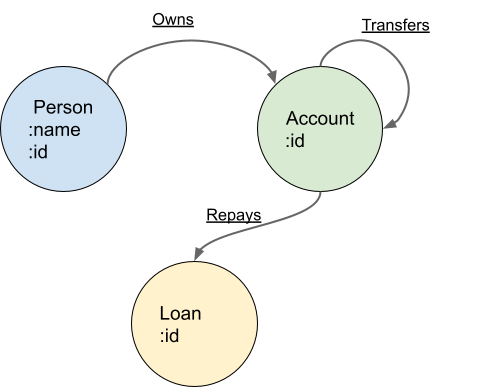



## Nodes
We define 3 types of nodes based on 3 input tables:

- `Person` node, based on Person table
- `Account` node, based on Account table
- `Loan` node, based on Loan table

## Edges

We define 3 types of edges between nodes:

- `AccountRepayLoan` edge, based on AccountRepayLoan table, connecting `Account` node to `Loan` node.
- `AccountTransferAccount` edge, based on AccountTransferAccount table, connecting `Account` node to another `Account` node.
- `PersonOwnAccount` edge, based on PersonOwnAccount table, connecting `Person` node to `Account` node.

In [ ]:
%%bigquery
CREATE PROPERTY GRAPH IF NOT EXISTS graph_db.FinGraph
  NODE TABLES (
    graph_db.Account
      KEY (id)
      LABEL Account
      PROPERTIES (create_time, id, is_blocked, type, description, description_embeddings),
    graph_db.Loan
      KEY (id)
      LABEL Loan
      PROPERTIES (balance, create_time, id, interest_rate,loan_amount),
    graph_db.Person
      KEY (id)
      LABEL Person
      PROPERTIES (id, name)
  )
  EDGE TABLES(
    graph_db.AccountRepayLoan
      KEY (id, loan_id, create_time)
      SOURCE KEY (id) REFERENCES Account (id)
      DESTINATION KEY (loan_id) REFERENCES Loan (id)
      LABEL Repays
      PROPERTIES (amount, create_time, id,loan_id),
    graph_db.AccountTransferAccount
      KEY (id, to_id, create_time)
      SOURCE KEY (id) REFERENCES Account (id)
      DESTINATION KEY (to_id) REFERENCES Account (id)
      LABEL Transfers
      PROPERTIES (amount, create_time, id,to_id),
    graph_db.PersonOwnAccount
      KEY (id, account_id)
      SOURCE KEY (id) REFERENCES Person (id)
      DESTINATION KEY (account_id) REFERENCES Account (id)
      LABEL Owns
      PROPERTIES (account_id, create_time, id)
  );

Executing query with job ID: 1fee613e-1cf8-40b2-a64d-b94f9bcb0119
Query executing: 0.37s


ERROR:
 409 GET https://bigquery.googleapis.com/bigquery/v2/projects/wlm-team-data/queries/1fee613e-1cf8-40b2-a64d-b94f9bcb0119?maxResults=0&location=US&prettyPrint=false: Already Exists: PropertyGraph wlm-team-data.graph_db.FinGraph

Location: US
Job ID: 1fee613e-1cf8-40b2-a64d-b94f9bcb0119



# Query the graph using GQL

## What is graph query traversal in GQL

Graph data are represented as nodes connected by edges. A graph query navigates through these connections, hopping from node to node based on the specified criteria. In a graph query, a "hop" refers to traversing from one node to another along a connecting edge. It signifies a single step in the traversal process.

For instance, in the graph traversal below, there are 2 hops between Person (`Bob`), Account (`18`) and Loan (`27`).

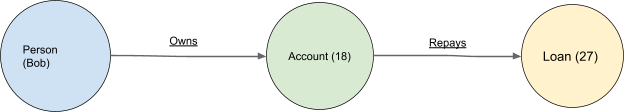

## Query 1 - Basic node and edge pattern matching

You can run the query below to traverse from a person node named `"Jacoby"`, find the accounts owned by the person, and then discover the loans repaid by the account. This is a 2-hop graph query traversal:

- 1st hop: `Person` node to `Account` node via `Owns` edge
- 2nd hop: `Account` node to `Loan` node via `Repays` edge

The way we match node and edge types is based on their labels, such as `:Person`, `:Owns` and `:Account` parts in the query below.

The result returns the `Person` nodes, `Account` nodes, `Loan` nodes and connections between them.


In [ ]:
%%bigquery --graph

GRAPH graph_db.FinGraph
MATCH
  (person:Person {name: "Jacoby"})-[own:Owns]->
  (account:Account)-[repay:Repays]->(loan:Loan)
RETURN
 TO_JSON(person) AS p_json, TO_JSON(own) AS o_json, TO_JSON(account) AS a_json,
 TO_JSON(repay) AS r_json, TO_JSON(loan) AS l_json
ORDER BY repay.create_time;

## Query 2 - Quantified path traversal and return graph elements

The following query matches all account money transfers starting from a source account with `id=75` **within 3 to 6 hops**, to reach a destination account with `id=199`. The `{3,6}` syntax is used to represent a quantified 3 to 6 hop path traversal between `src_accnt` and `dst_accnt`.




In [ ]:
%%bigquery --graph

GRAPH graph_db.FinGraph
MATCH
  (src_accnt:Account {id:75})-[transfers:Transfers]->{3, 7}
  (dst_accnt:Account {id:199})
RETURN
  TO_JSON(src_accnt) AS c1,
  TO_JSON(transfers) AS c2,
  TO_JSON(dst_accnt) AS c3

Query is running:   0%|          |

Downloading:   0%|          |

## Query 3 - Shortest path search

Query 2 finds all three paths from `src_accnt` and `dst_accnt` within the specified range of hops. Each path consists of a distinct number of hops, namely four, five, and six.

If you want to find the shortest path between these two nodes, you can modify it by using path search prefix `MATCH ANY SHORTEST` to achieve it. The query below finds any shortest path between these two accounts within `3 to 6 hops`.


In [ ]:
%%bigquery --graph

GRAPH graph_db.FinGraph
MATCH ANY SHORTEST
  (src_accnt:Account {id:75} )-[transfers:Transfers]->{3,6}
  (dst_accnt:Account {id:199})
RETURN
  TO_JSON(transfers) AS c1,
  TO_JSON(src_accnt) AS c2,
  TO_JSON(dst_accnt) AS c3;

Query is running:   0%|          |

Downloading:   0%|          |

,c1,c2,c3
0,"[{""destination_node_identifier"":""rhYAAAANAAAAp...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApksAAAA...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApscAAAA..."


## Query 4 - Graph queries chained by linear composition

More complicated relationships can be identified by using the `NEXT` keyword to chain blocks of graph queries together.

In the query below, you want to understand the money flow of customer accounts to look for suspicious large inflow or outflow as part of compliance analysis requirements.

To do this, you first find all banking accounts owned by `"Bisla"` in the 1st query block with `MATCH (person:Person {name: "Bisla"})-[:Owns]->(accnt:Account)`.

Then in the second block after `NEXT`, you calculate the total transfer amounts into each account since "2020-01-01".

After that, you apply the same logic for outgoing amounts in the third block query. Finally, you calculate the ratio of inflow amounts to outflow amounts for each account in the last block.

For intermediate query results that you need to access after the `NEXT` keyword, you need to return them at the end of the prior block. For instance, the matched `accnt` is returned in the first block so that the second block can query inflow transfers into these accounts.





In [ ]:
%%bigquery

GRAPH graph_db.FinGraph
MATCH (person:Person {name: "Bisla"})-[:Owns]->(accnt:Account)
RETURN accnt

NEXT

MATCH (accnt)<-[inflow:Transfers]-(:Account)
WHERE inflow.amount > 100
  AND inflow.create_time > TIMESTAMP("2020-1-1")
RETURN accnt, SUM(inflow.amount) AS total_inflow_amounts
GROUP BY accnt

NEXT

MATCH (accnt) -[outflow:Transfers]->(:Account)
WHERE outflow.amount > 100
  AND outflow.create_time > TIMESTAMP("2020-1-1")
RETURN accnt, total_inflow_amounts, SUM(outflow.amount) AS total_outflow_amounts
GROUP BY accnt, total_inflow_amounts

NEXT

LET money_flow_ratio = total_inflow_amounts / total_outflow_amounts
RETURN accnt.id, money_flow_ratio
ORDER BY money_flow_ratio DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,id,money_flow_ratio
0,540,6.592975
1,312,0.495904


The diagram below visualizes what the query traverses.

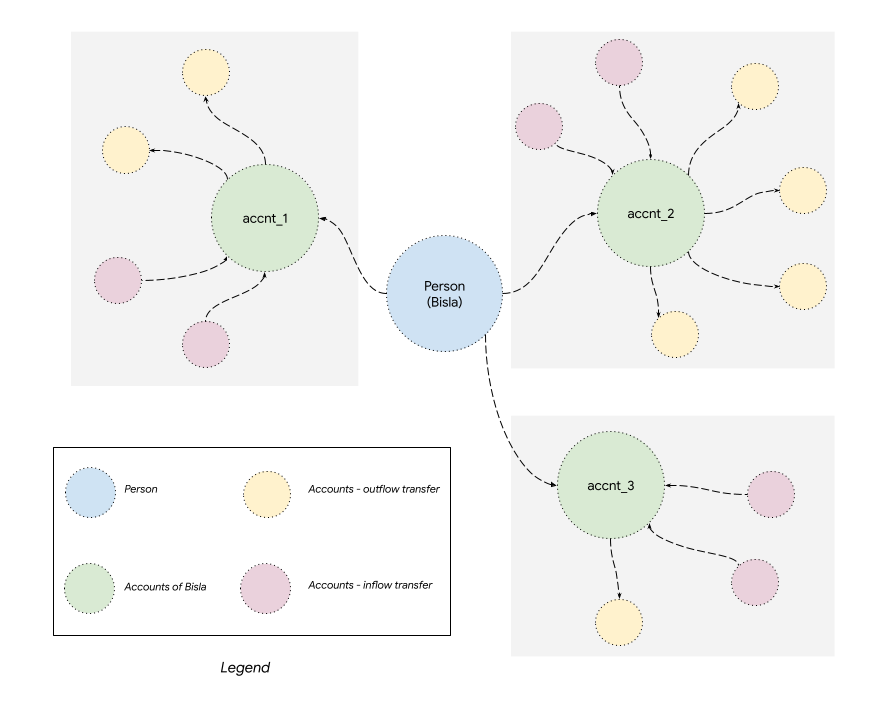

# Query graph and tables together

In BigQuery Graph, SQL and GQL are fully interoperable. You combine GQL and SQL using the `GRAPH_TABLE` operator. Within the operator, you can write GQL as in the previous section. You can then connect results back to the SQL query part via the `RETURN` statement.

For example, you can combine GQL and SQL to find audit information of accounts that have received wire transfers from a suspicious account.

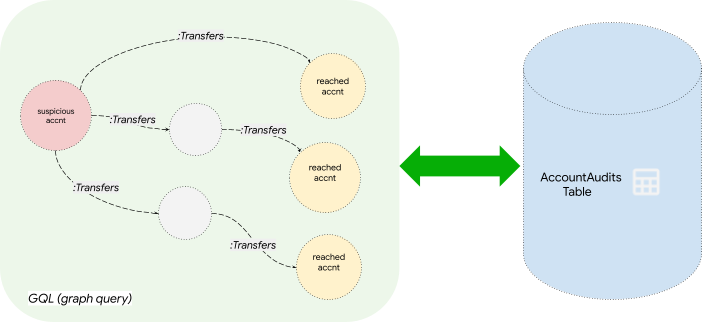

Looking at the following query, the GQL query in the `GRAPH_TABLE` operator traverses **1 or 2 hops** from a suspicious account via the `Transfers` edge, and then returns distinct ids of reached accounts. The query then joins with the `AccountAudits` table to find audit information of those accounts.



In [ ]:
%%bigquery

SELECT
  audit.id as accnt_id,
  audit.audit_timestamp as audit_ts,
  audit.audit_details as details
FROM
  graph_db.AccountAudits audit,
  GRAPH_TABLE(
    graph_db.FinGraph
    MATCH (suspicious_account:Account {id:11})-[:Transfers]->{1,2}(dest_accnt)
    RETURN DISTINCT dest_accnt.id AS reached_account_id
  ) AS accnt_transfers
WHERE accnt_transfers.reached_account_id = audit.id

Query is running:   0%|          |

Downloading:   0%|          |

,accnt_id,audit_ts,details
0,8,2021-11-15 09:54:30+00:00,API key revoked.
1,8,2021-03-11 09:22:28+00:00,Account password reset requested.
2,8,2021-06-23 23:43:16+00:00,Account password updated.
3,8,2020-11-20 01:46:07+00:00,Billing information updated.
4,8,2021-03-06 16:10:39+00:00,New device linked to the account.
5,8,2020-05-26 14:33:07+00:00,Subscription renewed.
6,8,2020-07-15 10:27:34+00:00,User logged out successfully.
7,446,2021-03-08 00:47:19+00:00,Account password reset successfully.
8,446,2020-01-14 12:47:36+00:00,Device unlinked from the account.
9,446,2020-01-22 06:32:48+00:00,Security question updated.


# Graph + Vector Search

 BigQuery [vector search](https://cloud.google.com/bigquery/docs/vector-search-intro) lets you search embeddings to identify semantically similar entities. The GQL query now is integrated with Vector Search, and you can them together smoothly.

## Create Vector Index

A vector index is a data structure designed to let the [VECTOR_SEARCH](https://cloud.google.com/bigquery/docs/reference/standard-sql/search_functions#vector_search) function perform a more effcient vector search of embeddings. The query below creates a vector index on the `description_embeddings` column in `Account` table.

In [ ]:
%%bigquery
CREATE OR REPLACE VECTOR INDEX description_vector_index
ON graph_db.Account(description_embeddings)
OPTIONS(index_type='IVF');

Query is running:   0%|          |

""


## Graph Query + Vector Search

The query below demonstrates how graph queries work with vector search.

1. The first query retrieves all accounts similar to account `102` based on the account description embeddings and stores them into an array `similar_account_to_fraudster` by vector_search.

2. In the second query, we use graph query to retrieve source accounts transfering to these suspicious accounts between 1 and 6 transactions, and also display persons owning these accounts.

In [ ]:
%%bigquery --graph

DECLARE similar_account_to_fraudster DEFAULT ((
 SELECT array_agg(base.id)
 FROM
   VECTOR_SEARCH(TABLE graph_db.Account, 'description_embeddings',
     (SELECT * FROM graph_db.Account WHERE id=102), 'description_embeddings',
     top_k => 6)
 WHERE base.id != 102
));

GRAPH graph_db.FinGraph
MATCH
  (person:Person)-[own:Owns]->(account:Account)
    -[transfer:Transfers]->{1,6}(to_account:Account)
WHERE to_account.id IN UNNEST(similar_account_to_fraudster)
RETURN
  TO_JSON(person) AS c1,
  TO_JSON(own) AS c2,
  TO_JSON(account) AS c3,
  TO_JSON(transfer) AS c4,
  TO_JSON(to_account) AS c5;

Query is running:   0%|          |

Downloading:   0%|          |

,c1,c2,c3,c4,c5
0,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAApioAAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApgABAAA...","[{""destination_node_identifier"":""rhYAAAANAAAAp...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApmgAAAA..."
1,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAApjEAAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApi4BAAA...","[{""destination_node_identifier"":""rhYAAAANAAAAp...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApmwAAAA..."
2,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAApqkAAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApsgBAAA...","[{""destination_node_identifier"":""rhYAAAANAAAAp...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApmQAAAA..."
3,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAAphABAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApqkAAAA...","[{""destination_node_identifier"":""rhYAAAANAAAAp...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApmIAAAA..."


# Graph Query + Full Text Search

With BigQuery search indexes, BigQuery provides a powerful columnar store and text search in one platform, enabling efficient row lookups when you need to find individual rows of data.

We can easily integrate full text search with graph queries.

## Create Full Text Search Index

A search index is a data structure designed to enable very efficient search with the full text [SEARCH](https://cloud.google.com/bigquery/docs/search) function.

In [ ]:
%%bigquery

CREATE SEARCH INDEX account_search_index
ON graph_db.Account(ALL COLUMNS);

Query is running:   0%|          |

""


## Full Text Search Query

The query below demonstrates how graph queries work with full text search.

1. The first part of the query searches all accounts with description containing `Foreign` and `Currency` tokens.

2. The second part of query, we continues searching persons who own these accounts, and return persons in result.


In [ ]:
%%bigquery --graph

GRAPH graph_db.FinGraph
MATCH (account:Account)
WHERE SEARCH(account.description, 'Foreign currency')
RETURN account

NEXT

MATCH (account:Account)<-[Own]-(person:Person)
RETURN
  TO_JSON(person) AS c1,
  TO_JSON(own) AS c2,
  TO_JSON(account) AS c3;

Query is running:   0%|          |

Downloading:   0%|          |

,c1,c2,c3
0,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAApioAAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAAptMBAAA..."
1,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAApkEAAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApjUCAAA..."
2,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAApsAAAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApmMCAAA..."
3,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAApugAAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApmQBAAA..."
4,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAApiABAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAApqwAAAA..."
5,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAApiEBAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAAphkBAAA..."
6,"{""identifier"":""rhYAAAANAAAApgIAAAAAAAAApjoBAAA...","{""destination_node_identifier"":""rhYAAAANAAAApg...","{""identifier"":""rhYAAAANAAAApgAAAAAAAAAAplYAAAA..."
